# Training a neural network to fit curves to claims data

This Jupyter notebook describes a new method of fitting curves to claims data. The curves it produces are for use in frequency-severity modelling of insurance claims. However this is an experimental technique which requires further refining before it is suitable for use in actual insurance modelling work.

The method involves training a neural network to curve-fit a, 4-parameter, cubic Bézier curve to claims severity data. The resulting trained neural network accepts claims severity data as input, and will output predicted best estimate Bézier parameters.

The complete Python code is provided below, and will run on any Jupyter server configured with the required Tensorflow libraries. 

Steps covered:

  1. The generation of randomised cubic Bézier curves that satisfy the requirements of probabilistic cumulative distribution functions.
  
  1. Creation of a labelled training set of synthetic data by random sampling from Bézier curves.
  
  1. The training of a regression neural network on the synthetic data to provide best estimates of the Bézier parameters.

  1. Using the trained neural network to produce curve fits to real data.

  1. A discussion of the strengths, limitations and further applications of the method.


## Install and import the various python libraries we will use

In [ ]:
# install the libraries we need
# Note that Tensorflow is likely to need further configuration beyond the pip install shown below
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install h5py
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import random
import tensorflow as tf
import h5py

##  Curve fitting overview

Claim modelling in actuarial work often involves fitting smooth parametric curves to actual claims data. Using smooth parametric curves provide a way of extrapolating from a limited set of loss data to a complete range of losses.

It is common practice in General Insurance to model claims frequency and severity separately using Monte Carlo modelling techniques. This provides a straightforward way to model non-linear insurance contract features.

A number of different probability distributions are used to approximate claims data. A common feature is that they are often skewed distributions, reflecting the same skewed, or 'fat-tailed', distributions often observed in real insurance claims.

Examples of commonly used distributions include: [Pareto](https://en.wikipedia.org/wiki/Pareto_distribution), [Lognormal](https://en.wikipedia.org/wiki/Log-normal_distribution), [Beta](https://en.wikipedia.org/wiki/Beta_distribution), and [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution)

**Example Cumulative Distribution Functions (CDFs)**

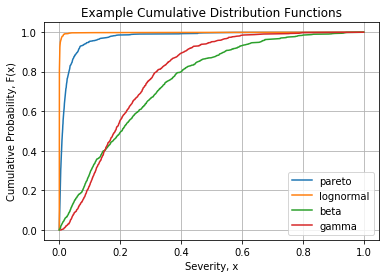

In [3]:
# plot examples of different cumulative distribution functions
# the parameters of each distribution have been hardcoded here but can be changed 
n= 1000
xvals_pareto = np.random.pareto(2, n) 
xvals_pareto.sort()
xvals_pareto = xvals_pareto /xvals_pareto[-1]

xvals_lognormal = np.random.lognormal(1.5,3,n ) 
xvals_lognormal.sort()
xvals_lognormal = xvals_lognormal /xvals_lognormal[-1]

xvals_beta = np.random.beta(1,4,n)
xvals_beta.sort()
xvals_beta = xvals_beta /xvals_beta[-1]
              
xvals_gamma = np.random.gamma(2, 2,n) 
xvals_gamma.sort()
xvals_gamma = xvals_gamma /xvals_gamma[-1]

yvals = np.arange(0,n,1)/n
plt.plot(xvals_pareto,yvals, label='pareto')
plt.plot(xvals_lognormal,yvals, label='lognormal')
plt.plot(xvals_beta,yvals, label='beta')
plt.plot(xvals_gamma,yvals, label='gamma')
plt.title('Example Cumulative Distribution Functions')
plt.xlabel('Severity, x')
plt.ylabel('Cumulative Probability, F(x)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Curve Fitting Issues

A typical approach to curve fitting involves selecting a parametric probability distribution and using the actual claims data to fit appropriate paramaters. for example using a [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) approach. 

Common issues are: 
  1. Judgement is needed to select the distribution family likely to provide the best fit to the data
  1. A need to use [Least Squares](https://en.wikipedia.org/wiki/Least_squares) or other goodness-of-fit tests to compare multiple distribution families
  1. Obtaining curves on the full range of values you are interested in - so avoiding issues of unbounded severity - or curve fits only available above a given threshold
  1. Working with real world data that does not have a natural fit to any of the common distribution families

## What could a useful claims severity solution look like?

A useful curve fitting technique might have the following features:
  1. Produce smooth parametric distributions that can be described by a small number of parameters
  1. Provide severity values in the range (0,1) - to be applied to maxmium exposure amounts to generate monnetary losses
  1. No pre-knowledge of the underlying distribution family should be required
  1. Provide a good fit to a wide range of real world claims data, without the need to compare goodness-of-fit across different distribution families
  1. Offers a simple method of generating means, standard deviations and other statistics
  1. Allow measurement of the confidence in the goodness-of-fit
  


## Bézier Curves

[Bezier curves](https://en.wikipedia.org/wiki/B%C3%A9zier_curve) have been used in graphic design since the 1960s, originally for car design and more recently in computer graphics. 
Some previous research has been done in using Bézier curves as probability distributions. Relevant examples include: [Wagner and Wilson (1996)](https://people.engr.ncsu.edu/jwilson/files/wagner96iie.pdf) and [Torres-Jimenez and Montenegro-Diaz (2017)](https://arxiv.org/pdf/1709.05534.pdf). We will be considering cubic-bezier curves bounded between (0,1) on both the x and y axes using the explicit form of the curve:

$
\begin{equation*}
B(t) = \left(1 - t\right)^3P_0 + 3\left(1 - t\right)^2tP_1 + 3\left(1 - t\right)t^2P_2 + t^3P_3, 0 \leq t \leq 1
\end{equation*}
$

We will set $\begin{equation*} P_0 =(0,0) \end{equation*}$ and $\begin{equation*} P_3 =(1,1) \end{equation*}$

### Code to render our cubic Bézier's

First we define a simple 'Point' class to make it easier to work with x and y coordinates, and a second 'ArrayData' class to convert from a list of Point's to a list of x and y's that will make plotting charts easier.

In [4]:
class Point():
	"""simple class for x y coordinates"""
	def __init__(self,x,y):
		self.x = x
		self.y = y		
	
	def __add__(self,other):
		return Point(self.x+other.x,self.y+other.y)
	
	def __mul__(self,other):
		return Point(self.x*other,self.y*other)
	
	__rmul__ = __mul__

class ArrayData():
	"""simple class for easier array access"""
	
	def __init__(self,object_array):
		"""convert an array of point objects into an array for plot"""
		self.x=[]
		self.y=[]
		for item in object_array:
			self.x.append(item.x)
			self.y.append(item.y)

Then we define some functions to get x and y points from a Bezier curve using a [Bisection method](https://en.wikipedia.org/wiki/Bisection_method)

In [5]:
def get_x_from_t(p0,p1,p2,p3,t):
	"""get the x value given t is known"""
	xy = ((1-t)**3)*p0 + (3*(1-t)**2)*t*p1 + 3*(1-t)*(t**2)*p2 + (t**3)*p3
	return xy.x
	
def get_y_from_t(p0,p1,p2,p3,t):
	"""get the y value given t is known"""
	xy = ((1-t)**3)*p0 + (3*(1-t)**2)*t*p1 + 3*(1-t)*(t**2)*p2 + (t**3)*p3
	return xy.y	
	
def get_x_from_y(p0,p1,p2,p3,y):
    """bisection method to get x given a y"""
    # we set an aribitrary level of accuracy
    accuracy= 0.0000001
    t_low=0
    t_high=1
    while True:
        t = (t_low+t_high)/2
        trial_y = get_y_from_t(p0,p1,p2,p3,t)
        if(abs(trial_y-y)<accuracy):
            break
        if(trial_y<y): 
            t_low = t
        else:
            t_high= t
    return get_x_from_t(p0,p1,p2,p3,t)

Let's write another function to plot Bezier curves and sampled loss data:

In [6]:
def buildcurve(p0,p1,p2,p3,x_vals=[]):
    """a function to plot a beaier curve and, if provided, an array of sampled data"""
    bezier = lambda t: ((1-t)**3)*p0 + (3*(1-t)**2)*t*p1 + 3*(1-t)*(t**2)*p2 + (t**3)*p3
    xy_arr = np.zeros((2, 1000))
    for t in range(1000):
        this_xy = bezier(t/1000)
        xy_arr[0][t] = this_xy.x
        xy_arr[1][t] = this_xy.y
    
    # Add scatter plot sample data
    x_vals = list(filter(lambda a: abs(a) > 0.0000001, x_vals))
    spacing =len(x_vals)
    x_vals = np.array(x_vals)
    x_vals.sort()
    y_vals = np.arange(1, (spacing+1), 1)/(spacing+1)
    
    # plot the data
    fig = plt.figure()
    ax = plt.axes()
    ax.axis([0, 1, 0, 1])
    plt.xlabel('x')
    plt.ylabel('F(x)')
    ax.plot(xy_arr[0],xy_arr[1])
    ax.plot(p0.x,p0.y,'or', label='P0')
    ax.plot(p1.x,p1.y,'or', label='P1')
    ax.plot(p2.x,p2.y,'or', label='P2')
    ax.plot(p3.x,p3.y,'or', label='P3')
    ax.plot(x_vals,y_vals,'og', label='Point Data')
    ax.annotate('P0 =(%.0f,%.0f)' % (p0.x , p0.y), xy=(p0.x , p0.y), xytext=(5, 5),textcoords ='offset pixels')
    ax.annotate('P1 =(%.2f,%.2f)' % (p1.x , p1.y), xy=(p1.x , p1.y), xytext=(5, 0),textcoords ='offset pixels')
    ax.annotate('P2 =(%.2f,%.2f)' % (p2.x , p2.y), xy=(p2.x , p2.y), xytext=(5, 0),textcoords ='offset pixels')
    ax.annotate('P3 =(%.0f,%.0f)' % (p3.x , p3.y), xy=(p3.x , p3.y), xytext=(5, 5),textcoords ='offset pixels')
    plt.show()

Now we can define our  $\begin{equation*} P_0,P_1,P_2,P_3 \end{equation*}$ points and take a look at some randomly generated curves

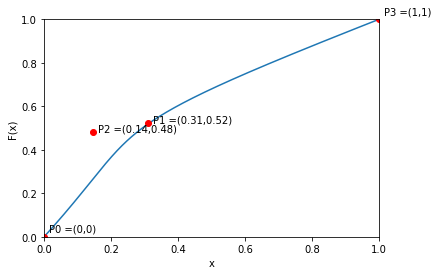

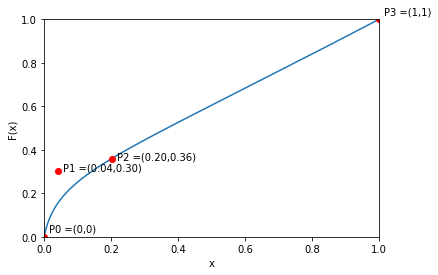

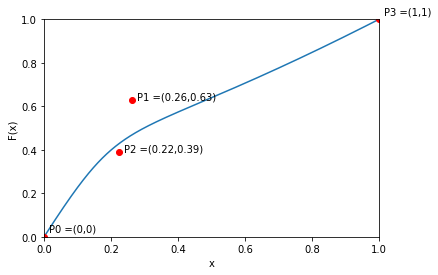

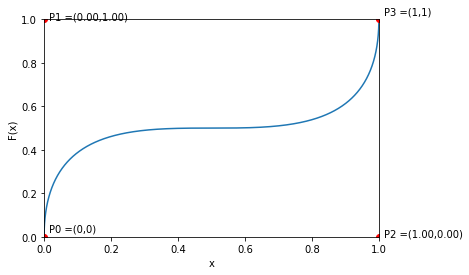

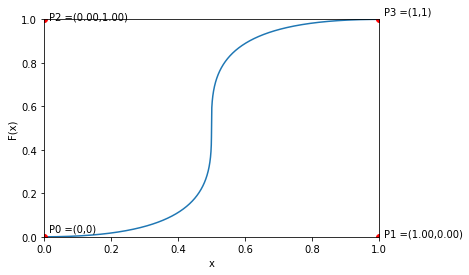

In [7]:
p0 = Point(0,0)
p3 = Point(1,1)

for i in range(3):
    p1 = Point(random.random(),random.random())
    p2 = Point(random.random(),random.random())
    buildcurve(p0,p1,p2,p3)

# generating some extremes
p1 = Point(0,1)
p2 = Point(1,0)
buildcurve(p0,p1,p2,p3)
p1 = Point(1,0)
p2 = Point(0,1)
buildcurve(p0,p1,p2,p3)

## Using Bézier curves as Distribution Functions

These randomly constructed Bézier curves give us functions that appear to satisfy the requirements of a cummulative distribution function $\begin{equation*} F_X\left(x\right) = P\left(X \leq x \right)  \end{equation*}$
  1. defined for $\begin{equation*}0 \leq x \leq 1 \end{equation*}$
  2. smooth curve
  3. monotonically  increasing (for right choices of $\begin{equation*}P_1 \end{equation*}$ and $\begin{equation*}P_2 \end{equation*}$)
 
 

We can take random samples from these curves to produce a random set of $\begin{equation*} \left(x,F_X\left(x\right)\right)\end{equation*}$.

Taking $\begin{equation*}F_X\left(x\right) = y\end{equation*}$ we can refer to our random points as  $\begin{equation*} \left(x,y\right)\end{equation*}$.

We will now write a function to create random samples from a set of randomly generated Bézier curves. 


In [8]:
def generate_data(number_bezier,number_samples):
    """takes the number of curves required and maximum number of samples from each curve as inputs and returns a random data set"""
    data_set=[]
    for i in range(number_bezier):
        p1 = Point(random.random(),random.random())
        p2 = Point(random.random(),random.random())  
        retvalues =[0]*number_samples
        for j in range(0,int(number_samples*random.random())):
            #compute values of x (severity) given different random y (cdf)
            y = random.random()
            x = get_x_from_y(p0,p1,p2,p3,y)
            retvalues[j]=x
        data_set.append([p1.x, p1.y,p2.x, p2.y] + retvalues)
    return data_set

Now we can generate data sets of any size as needed. As an example here we will generate four random Bézier curves with up to 50 randomly sampled values.
Note that we are plotting these by sorting the sampled values and assuming they are uniformly spaced between  $\begin{equation*}0 \leq F_X\left(x\right) \leq 1\end{equation*}$

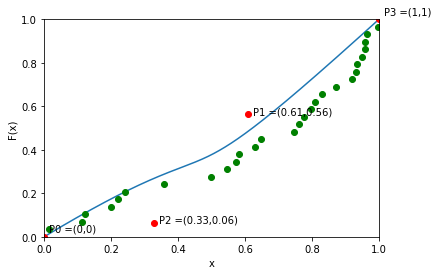

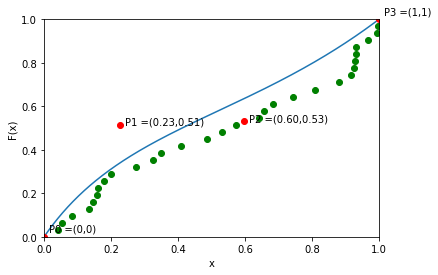

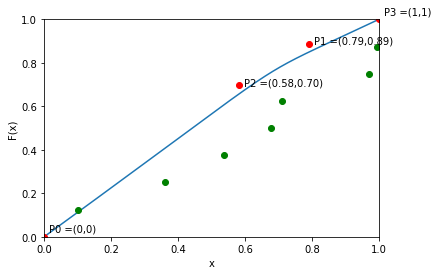

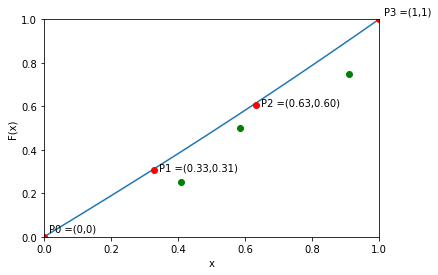

In [9]:
data_set=generate_data(4,50)
for i in range(len(data_set)):
    buildcurve(p0,Point(data_set[i][0],data_set[i][1]),Point(data_set[i][2],data_set[i][3]),p3,data_set[i][4:])


## Creating a large data set

Now we create a large data set to train and test a neural network. 
We will write this data set to disk to save time later on. 

We will read the data set from the file when it's time to train our neural network.

Let's create a dataset of 500,000 items, each item having up to 500 random samples.

In [ ]:
# Saved as a 'raw' cell as this is time consuming to run - change to a 'code' cell to execute
sample_size = 500
# the total number of records we want to create
total_size = 500000
# the number of chunks to break this into - to avoid running out of memory
size_per_set = 1000

# create an empty file
data_set = np.zeros(shape = (0,sample_size+4) )

# h5py is a useful library for reading/writing large numpy arrays to disk
with h5py.File('bezier_data.hdf5', 'w') as hf:
    dset = hf.create_dataset('bezier', data=data_set,maxshape=(None, sample_size+4))

# now execute it
for j in range(int(total_size/size_per_set)):
    data_set = generate_data(size_per_set,sample_size)
    #convert to a numpy array
    print('appending batch %d' % (j))
    data_set = np.array(data_set) 
    with h5py.File('bezier_data.hdf5', 'a') as hf:
        hf["bezier"].resize((hf["bezier"].shape[0] + data_set.shape[0]), axis =0) 
        hf["bezier"][-data_set.shape[0]:] = data_set

print('finished generating data set')

## Training a neural network

Now that we have a labelled dataset of sampled data (inputs) and their corresponding Bézier curve parameters (outputs), we can use it to train a regression neural network. 

A portion of our data will be held back and used only for evaluation (not training).

We will use a neural network with an input layer of 500 input nodes (allowing up to 500 claim inputs), a first hidden layer with 240 nodes, a second hidden layer with 12 nodes, a third hidden layer with 8 nodes, and an output layer with 4 nodes (corresponding to $\begin{equation*}P_1\left(x\right), P_1\left(y\right), P_2\left(x\right), P_2\left(y\right) \end{equation*}$).

We will use Tensorflow to implement the training and will use sigmoid activation functions and batch training.

![Neural Network](Nn.jpeg)

To avoid running out of computer memory we will batch train our model directly from the large data file we wrote to disk. We will break it into 10 pieces. 

One of these will be used for evaluation and the other nine for training. 

First we prepare our data for tensorflow: The first of the nine chunks will be used to compute the data's statistical mean values and to normalise the whole data set.

In [10]:
# we load in our data
hf = h5py.File('bezier_data.hdf5', 'r')
np_data = hf.get('bezier')

# Chunk size
total_train_chunks = 9
output_nodes = 4
total_size = np_data.shape[0]
sample_size = np_data.shape[1] - output_nodes
test_size = int(total_size/(total_train_chunks+1))
train_size = total_size - test_size
chunk = int(train_size/total_train_chunks)

# using the 10'th chunk as test data
y_test = np_data[train_size:total_size,0:output_nodes]
x_test = np_data[train_size:total_size,output_nodes:(output_nodes+sample_size)]

# we will normalise all data based on the means from the first chunk of the data
y_train = np_data[0:chunk,0:output_nodes]
x_train = np_data[0:chunk,output_nodes:(output_nodes+sample_size)]

# normalise the data, all inputs and outputs already bounded by 0,1
y_mean = np.mean(y_train,axis=0)
x_mean = np.mean(x_train,axis=0)

# we define some function to normalise and de-normalise the data
def normalise_x(x):
    return x - x_mean

def normalise_y(y):
    return y - y_mean
    
def denormalise_x(x):
    return x + x_mean

def denormalise_y(y):
    return y + y_mean

x_test = normalise_x(x_test)
y_test = normalise_y(y_test)

x_train = normalise_x(x_train)
y_train = normalise_y(y_train)


# This is a key parameter - the hidden layer structure we will use in our neural network
nn_hidden = [240,12,8]

Now we train the neural network in batches - we're going to do multiple passes (epochs) through the full training data:

In [ ]:
# we generate a random string to record the data as we train
model_path = './tmp/regression_' + str(int(random.random()*1000000))
# define the other settings for tensorflow
feature_columns = [tf.feature_column.numeric_column(key="x", shape=sample_size)]

# each step will pass through a batch of 20 random samples
feed_batch_size = 20
total_epochs = 100
predict_input_fn = tf.estimator.inputs.numpy_input_fn({"x": x_test}, num_epochs=1, shuffle=False)
eval_input_fn = tf.estimator.inputs.numpy_input_fn({"x": x_test}, y_test, batch_size=feed_batch_size, num_epochs=1, shuffle=True)

# we are using the tensorflow pre-built DNNRegressor, this requires a warmstart to record training progress into tensorboard
for j in range(total_epochs):
    for i in range(total_train_chunks):
        print ('processing chunk %d' % (i))
        if ((i==0) and (j==0)):
            estimator = tf.estimator.DNNRegressor(feature_columns=feature_columns, hidden_units=nn_hidden, label_dimension=output_nodes, 
                                                  activation_fn=tf.nn.sigmoid, model_dir=model_path, 
                                                  config=tf.estimator.RunConfig().replace(save_summary_steps=10))        
        else:
            #continue training with the new batch of data using a 'warm start'
            estimator = tf.estimator.DNNRegressor(feature_columns=feature_columns, hidden_units=nn_hidden, label_dimension=output_nodes, 
                                                  activation_fn=tf.nn.sigmoid, 
                                                  model_dir=model_path,warm_start_from=model_path, 
                                                  config=tf.estimator.RunConfig().replace(save_summary_steps=10))
    
        # now we read in the next chunk of data
        y_train = np_data[chunk*i:chunk*(i+1),0:output_nodes]
        x_train = np_data[chunk*i:chunk*(i+1),output_nodes:(output_nodes+sample_size)]

        # and we normalise it pre-training 
        x_train = normalise_x(x_train)
        y_train = normalise_y(y_train)

        # define our tensorflow input function and run the train and evaluate steps
        train_input_fn = tf.estimator.inputs.numpy_input_fn({"x": x_train}, y_train, batch_size=feed_batch_size, num_epochs=1, shuffle=True)
        estimator.train(input_fn=train_input_fn, steps=int(x_train.shape[0]/feed_batch_size))
        estimator.evaluate(input_fn=eval_input_fn, steps=int(x_test.shape[0]/feed_batch_size))

processing chunk 0
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecaf2f8a90>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflo

INFO:tensorflow:global_step/sec: 496.205
INFO:tensorflow:loss = 4.454254, step = 4201 (0.201 sec)
INFO:tensorflow:global_step/sec: 424.7
INFO:tensorflow:loss = 5.1723804, step = 4301 (0.236 sec)
INFO:tensorflow:global_step/sec: 445.49
INFO:tensorflow:loss = 4.650652, step = 4401 (0.224 sec)
INFO:tensorflow:global_step/sec: 416.492
INFO:tensorflow:loss = 5.424168, step = 4501 (0.240 sec)
INFO:tensorflow:global_step/sec: 412.784
INFO:tensorflow:loss = 4.650698, step = 4601 (0.242 sec)
INFO:tensorflow:global_step/sec: 478.911
INFO:tensorflow:loss = 4.8998833, step = 4701 (0.209 sec)
INFO:tensorflow:global_step/sec: 503.653
INFO:tensorflow:loss = 4.3829756, step = 4801 (0.198 sec)
INFO:tensorflow:global_step/sec: 506.349
INFO:tensorflow:loss = 5.475295, step = 4901 (0.197 sec)
INFO:tensorflow:Saving checkpoints for 5000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 6.251747.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensor

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 5.3219585, step = 11301 (0.151 sec)
INFO:tensorflow:global_step/sec: 622.565
INFO:tensorflow:loss = 5.8106, step = 11401 (0.160 sec)
INFO:tensorflow:global_step/sec: 469.272
INFO:tensorflow:loss = 4.8622403, step = 11501 (0.214 sec)
INFO:tensorflow:global_step/sec: 472.481
INFO:tensorflow:loss = 4.87315, step = 11601 (0.217 sec)
INFO:tensorflow:global_step/sec: 402.68
INFO:tensorflow:loss = 5.476177, step = 11701 (0.243 sec)
INFO:tensorflow:global_step/sec: 530.961
INFO:tensorflow:loss = 5.5649753, step = 11801 (0.188 sec)
INFO:tensorflow:global_step/sec: 621.027
INFO:tensorflow:loss = 4.2724314, step = 11901 (0.161 sec)
INFO:tensorflow:global_step/sec: 564.308
INFO:tensorflow:loss = 5.934966, step = 12001 (0.178 sec)
INFO:tensorflow:global_step/sec: 646.039
INFO:tensorflow:loss = 6.0546827, step = 12101 (0.154 sec)
INFO:tensorflow:global_step/sec: 644.912
INFO:tensorflow:loss = 5.536354, step = 12201 (0.155 sec)
INFO:tensorflow:global_step/sec: 610.264
INFO:tens

INFO:tensorflow:global_step/sec: 69.6601
INFO:tensorflow:loss = 5.5991945, step = 16401 (1.435 sec)
INFO:tensorflow:global_step/sec: 66.8346
INFO:tensorflow:loss = 5.1842775, step = 16501 (1.484 sec)
INFO:tensorflow:global_step/sec: 65.4729
INFO:tensorflow:loss = 5.4828844, step = 16601 (1.528 sec)
INFO:tensorflow:global_step/sec: 82.0252
INFO:tensorflow:loss = 6.7563066, step = 16701 (1.218 sec)
INFO:tensorflow:global_step/sec: 78.8804
INFO:tensorflow:loss = 5.426298, step = 16801 (1.268 sec)
INFO:tensorflow:global_step/sec: 68.8052
INFO:tensorflow:loss = 6.0065637, step = 16901 (1.470 sec)
INFO:tensorflow:global_step/sec: 21.6821
INFO:tensorflow:loss = 5.6992836, step = 17001 (4.614 sec)
INFO:tensorflow:global_step/sec: 81.0654
INFO:tensorflow:loss = 4.6212063, step = 17101 (1.216 sec)
INFO:tensorflow:global_step/sec: 85.9619
INFO:tensorflow:loss = 5.28355, step = 17201 (1.163 sec)
INFO:tensorflow:global_step/sec: 80.8584
INFO:tensorflow:loss = 5.335248, step = 17301 (1.249 sec)
INFO

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 626.036
INFO:tensorflow:loss = 5.204695, step = 23701 (0.160 sec)
INFO:tensorflow:global_step/sec: 609.994
INFO:tensorflow:loss = 5.380527, step = 23801 (0.164 sec)
INFO:tensorflow:global_step/sec: 603.213
INFO:tensorflow:loss = 4.6773815, step = 23901 (0.166 sec)
INFO:tensorflow:global_step/sec: 593.58
INFO:tensorflow:loss = 4.8889256, step = 24001 (0.168 sec)
INFO:tensorflow:global_step/sec: 541.52
INFO:tensorflow:loss = 5.1154203, step = 24101 (0.184 sec)
INFO:tensorflow:global_step/sec: 640.634
INFO:tensorflow:loss = 5.484029, step = 24201 (0.156 sec)
INFO:tensorflow:global_step/sec: 570.424
INFO:tensorflow:loss = 5.106309, step = 24301 (0.175 sec)
INFO:tensorflow:global_step/sec: 592.474
INFO:tensorflow:loss = 4.896118, step = 24401 (0.168 sec)
INFO:tensorflow:global_step/sec: 588.831
INFO:tensorflow:loss = 7.0116158, step = 24501 (0.170 sec)
INFO:tensorflow:global_step/sec: 652.917
INFO:tensorflow:loss = 4.5895987, step = 24601 (0.153 sec)
INFO:te

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 603.081
INFO:tensorflow:loss = 5.1575627, step = 31201 (0.166 sec)
INFO:tensorflow:global_step/sec: 606.159
INFO:tensorflow:loss = 5.4017005, step = 31301 (0.165 sec)
INFO:tensorflow:global_step/sec: 580.725
INFO:tensorflow:loss = 4.991232, step = 31401 (0.172 sec)
INFO:tensorflow:global_step/sec: 636.394
INFO:tensorflow:loss = 5.091813, step = 31501 (0.158 sec)
INFO:tensorflow:global_step/sec: 576.903
INFO:tensorflow:loss = 5.5038776, step = 31601 (0.173 sec)
INFO:tensorflow:global_step/sec: 649.69
INFO:tensorflow:loss = 5.228789, step = 31701 (0.154 sec)
INFO:tensorflow:global_step/sec: 641.348
INFO:tensorflow:loss = 4.7747755, step = 31801 (0.156 sec)
INFO:tensorflow:global_step/sec: 619.791
INFO:tensorflow:loss = 4.9020534, step = 31901 (0.161 sec)
INFO:tensorflow:global_step/sec: 561.945
INFO:tensorflow:loss = 5.3853817, step = 32001 (0.178 sec)
INFO:tensorflow:global_step/sec: 645.101
INFO:tensorflow:loss = 4.6727743, step = 32101 (0.155 sec)
INFO

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 74.037
INFO:tensorflow:loss = 4.4523163, step = 38701 (1.350 sec)
INFO:tensorflow:global_step/sec: 78.4244
INFO:tensorflow:loss = 4.4475136, step = 38801 (1.275 sec)
INFO:tensorflow:global_step/sec: 81.5592
INFO:tensorflow:loss = 4.9026084, step = 38901 (1.227 sec)
INFO:tensorflow:global_step/sec: 75.9797
INFO:tensorflow:loss = 4.7960787, step = 39001 (1.333 sec)
INFO:tensorflow:global_step/sec: 69.6613
INFO:tensorflow:loss = 5.473566, step = 39101 (1.419 sec)
INFO:tensorflow:global_step/sec: 69.6058
INFO:tensorflow:loss = 5.3552723, step = 39201 (1.436 sec)
INFO:tensorflow:global_step/sec: 80.2548
INFO:tensorflow:loss = 4.5837083, step = 39301 (1.246 sec)
INFO:tensorflow:global_step/sec: 82.8448
INFO:tensorflow:loss = 4.568751, step = 39401 (1.207 sec)
INFO:tensorflow:global_step/sec: 42.0244
INFO:tensorflow:loss = 4.9524345, step = 39501 (2.436 sec)
INFO:tensorflow:global_step/sec: 23.0936
INFO:tensorflow:loss = 6.4907775, step = 39601 (4.275 sec)
INF

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 581.506
INFO:tensorflow:loss = 5.5206003, step = 46201 (0.172 sec)
INFO:tensorflow:global_step/sec: 654.98
INFO:tensorflow:loss = 5.8616877, step = 46301 (0.153 sec)
INFO:tensorflow:global_step/sec: 616.742
INFO:tensorflow:loss = 5.944483, step = 46401 (0.162 sec)
INFO:tensorflow:global_step/sec: 581.963
INFO:tensorflow:loss = 5.4171352, step = 46501 (0.172 sec)
INFO:tensorflow:global_step/sec: 648.885
INFO:tensorflow:loss = 4.6560135, step = 46601 (0.154 sec)
INFO:tensorflow:global_step/sec: 610.004
INFO:tensorflow:loss = 5.2319098, step = 46701 (0.164 sec)
INFO:tensorflow:global_step/sec: 616.518
INFO:tensorflow:loss = 5.2638817, step = 46801 (0.163 sec)
INFO:tensorflow:global_step/sec: 566.794
INFO:tensorflow:loss = 4.7248755, step = 46901 (0.176 sec)
INFO:tensorflow:global_step/sec: 642.177
INFO:tensorflow:loss = 5.2218776, step = 47001 (0.155 sec)
INFO:tensorflow:global_step/sec: 611.337
INFO:tensorflow:loss = 5.8685613, step = 47101 (0.164 sec)
IN

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 80.1974
INFO:tensorflow:loss = 4.8525333, step = 53701 (1.254 sec)
INFO:tensorflow:global_step/sec: 72.5001
INFO:tensorflow:loss = 5.105729, step = 53801 (1.376 sec)
INFO:tensorflow:global_step/sec: 68.8977
INFO:tensorflow:loss = 5.6223164, step = 53901 (1.440 sec)
INFO:tensorflow:global_step/sec: 77.9865
INFO:tensorflow:loss = 4.35302, step = 54001 (1.282 sec)
INFO:tensorflow:global_step/sec: 74.893
INFO:tensorflow:loss = 3.9256487, step = 54101 (1.352 sec)
INFO:tensorflow:global_step/sec: 21.0931
INFO:tensorflow:loss = 4.1922984, step = 54201 (4.724 sec)
INFO:tensorflow:global_step/sec: 68.9984
INFO:tensorflow:loss = 4.8992643, step = 54301 (1.450 sec)
INFO:tensorflow:global_step/sec: 76.1345
INFO:tensorflow:loss = 5.6123643, step = 54401 (1.313 sec)
INFO:tensorflow:global_step/sec: 82.5569
INFO:tensorflow:loss = 4.8780355, step = 54501 (1.211 sec)
INFO:tensorflow:global_step/sec: 78.4067
INFO:tensorflow:loss = 5.687038, step = 54601 (1.276 sec)
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 61.6685
INFO:tensorflow:loss = 6.2506485, step = 61201 (1.603 sec)
INFO:tensorflow:global_step/sec: 75.2709
INFO:tensorflow:loss = 5.29905, step = 61301 (1.328 sec)
INFO:tensorflow:global_step/sec: 79.6624
INFO:tensorflow:loss = 5.246277, step = 61401 (1.255 sec)
INFO:tensorflow:global_step/sec: 82.9914
INFO:tensorflow:loss = 6.3856797, step = 61501 (1.205 sec)
INFO:tensorflow:global_step/sec: 72.4162
INFO:tensorflow:loss = 5.220646, step = 61601 (1.381 sec)
INFO:tensorflow:global_step/sec: 83.6928
INFO:tensorflow:loss = 3.8633895, step = 61701 (1.211 sec)
INFO:tensorflow:global_step/sec: 83.6972
INFO:tensorflow:loss = 5.1712017, step = 61801 (1.178 sec)
INFO:tensorflow:global_step/sec: 201.699
INFO:tensorflow:loss = 5.0760174, step = 61901 (0.496 sec)
INFO:tensorflow:global_step/sec: 601.059
INFO:tensorflow:loss = 4.8898163, step = 62001 (0.166 sec)
INFO:tensorflow:global_step/sec: 617.647
INFO:tensorflow:loss = 5.156533, step = 62101 (0.162 sec)
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 623.878
INFO:tensorflow:loss = 4.39791, step = 68701 (0.161 sec)
INFO:tensorflow:global_step/sec: 632.086
INFO:tensorflow:loss = 5.8230762, step = 68801 (0.158 sec)
INFO:tensorflow:global_step/sec: 608.889
INFO:tensorflow:loss = 5.577712, step = 68901 (0.164 sec)
INFO:tensorflow:global_step/sec: 646.778
INFO:tensorflow:loss = 4.9693413, step = 69001 (0.155 sec)
INFO:tensorflow:global_step/sec: 612.004
INFO:tensorflow:loss = 4.412861, step = 69101 (0.163 sec)
INFO:tensorflow:global_step/sec: 577.12
INFO:tensorflow:loss = 4.274949, step = 69201 (0.173 sec)
INFO:tensorflow:global_step/sec: 670.559
INFO:tensorflow:loss = 4.3682694, step = 69301 (0.149 sec)
INFO:tensorflow:global_step/sec: 634.036
INFO:tensorflow:loss = 5.5514164, step = 69401 (0.158 sec)
INFO:tensorflow:global_step/sec: 651.74
INFO:tensorflow:loss = 5.7042155, step = 69501 (0.153 sec)
INFO:tensorflow:global_step/sec: 637.227
INFO:tensorflow:loss = 4.3659444, step = 69601 (0.157 sec)
INFO:te

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 77.7956
INFO:tensorflow:loss = 5.186346, step = 76201 (1.327 sec)
INFO:tensorflow:global_step/sec: 80.5633
INFO:tensorflow:loss = 5.4601855, step = 76301 (1.200 sec)
INFO:tensorflow:global_step/sec: 75.7284
INFO:tensorflow:loss = 3.5020456, step = 76401 (1.321 sec)
INFO:tensorflow:global_step/sec: 71.1978
INFO:tensorflow:loss = 4.6281433, step = 76501 (1.405 sec)
INFO:tensorflow:global_step/sec: 73.0082
INFO:tensorflow:loss = 4.9893312, step = 76601 (1.370 sec)
INFO:tensorflow:global_step/sec: 79.5964
INFO:tensorflow:loss = 4.6837606, step = 76701 (1.257 sec)
INFO:tensorflow:global_step/sec: 67.9016
INFO:tensorflow:loss = 4.812224, step = 76801 (1.484 sec)
INFO:tensorflow:global_step/sec: 76.9626
INFO:tensorflow:loss = 5.6574173, step = 76901 (1.288 sec)
INFO:tensorflow:global_step/sec: 83.1862
INFO:tensorflow:loss = 4.751667, step = 77001 (1.202 sec)
INFO:tensorflow:global_step/sec: 74.0746
INFO:tensorflow:loss = 5.454975, step = 77101 (1.349 sec)
INFO

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 485.534
INFO:tensorflow:loss = 4.988289, step = 83701 (0.206 sec)
INFO:tensorflow:global_step/sec: 621.331
INFO:tensorflow:loss = 5.1682944, step = 83801 (0.161 sec)
INFO:tensorflow:global_step/sec: 649.582
INFO:tensorflow:loss = 4.550148, step = 83901 (0.154 sec)
INFO:tensorflow:global_step/sec: 624.796
INFO:tensorflow:loss = 4.6742516, step = 84001 (0.160 sec)
INFO:tensorflow:global_step/sec: 601.114
INFO:tensorflow:loss = 4.922866, step = 84101 (0.166 sec)
INFO:tensorflow:global_step/sec: 591.407
INFO:tensorflow:loss = 5.2735972, step = 84201 (0.169 sec)
INFO:tensorflow:global_step/sec: 636.866
INFO:tensorflow:loss = 6.0091085, step = 84301 (0.157 sec)
INFO:tensorflow:global_step/sec: 585.574
INFO:tensorflow:loss = 4.901822, step = 84401 (0.171 sec)
INFO:tensorflow:global_step/sec: 648.822
INFO:tensorflow:loss = 5.389655, step = 84501 (0.154 sec)
INFO:tensorflow:global_step/sec: 612.025
INFO:tensorflow:loss = 4.3735447, step = 84601 (0.163 sec)
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 571.824
INFO:tensorflow:loss = 4.4281554, step = 91201 (0.175 sec)
INFO:tensorflow:global_step/sec: 630.065
INFO:tensorflow:loss = 4.8679457, step = 91301 (0.159 sec)
INFO:tensorflow:global_step/sec: 470.689
INFO:tensorflow:loss = 5.078599, step = 91401 (0.213 sec)
INFO:tensorflow:global_step/sec: 462.967
INFO:tensorflow:loss = 5.913621, step = 91501 (0.216 sec)
INFO:tensorflow:global_step/sec: 460.929
INFO:tensorflow:loss = 5.855698, step = 91601 (0.217 sec)
INFO:tensorflow:global_step/sec: 359.387
INFO:tensorflow:loss = 5.2551117, step = 91701 (0.278 sec)
INFO:tensorflow:global_step/sec: 200.814
INFO:tensorflow:loss = 4.845532, step = 91801 (0.498 sec)
INFO:tensorflow:global_step/sec: 162.047
INFO:tensorflow:loss = 4.379132, step = 91901 (0.619 sec)
INFO:tensorflow:global_step/sec: 271.659
INFO:tensorflow:loss = 5.4859443, step = 92001 (0.366 sec)
INFO:tensorflow:global_step/sec: 442.604
INFO:tensorflow:loss = 4.869912, step = 92101 (0.225 sec)
INFO:t

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 85.4183
INFO:tensorflow:loss = 4.623997, step = 98701 (1.171 sec)
INFO:tensorflow:global_step/sec: 80.0916
INFO:tensorflow:loss = 4.943491, step = 98801 (1.249 sec)
INFO:tensorflow:global_step/sec: 74.7152
INFO:tensorflow:loss = 6.195404, step = 98901 (1.338 sec)
INFO:tensorflow:global_step/sec: 68.5615
INFO:tensorflow:loss = 3.850568, step = 99001 (1.460 sec)
INFO:tensorflow:global_step/sec: 21.5674
INFO:tensorflow:loss = 4.106413, step = 99101 (4.653 sec)
INFO:tensorflow:global_step/sec: 57.8597
INFO:tensorflow:loss = 5.127521, step = 99201 (1.712 sec)
INFO:tensorflow:global_step/sec: 80.2617
INFO:tensorflow:loss = 4.478651, step = 99301 (1.245 sec)
INFO:tensorflow:global_step/sec: 77.6042
INFO:tensorflow:loss = 4.9743967, step = 99401 (1.289 sec)
INFO:tensorflow:global_step/sec: 83.2967
INFO:tensorflow:loss = 4.6778073, step = 99501 (1.202 sec)
INFO:tensorflow:global_step/sec: 73.4049
INFO:tensorflow:loss = 4.966754, step = 99601 (1.394 sec)
INFO:ten

processing chunk 5
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecad1e8c88>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 626.763
INFO:tensorflow:loss = 5.6046853, step = 105501 (0.160 sec)
INFO:tensorflow:global_step/sec: 592.281
INFO:tensorflow:loss = 3.9544754, step = 105601 (0.169 sec)
INFO:tensorflow:global_step/sec: 566.293
INFO:tensorflow:loss = 4.5498004, step = 105701 (0.177 sec)
INFO:tensorflow:global_step/sec: 640.719
INFO:tensorflow:loss = 4.48827, step = 105801 (0.156 sec)
INFO:tensorflow:global_step/sec: 665.44
INFO:tensorflow:loss = 6.0852427, step = 105901 (0.150 sec)
INFO:tensorflow:global_step/sec: 569.13
INFO:tensorflow:loss = 6.1299496, step = 106001 (0.176 sec)
INFO:tensorflow:global_step/sec: 567.634
INFO:tensorflow:loss = 5.125365, step = 106101 (0.176 sec)
INFO:tensorflow:global_step/sec: 619.44
INFO:tensorflow:loss = 3.7125988, step = 106201 (0.161 sec)
INFO:tensorflow:global_step/sec: 674.399
INFO:tensorflow:loss = 5.4916754, step = 106301 (0.148 sec)
INFO:tensorflow:global_step/sec: 669.526
INFO:tensorflow:loss = 5.8357525, step = 106401 (0.149 s

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-15:35:47
INFO:tensorflow:Saving dict for global step 110000: average_loss = 0.06320942, global_step = 110000, label/mean = 0.00059380365, loss = 5.056754, prediction/mean = 0.0031446284
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 110000: ./tmp/regression_477366/model.ckpt-110000
processing chunk 8
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_se

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-112500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 112500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 5.3071322, step = 112501
INFO:tensorflow:global_step/sec: 55.254
INFO:tensorflow:loss = 5.5028424, step = 112601 (1.835 sec)
INFO:tensorflow:global_step/sec: 78.4213
INFO:tensorflow:loss = 5.2468767, step = 112701 (1.252 sec)
INFO:tensorflow:global_step/sec: 85.2458
INFO:tensorflow:loss = 5.3023534, step = 112801 (1.173 sec)
INFO:tensorflow:global_step/sec: 80.6529
INFO:tensorflow:loss = 4.365431, step = 112901 (1.240 sec)
INFO:tensorflow:global_step/sec: 76.9619
INFO:tensorflow:loss = 4.687566, step = 113001 (1.299 sec)
INFO:tensorflow:global_step/sec: 79.217
INFO:tensorflow:loss = 5.6235385, step = 113101 (1.277 sec)
INFO:tensorflow:global_step/sec: 77.6875
INFO:tensorflow:lo

INFO:tensorflow:loss = 6.9778643, step = 117201 (3.288 sec)
INFO:tensorflow:global_step/sec: 29.7261
INFO:tensorflow:loss = 4.86667, step = 117301 (3.364 sec)
INFO:tensorflow:global_step/sec: 81.3498
INFO:tensorflow:loss = 4.60953, step = 117401 (1.242 sec)
INFO:tensorflow:Saving checkpoints for 117500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 5.455976.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-15:38:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-117500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
IN

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 120000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 6.4713697, step = 120001


INFO:tensorflow:global_step/sec: 593.671
INFO:tensorflow:loss = 4.30826, step = 124101 (0.168 sec)
INFO:tensorflow:global_step/sec: 587.52
INFO:tensorflow:loss = 5.232395, step = 124201 (0.170 sec)
INFO:tensorflow:global_step/sec: 587.719
INFO:tensorflow:loss = 5.031678, step = 124301 (0.170 sec)
INFO:tensorflow:global_step/sec: 610.329
INFO:tensorflow:loss = 6.104391, step = 124401 (0.164 sec)
INFO:tensorflow:global_step/sec: 653.573
INFO:tensorflow:loss = 5.0587482, step = 124501 (0.153 sec)
INFO:tensorflow:global_step/sec: 537.412
INFO:tensorflow:loss = 5.0320654, step = 124601 (0.186 sec)
INFO:tensorflow:global_step/sec: 518.977
INFO:tensorflow:loss = 4.006892, step = 124701 (0.192 sec)
INFO:tensorflow:global_step/sec: 503.877
INFO:tensorflow:loss = 5.1545506, step = 124801 (0.198 sec)
INFO:tensorflow:global_step/sec: 490.552
INFO:tensorflow:loss = 5.5840044, step = 124901 (0.204 sec)
INFO:tensorflow:Saving checkpoints for 125000 into ./tmp/regression_477366/model.ckpt.
INFO:tensor

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 5.7860994, step = 131101 (0.162 sec)
INFO:tensorflow:global_step/sec: 610.916
INFO:tensorflow:loss = 5.818861, step = 131201 (0.164 sec)
INFO:tensorflow:global_step/sec: 642.581
INFO:tensorflow:loss = 4.0581903, step = 131301 (0.156 sec)
INFO:tensorflow:global_step/sec: 678.191
INFO:tensorflow:loss = 5.4885573, step = 131401 (0.147 sec)
INFO:tensorflow:global_step/sec: 666.813
INFO:tensorflow:loss = 4.8818913, step = 131501 (0.150 sec)
INFO:tensorflow:global_step/sec: 626.715
INFO:tensorflow:loss = 5.6904783, step = 131601 (0.159 sec)
INFO:tensorflow:global_step/sec: 632.801
INFO:tensorflow:loss = 4.422827, step = 131701 (0.158 sec)
INFO:tensorflow:global_step/sec: 595.471
INFO:tensorflow:loss = 5.0774, step = 131801 (0.168 sec)
INFO:tensorflow:global_step/sec: 588.388
INFO:tensorflow:loss = 5.6592445, step = 131901 (0.170 sec)
INFO:tensorflow:global_step/sec: 583.15
INFO:tensorflow:loss = 5.909828, step = 132001 (0.172 sec)
INFO:tensorflow:global_step/sec: 491.3

processing chunk 0
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecac1da668>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 57.3231
INFO:tensorflow:loss = 4.585115, step = 138001 (1.730 sec)
INFO:tensorflow:global_step/sec: 78.5524
INFO:tensorflow:loss = 5.0479193, step = 138101 (1.272 sec)
INFO:tensorflow:global_step/sec: 88.2065
INFO:tensorflow:loss = 4.8689547, step = 138201 (1.134 sec)
INFO:tensorflow:global_step/sec: 75.2703
INFO:tensorflow:loss = 4.4097557, step = 138301 (1.329 sec)
INFO:tensorflow:global_step/sec: 73.0713
INFO:tensorflow:loss = 5.4194555, step = 138401 (1.384 sec)
INFO:tensorflow:global_step/sec: 76.7131
INFO:tensorflow:loss = 4.149441, step = 138501 (1.300 sec)
INFO:tensorflow:global_step/sec: 79.9834
INFO:tensorflow:loss = 5.1792192, step = 138601 (1.238 sec)
INFO:tensorflow:global_step/sec: 83.257
INFO:tensorflow:loss = 5.622075, step = 138701 (1.201 sec)
INFO:tensorflow:global_step/sec: 82.7433
INFO:tensorflow:loss = 4.8243637, step = 138801 (1.208 sec)
INFO:tensorflow:global_step/sec: 76.3167
INFO:tensorflow:loss = 5.457898, step = 138901 (1.311 

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-15:45:12
INFO:tensorflow:Saving dict for global step 142500: average_loss = 0.062229007, global_step = 142500, label/mean = 0.00059380376, loss = 4.9783206, prediction/mean = -0.00073180284
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 142500: ./tmp/regression_477366/model.ckpt-142500
processing chunk 3
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_rando

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-145000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 145000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.7660503, step = 145001
INFO:tensorflow:global_step/sec: 265.797
INFO:tensorflow:loss = 4.5102887, step = 145101 (0.378 sec)
INFO:tensorflow:global_step/sec: 647.642
INFO:tensorflow:loss = 5.2188745, step = 145201 (0.154 sec)
INFO:tensorflow:global_step/sec: 599.64
INFO:tensorflow:loss = 4.649342, step = 145301 (0.167 sec)
INFO:tensorflow:global_step/sec: 591.453
INFO:tensorflow:loss = 5.376069, step = 145401 (0.169 sec)
INFO:tensorflow:global_step/sec: 586.375
INFO:tensorflow:loss = 5.2867475, step = 145501 (0.171 sec)
INFO:tensorflow:global_step/sec: 673.858
INFO:tensorflow:loss = 3.8310041, step = 145601 (0.148 sec)
INFO:tensorflow:global_step/sec: 636.68
INFO:tensorflow:lo

INFO:tensorflow:loss = 5.4521875, step = 149701 (0.184 sec)
INFO:tensorflow:global_step/sec: 485.755
INFO:tensorflow:loss = 6.054068, step = 149801 (0.207 sec)
INFO:tensorflow:global_step/sec: 595.131
INFO:tensorflow:loss = 5.137685, step = 149901 (0.167 sec)
INFO:tensorflow:Saving checkpoints for 150000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 5.0644646.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-15:45:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-150000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-152500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 152500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.3750067, step = 152501


INFO:tensorflow:global_step/sec: 79.8436
INFO:tensorflow:loss = 3.5101168, step = 156601 (1.269 sec)
INFO:tensorflow:global_step/sec: 67.8923
INFO:tensorflow:loss = 5.0906453, step = 156701 (1.457 sec)
INFO:tensorflow:global_step/sec: 69.6298
INFO:tensorflow:loss = 4.483018, step = 156801 (1.436 sec)
INFO:tensorflow:global_step/sec: 72.6278
INFO:tensorflow:loss = 3.9335034, step = 156901 (1.377 sec)
INFO:tensorflow:global_step/sec: 87.9862
INFO:tensorflow:loss = 3.7043228, step = 157001 (1.153 sec)
INFO:tensorflow:global_step/sec: 82.0956
INFO:tensorflow:loss = 4.4922676, step = 157101 (1.202 sec)
INFO:tensorflow:global_step/sec: 79.598
INFO:tensorflow:loss = 5.9810977, step = 157201 (1.256 sec)
INFO:tensorflow:global_step/sec: 83.6281
INFO:tensorflow:loss = 5.621974, step = 157301 (1.195 sec)
INFO:tensorflow:global_step/sec: 64.373
INFO:tensorflow:loss = 6.1321683, step = 157401 (1.570 sec)
INFO:tensorflow:Saving checkpoints for 157500 into ./tmp/regression_477366/model.ckpt.
INFO:ten

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 3.43791, step = 163601 (0.194 sec)
INFO:tensorflow:global_step/sec: 449.026
INFO:tensorflow:loss = 4.4295115, step = 163701 (0.223 sec)
INFO:tensorflow:global_step/sec: 606.449
INFO:tensorflow:loss = 5.408633, step = 163801 (0.165 sec)
INFO:tensorflow:global_step/sec: 649.894
INFO:tensorflow:loss = 5.509265, step = 163901 (0.153 sec)
INFO:tensorflow:global_step/sec: 638.552
INFO:tensorflow:loss = 4.409313, step = 164001 (0.157 sec)
INFO:tensorflow:global_step/sec: 589.495
INFO:tensorflow:loss = 4.3912888, step = 164101 (0.170 sec)
INFO:tensorflow:global_step/sec: 668.138
INFO:tensorflow:loss = 4.90429, step = 164201 (0.150 sec)
INFO:tensorflow:global_step/sec: 696.071
INFO:tensorflow:loss = 4.6941934, step = 164301 (0.144 sec)
INFO:tensorflow:global_step/sec: 661.484
INFO:tensorflow:loss = 5.700271, step = 164401 (0.151 sec)
INFO:tensorflow:global_step/sec: 647.404
INFO:tensorflow:loss = 3.618365, step = 164501 (0.155 sec)
INFO:tensorflow:global_step/sec: 615.472

processing chunk 4
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecad11a898>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 669.378
INFO:tensorflow:loss = 4.6208925, step = 170501 (0.150 sec)
INFO:tensorflow:global_step/sec: 617.319
INFO:tensorflow:loss = 5.495924, step = 170601 (0.162 sec)
INFO:tensorflow:global_step/sec: 661.708
INFO:tensorflow:loss = 4.3312273, step = 170701 (0.151 sec)
INFO:tensorflow:global_step/sec: 694.79
INFO:tensorflow:loss = 5.127308, step = 170801 (0.144 sec)
INFO:tensorflow:global_step/sec: 600.791
INFO:tensorflow:loss = 4.1131587, step = 170901 (0.166 sec)
INFO:tensorflow:global_step/sec: 621.12
INFO:tensorflow:loss = 5.6654034, step = 171001 (0.161 sec)
INFO:tensorflow:global_step/sec: 604.367
INFO:tensorflow:loss = 4.00492, step = 171101 (0.165 sec)
INFO:tensorflow:global_step/sec: 623.956
INFO:tensorflow:loss = 3.7218785, step = 171201 (0.160 sec)
INFO:tensorflow:global_step/sec: 592.768
INFO:tensorflow:loss = 4.140937, step = 171301 (0.169 sec)
INFO:tensorflow:global_step/sec: 539.873
INFO:tensorflow:loss = 4.6858025, step = 171401 (0.186 se

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-15:52:01
INFO:tensorflow:Saving dict for global step 175000: average_loss = 0.058808096, global_step = 175000, label/mean = 0.00059380365, loss = 4.7046475, prediction/mean = -0.0019335181
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 175000: ./tmp/regression_477366/model.ckpt-175000
processing chunk 7
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-177500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 177500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.876644, step = 177501
INFO:tensorflow:global_step/sec: 61.5495
INFO:tensorflow:loss = 5.067501, step = 177601 (1.627 sec)
INFO:tensorflow:global_step/sec: 85.2251
INFO:tensorflow:loss = 5.579967, step = 177701 (1.173 sec)
INFO:tensorflow:global_step/sec: 84.7271
INFO:tensorflow:loss = 5.4417562, step = 177801 (1.180 sec)
INFO:tensorflow:global_step/sec: 33.3055
INFO:tensorflow:loss = 4.2947783, step = 177901 (3.021 sec)
INFO:tensorflow:global_step/sec: 29.5519
INFO:tensorflow:loss = 4.340437, step = 178001 (3.366 sec)
INFO:tensorflow:global_step/sec: 86.6309
INFO:tensorflow:loss = 4.3769493, step = 178101 (1.154 sec)
INFO:tensorflow:global_step/sec: 84.7141
INFO:tensorflow:lo

INFO:tensorflow:loss = 3.2885747, step = 182201 (1.393 sec)
INFO:tensorflow:global_step/sec: 88.3457
INFO:tensorflow:loss = 4.3610578, step = 182301 (1.119 sec)
INFO:tensorflow:global_step/sec: 82.6946
INFO:tensorflow:loss = 3.2508695, step = 182401 (1.209 sec)
INFO:tensorflow:Saving checkpoints for 182500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 5.6813583.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-15:55:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-182500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/250

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-185000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 185000 

INFO:tensorflow:global_step/sec: 684.337
INFO:tensorflow:loss = 4.601268, step = 189001 (0.146 sec)
INFO:tensorflow:global_step/sec: 665.942
INFO:tensorflow:loss = 5.504101, step = 189101 (0.150 sec)
INFO:tensorflow:global_step/sec: 657.61
INFO:tensorflow:loss = 4.41574, step = 189201 (0.152 sec)
INFO:tensorflow:global_step/sec: 666.785
INFO:tensorflow:loss = 4.123364, step = 189301 (0.150 sec)
INFO:tensorflow:global_step/sec: 566.572
INFO:tensorflow:loss = 3.5092611, step = 189401 (0.177 sec)
INFO:tensorflow:global_step/sec: 584.904
INFO:tensorflow:loss = 5.597029, step = 189501 (0.171 sec)
INFO:tensorflow:global_step/sec: 675.487
INFO:tensorflow:loss = 4.4001455, step = 189601 (0.148 sec)
INFO:tensorflow:global_step/sec: 700.928
INFO:tensorflow:loss = 4.2078023, step = 189701 (0.143 sec)
INFO:tensorflow:global_step/sec: 675.367
INFO:tensorflow:loss = 4.65921, step = 189801 (0.148 sec)
INFO:tensorflow:global_step/sec: 580.106
INFO:tensorflow:loss = 4.650786, step = 189901 (0.173 sec)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 4.117613, step = 196101 (1.250 sec)
INFO:tensorflow:global_step/sec: 71.2383
INFO:tensorflow:loss = 4.545829, step = 196201 (1.404 sec)
INFO:tensorflow:global_step/sec: 76.9134
INFO:tensorflow:loss = 3.5669775, step = 196301 (1.315 sec)
INFO:tensorflow:global_step/sec: 78.3307
INFO:tensorflow:loss = 4.427409, step = 196401 (1.297 sec)
INFO:tensorflow:global_step/sec: 65.5929
INFO:tensorflow:loss = 3.5479522, step = 196501 (1.488 sec)
INFO:tensorflow:global_step/sec: 25.1829
INFO:tensorflow:loss = 4.9860153, step = 196601 (4.030 sec)
INFO:tensorflow:global_step/sec: 44.9678
INFO:tensorflow:loss = 5.1575327, step = 196701 (2.165 sec)
INFO:tensorflow:global_step/sec: 77.1463
INFO:tensorflow:loss = 4.0048456, step = 196801 (1.297 sec)
INFO:tensorflow:global_step/sec: 91.3532
INFO:tensorflow:loss = 4.462471, step = 196901 (1.094 sec)
INFO:tensorflow:global_step/sec: 83.9091
INFO:tensorflow:loss = 4.8353577, step = 197001 (1.192 sec)
INFO:tensorflow:global_step/sec: 77

processing chunk 8
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecaed3cf60>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 585.947
INFO:tensorflow:loss = 4.180117, step = 203001 (0.170 sec)
INFO:tensorflow:global_step/sec: 595.045
INFO:tensorflow:loss = 3.838677, step = 203101 (0.168 sec)
INFO:tensorflow:global_step/sec: 605.259
INFO:tensorflow:loss = 4.578508, step = 203201 (0.165 sec)
INFO:tensorflow:global_step/sec: 600.84
INFO:tensorflow:loss = 4.2648783, step = 203301 (0.166 sec)
INFO:tensorflow:global_step/sec: 702.56
INFO:tensorflow:loss = 3.0938175, step = 203401 (0.142 sec)
INFO:tensorflow:global_step/sec: 687.794
INFO:tensorflow:loss = 5.440197, step = 203501 (0.146 sec)
INFO:tensorflow:global_step/sec: 683.338
INFO:tensorflow:loss = 3.262423, step = 203601 (0.146 sec)
INFO:tensorflow:global_step/sec: 681.369
INFO:tensorflow:loss = 4.599298, step = 203701 (0.147 sec)
INFO:tensorflow:global_step/sec: 670.054
INFO:tensorflow:loss = 5.672101, step = 203801 (0.149 sec)
INFO:tensorflow:global_step/sec: 666.032
INFO:tensorflow:loss = 5.7619667, step = 203901 (0.150 sec)

INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-16:00:32
INFO:tensorflow:Saving dict for global step 207500: average_loss = 0.05525712, global_step = 207500, label/mean = 0.0005938036, loss = 4.4205694, prediction/mean = 0.0020214706
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 207500: ./tmp/regression_477366/model.ckpt-207500
processing chunk 2
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflo

INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-210000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 210000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 5.1496763, step = 210001
INFO:tensorflow:global_step/sec: 264.926
INFO:tensorflow:loss = 4.1581926, step = 210101 (0.379 sec)
INFO:tensorflow:global_step/sec: 654.98
INFO:tensorflow:loss = 4.3963046, step = 210201 (0.152 sec)
INFO:tensorflow:global_step/sec: 685.505
INFO:tensorflow:loss = 4.409283, step = 210301 (0.146 sec)
INFO:tensorflow:global_step/sec: 482.427
INFO:tensorflow:loss = 4.0235476, step = 210401 (0.208 sec)
INFO:tensorflow:global_step/sec: 484.555
INFO:tensorflow:loss = 4.1922297, step = 210501 (0.207 sec)
INFO:tensorflow:global_step/sec: 603.742
INFO:tensorflow:loss = 4.179346, step = 210601 (0.165 sec)
INFO:tensorflow:global_step/sec: 624.572
INFO:tensorflow:loss = 4.095072, step = 210701 (0.160 

INFO:tensorflow:global_step/sec: 66.2386
INFO:tensorflow:loss = 4.2797203, step = 214801 (1.543 sec)
INFO:tensorflow:global_step/sec: 76.7593
INFO:tensorflow:loss = 3.4510818, step = 214901 (1.270 sec)
INFO:tensorflow:Saving checkpoints for 215000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.9061131.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-16:01:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-215000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Ev

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-217500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 217500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.567362, step = 217501
I

INFO:tensorflow:global_step/sec: 64.9524
INFO:tensorflow:loss = 4.9182606, step = 221601 (1.540 sec)
INFO:tensorflow:global_step/sec: 75.3017
INFO:tensorflow:loss = 3.82686, step = 221701 (1.328 sec)
INFO:tensorflow:global_step/sec: 82.9827
INFO:tensorflow:loss = 3.8133469, step = 221801 (1.205 sec)
INFO:tensorflow:global_step/sec: 81.2509
INFO:tensorflow:loss = 4.586568, step = 221901 (1.231 sec)
INFO:tensorflow:global_step/sec: 88.2591
INFO:tensorflow:loss = 4.1668887, step = 222001 (1.133 sec)
INFO:tensorflow:global_step/sec: 40.6644
INFO:tensorflow:loss = 3.8693767, step = 222101 (2.479 sec)
INFO:tensorflow:global_step/sec: 27.5198
INFO:tensorflow:loss = 3.1945386, step = 222201 (3.616 sec)
INFO:tensorflow:global_step/sec: 61.7911
INFO:tensorflow:loss = 3.9663825, step = 222301 (1.617 sec)
INFO:tensorflow:global_step/sec: 80.5452
INFO:tensorflow:loss = 4.443615, step = 222401 (1.241 sec)
INFO:tensorflow:Saving checkpoints for 222500 into ./tmp/regression_477366/model.ckpt.
INFO:ten

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 5.429209, step = 228601 (0.152 sec)
INFO:tensorflow:global_step/sec: 685.642
INFO:tensorflow:loss = 4.403373, step = 228701 (0.146 sec)
INFO:tensorflow:global_step/sec: 661.62
INFO:tensorflow:loss = 3.8521357, step = 228801 (0.151 sec)
INFO:tensorflow:global_step/sec: 554.044
INFO:tensorflow:loss = 5.0769, step = 228901 (0.181 sec)
INFO:tensorflow:global_step/sec: 430.106
INFO:tensorflow:loss = 4.8775163, step = 229001 (0.233 sec)
INFO:tensorflow:global_step/sec: 500.268
INFO:tensorflow:loss = 3.9927635, step = 229101 (0.200 sec)
INFO:tensorflow:global_step/sec: 502.839
INFO:tensorflow:loss = 3.1898963, step = 229201 (0.199 sec)
INFO:tensorflow:global_step/sec: 511.973
INFO:tensorflow:loss = 5.3334885, step = 229301 (0.195 sec)
INFO:tensorflow:global_step/sec: 436.04
INFO:tensorflow:loss = 4.992388, step = 229401 (0.229 sec)
INFO:tensorflow:global_step/sec: 587.114
INFO:tensorflow:loss = 3.5169344, step = 229501 (0.170 sec)
INFO:tensorflow:global_step/sec: 671.80

processing chunk 3
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7feca2a2b668>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 71.9846
INFO:tensorflow:loss = 4.8786917, step = 235501 (1.389 sec)
INFO:tensorflow:global_step/sec: 85.9738
INFO:tensorflow:loss = 4.256982, step = 235601 (1.163 sec)
INFO:tensorflow:global_step/sec: 84.2389
INFO:tensorflow:loss = 4.292943, step = 235701 (1.187 sec)
INFO:tensorflow:global_step/sec: 78.5184
INFO:tensorflow:loss = 4.3308325, step = 235801 (1.274 sec)
INFO:tensorflow:global_step/sec: 80.6594
INFO:tensorflow:loss = 3.958843, step = 235901 (1.260 sec)
INFO:tensorflow:global_step/sec: 73.067
INFO:tensorflow:loss = 5.717849, step = 236001 (1.348 sec)
INFO:tensorflow:global_step/sec: 85.6361
INFO:tensorflow:loss = 4.6551847, step = 236101 (1.182 sec)
INFO:tensorflow:global_step/sec: 87.1206
INFO:tensorflow:loss = 3.4338956, step = 236201 (1.133 sec)
INFO:tensorflow:global_step/sec: 85.6335
INFO:tensorflow:loss = 5.529458, step = 236301 (1.184 sec)
INFO:tensorflow:global_step/sec: 79.3688
INFO:tensorflow:loss = 3.7388253, step = 236401 (1.244 s

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-16:09:18
INFO:tensorflow:Saving dict for global step 240000: average_loss = 0.053030033, global_step = 240000, label/mean = 0.0005938047, loss = 4.2424026, prediction/mean = -0.0007875121
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 240000: ./tmp/regression_477366/model.ckpt-240000
processing chunk 6
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-242500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 242500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 3.9607315, step = 242501
INFO:tensorflow:global_step/sec: 263.954
INFO:tensorflow:loss = 3.390867, step = 242601 (0.381 sec)
INFO:tensorflow:global_step/sec: 623.322
INFO:tensorflow:loss = 4.99168, step = 242701 (0.160 sec)
INFO:tensorflow:global_step/sec: 622.757
INFO:tensorflow:loss = 4.1237097, step = 242801 (0.161 sec)
INFO:tensorflow:global_step/sec: 634.322
INFO:tensorflow:loss = 4.1177506, step = 242901 (0.157 sec)
INFO:tensorflow:global_step/sec: 400.385
INFO:tensorflow:loss = 4.41746, step = 243001 (0.251 sec)
INFO:tensorflow:global_step/sec: 534.377
INFO:tensorflow:loss = 4.3291836, step = 243101 (0.187 sec)
INFO:tensorflow:global_step/sec: 621.684
INFO:tensorflow:los

INFO:tensorflow:loss = 4.626337, step = 247201 (0.147 sec)
INFO:tensorflow:global_step/sec: 678.737
INFO:tensorflow:loss = 3.4514337, step = 247301 (0.147 sec)
INFO:tensorflow:global_step/sec: 671.065
INFO:tensorflow:loss = 4.244925, step = 247401 (0.149 sec)
INFO:tensorflow:Saving checkpoints for 247500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.8439274.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-16:10:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-247500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-250000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 250000 

INFO:tensorflow:global_step/sec: 74.2251
INFO:tensorflow:loss = 4.3700886, step = 254001 (1.347 sec)
INFO:tensorflow:global_step/sec: 84.6729
INFO:tensorflow:loss = 4.035431, step = 254101 (1.181 sec)
INFO:tensorflow:global_step/sec: 79.4087
INFO:tensorflow:loss = 4.418642, step = 254201 (1.275 sec)
INFO:tensorflow:global_step/sec: 82.1447
INFO:tensorflow:loss = 3.7423074, step = 254301 (1.202 sec)
INFO:tensorflow:global_step/sec: 82.7399
INFO:tensorflow:loss = 3.4465723, step = 254401 (1.220 sec)
INFO:tensorflow:global_step/sec: 75.4714
INFO:tensorflow:loss = 4.4544463, step = 254501 (1.313 sec)
INFO:tensorflow:global_step/sec: 75.6694
INFO:tensorflow:loss = 3.5265388, step = 254601 (1.322 sec)
INFO:tensorflow:global_step/sec: 69.4157
INFO:tensorflow:loss = 4.509968, step = 254701 (1.441 sec)
INFO:tensorflow:global_step/sec: 84.6336
INFO:tensorflow:loss = 4.4779844, step = 254801 (1.181 sec)
INFO:tensorflow:global_step/sec: 88.7237
INFO:tensorflow:loss = 4.7147408, step = 254901 (1.12

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 3.4046087, step = 261101 (1.316 sec)
INFO:tensorflow:global_step/sec: 77.4406
INFO:tensorflow:loss = 5.423712, step = 261201 (1.298 sec)
INFO:tensorflow:global_step/sec: 73.432
INFO:tensorflow:loss = 4.387267, step = 261301 (1.339 sec)
INFO:tensorflow:global_step/sec: 84.126
INFO:tensorflow:loss = 3.8491375, step = 261401 (1.189 sec)
INFO:tensorflow:global_step/sec: 82.3784
INFO:tensorflow:loss = 4.222622, step = 261501 (1.226 sec)
INFO:tensorflow:global_step/sec: 82.2727
INFO:tensorflow:loss = 3.51011, step = 261601 (1.204 sec)
INFO:tensorflow:global_step/sec: 69.8554
INFO:tensorflow:loss = 3.901227, step = 261701 (1.446 sec)
INFO:tensorflow:global_step/sec: 65.8748
INFO:tensorflow:loss = 3.5371208, step = 261801 (1.517 sec)
INFO:tensorflow:global_step/sec: 76.6759
INFO:tensorflow:loss = 4.485899, step = 261901 (1.290 sec)
INFO:tensorflow:global_step/sec: 84.1237
INFO:tensorflow:loss = 3.6713042, step = 262001 (1.189 sec)
INFO:tensorflow:global_step/sec: 83.1569

processing chunk 7
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7feca05ce470>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 462.69
INFO:tensorflow:loss = 2.9862332, step = 268001 (0.216 sec)
INFO:tensorflow:global_step/sec: 572.69
INFO:tensorflow:loss = 3.6728978, step = 268101 (0.175 sec)
INFO:tensorflow:global_step/sec: 640.535
INFO:tensorflow:loss = 3.097281, step = 268201 (0.156 sec)
INFO:tensorflow:global_step/sec: 603.424
INFO:tensorflow:loss = 3.379765, step = 268301 (0.166 sec)
INFO:tensorflow:global_step/sec: 661.09
INFO:tensorflow:loss = 3.4502583, step = 268401 (0.151 sec)
INFO:tensorflow:global_step/sec: 467.048
INFO:tensorflow:loss = 3.8563106, step = 268501 (0.215 sec)
INFO:tensorflow:global_step/sec: 605.805
INFO:tensorflow:loss = 4.4295106, step = 268601 (0.165 sec)
INFO:tensorflow:global_step/sec: 672.09
INFO:tensorflow:loss = 4.170058, step = 268701 (0.149 sec)
INFO:tensorflow:global_step/sec: 710.906
INFO:tensorflow:loss = 4.279895, step = 268801 (0.141 sec)
INFO:tensorflow:global_step/sec: 696.949
INFO:tensorflow:loss = 4.4243984, step = 268901 (0.143 sec

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-16:15:56
INFO:tensorflow:Saving dict for global step 272500: average_loss = 0.05194807, global_step = 272500, label/mean = 0.00059380487, loss = 4.1558456, prediction/mean = -0.0017436694
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 272500: ./tmp/regression_477366/model.ckpt-272500
processing chunk 1
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-275000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 275000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.8546305, step = 275001
INFO:tensorflow:global_step/sec: 56.7508
INFO:tensorflow:loss = 3.027761, step = 275101 (1.772 sec)
INFO:tensorflow:global_step/sec: 75.8368
INFO:tensorflow:loss = 4.4225683, step = 275201 (1.311 sec)
INFO:tensorflow:global_step/sec: 82.4852
INFO:tensorflow:loss = 3.7730808, step = 275301 (1.212 sec)
INFO:tensorflow:global_step/sec: 84.356
INFO:tensorflow:loss = 3.9224644, step = 275401 (1.186 sec)
INFO:tensorflow:global_step/sec: 68.041
INFO:tensorflow:loss = 3.5594692, step = 275501 (1.468 sec)
INFO:tensorflow:global_step/sec: 75.4079
INFO:tensorflow:loss = 4.183502, step = 275601 (1.326 sec)
INFO:tensorflow:global_step/sec: 87.8396
INFO:tensorflow:lo

INFO:tensorflow:loss = 3.0354292, step = 279701 (1.287 sec)
INFO:tensorflow:global_step/sec: 72.2706
INFO:tensorflow:loss = 3.2026033, step = 279801 (1.396 sec)
INFO:tensorflow:global_step/sec: 75.2751
INFO:tensorflow:loss = 3.2786722, step = 279901 (1.316 sec)
INFO:tensorflow:Saving checkpoints for 280000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.175639.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-16:18:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-280000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-282500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 282500 

INFO:tensorflow:global_step/sec: 614.592
INFO:tensorflow:loss = 3.5506563, step = 286501 (0.163 sec)
INFO:tensorflow:global_step/sec: 582.679
INFO:tensorflow:loss = 4.8836646, step = 286601 (0.172 sec)
INFO:tensorflow:global_step/sec: 630.765
INFO:tensorflow:loss = 4.3449554, step = 286701 (0.158 sec)
INFO:tensorflow:global_step/sec: 655.129
INFO:tensorflow:loss = 3.8338695, step = 286801 (0.153 sec)
INFO:tensorflow:global_step/sec: 635.905
INFO:tensorflow:loss = 3.7683418, step = 286901 (0.157 sec)
INFO:tensorflow:global_step/sec: 660.64
INFO:tensorflow:loss = 3.9300213, step = 287001 (0.151 sec)
INFO:tensorflow:global_step/sec: 705.447
INFO:tensorflow:loss = 5.7348895, step = 287101 (0.141 sec)
INFO:tensorflow:global_step/sec: 678.909
INFO:tensorflow:loss = 3.0794423, step = 287201 (0.148 sec)
INFO:tensorflow:global_step/sec: 583.089
INFO:tensorflow:loss = 3.1396508, step = 287301 (0.171 sec)
INFO:tensorflow:global_step/sec: 660.742
INFO:tensorflow:loss = 4.021362, step = 287401 (0.1

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 3.6144524, step = 293601 (0.434 sec)
INFO:tensorflow:global_step/sec: 168.197
INFO:tensorflow:loss = 4.683275, step = 293701 (0.587 sec)
INFO:tensorflow:global_step/sec: 85.52
INFO:tensorflow:loss = 4.257056, step = 293801 (1.170 sec)
INFO:tensorflow:global_step/sec: 83.4341
INFO:tensorflow:loss = 4.370774, step = 293901 (1.199 sec)
INFO:tensorflow:global_step/sec: 69.1958
INFO:tensorflow:loss = 4.9499826, step = 294001 (1.474 sec)
INFO:tensorflow:global_step/sec: 72.3648
INFO:tensorflow:loss = 4.6057444, step = 294101 (1.353 sec)
INFO:tensorflow:global_step/sec: 84.4651
INFO:tensorflow:loss = 5.1639347, step = 294201 (1.184 sec)
INFO:tensorflow:global_step/sec: 76.7111
INFO:tensorflow:loss = 4.8951883, step = 294301 (1.304 sec)
INFO:tensorflow:global_step/sec: 81.403
INFO:tensorflow:loss = 4.1014433, step = 294401 (1.228 sec)
INFO:tensorflow:global_step/sec: 81.6129
INFO:tensorflow:loss = 3.95314, step = 294501 (1.242 sec)
INFO:tensorflow:global_step/sec: 68.907

processing chunk 2
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecaeb21358>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 82.1147
INFO:tensorflow:loss = 4.8070583, step = 300501 (1.217 sec)
INFO:tensorflow:global_step/sec: 76.5224
INFO:tensorflow:loss = 4.398278, step = 300601 (1.340 sec)
INFO:tensorflow:global_step/sec: 19.8517
INFO:tensorflow:loss = 3.7713835, step = 300701 (5.043 sec)
INFO:tensorflow:global_step/sec: 71.7244
INFO:tensorflow:loss = 3.499309, step = 300801 (1.368 sec)
INFO:tensorflow:global_step/sec: 82.8795
INFO:tensorflow:loss = 4.674161, step = 300901 (1.194 sec)
INFO:tensorflow:global_step/sec: 80.244
INFO:tensorflow:loss = 3.7185233, step = 301001 (1.247 sec)
INFO:tensorflow:global_step/sec: 88.1731
INFO:tensorflow:loss = 4.5874367, step = 301101 (1.134 sec)
INFO:tensorflow:global_step/sec: 88.0125
INFO:tensorflow:loss = 3.8894238, step = 301201 (1.136 sec)
INFO:tensorflow:global_step/sec: 88.935
INFO:tensorflow:loss = 3.6611762, step = 301301 (1.137 sec)
INFO:tensorflow:global_step/sec: 70.8715
INFO:tensorflow:loss = 4.8229723, step = 301401 (1.399 

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-16:25:20
INFO:tensorflow:Saving dict for global step 305000: average_loss = 0.05136585, global_step = 305000, label/mean = 0.0005938034, loss = 4.109268, prediction/mean = 0.0031225046
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 305000: ./tmp/regression_477366/model.ckpt-305000
processing chunk 5
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_see

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-307500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 307500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.004974, step = 307501
INFO:tensorflow:global_step/sec: 261.507
INFO:tensorflow:loss = 4.5199375, step = 307601 (0.384 sec)
INFO:tensorflow:global_step/sec: 617.957
INFO:tensorflow:loss = 5.5101156, step = 307701 (0.161 sec)
INFO:tensorflow:global_step/sec: 595.525
INFO:tensorflow:loss = 4.87096, step = 307801 (0.168 sec)
INFO:tensorflow:global_step/sec: 707.889
INFO:tensorflow:loss = 3.4638755, step = 307901 (0.141 sec)
INFO:tensorflow:global_step/sec: 616.877
INFO:tensorflow:loss = 3.9309464, step = 308001 (0.162 sec)
INFO:tensorflow:global_step/sec: 621.781
INFO:tensorflow:loss = 3.5973306, step = 308101 (0.161 sec)
INFO:tensorflow:global_step/sec: 611.338
INFO:tensorflow:l

INFO:tensorflow:loss = 3.886421, step = 312201 (0.141 sec)
INFO:tensorflow:global_step/sec: 703.505
INFO:tensorflow:loss = 4.9200487, step = 312301 (0.142 sec)
INFO:tensorflow:global_step/sec: 685.662
INFO:tensorflow:loss = 4.415906, step = 312401 (0.146 sec)
INFO:tensorflow:Saving checkpoints for 312500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.94282.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-16:25:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-312500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
I

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-315000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 315000 

INFO:tensorflow:global_step/sec: 81.8348
INFO:tensorflow:loss = 2.8914933, step = 319001 (1.222 sec)
INFO:tensorflow:global_step/sec: 75.196
INFO:tensorflow:loss = 4.2122183, step = 319101 (1.330 sec)
INFO:tensorflow:global_step/sec: 81.6415
INFO:tensorflow:loss = 5.8108177, step = 319201 (1.225 sec)
INFO:tensorflow:global_step/sec: 81.8477
INFO:tensorflow:loss = 3.0375073, step = 319301 (1.222 sec)
INFO:tensorflow:global_step/sec: 84.492
INFO:tensorflow:loss = 3.6322246, step = 319401 (1.183 sec)
INFO:tensorflow:global_step/sec: 78.4157
INFO:tensorflow:loss = 3.5390048, step = 319501 (1.291 sec)
INFO:tensorflow:global_step/sec: 66.6494
INFO:tensorflow:loss = 3.9351835, step = 319601 (1.484 sec)
INFO:tensorflow:global_step/sec: 81.3786
INFO:tensorflow:loss = 3.9855943, step = 319701 (1.229 sec)
INFO:tensorflow:global_step/sec: 76.9339
INFO:tensorflow:loss = 3.9691448, step = 319801 (1.300 sec)
INFO:tensorflow:global_step/sec: 75.2746
INFO:tensorflow:loss = 4.378679, step = 319901 (1.34

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 330000: ./tmp/regression_477366/model.ckpt-330000
processing chunk 6
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecaeb7a7b8>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*

INFO:tensorflow:global_step/sec: 255.292
INFO:tensorflow:loss = 4.547555, step = 332901 (0.392 sec)
INFO:tensorflow:global_step/sec: 184.546
INFO:tensorflow:loss = 5.7446175, step = 333001 (0.542 sec)
INFO:tensorflow:global_step/sec: 270.68
INFO:tensorflow:loss = 3.6742988, step = 333101 (0.369 sec)
INFO:tensorflow:global_step/sec: 238.831
INFO:tensorflow:loss = 3.3607144, step = 333201 (0.419 sec)
INFO:tensorflow:global_step/sec: 244.868
INFO:tensorflow:loss = 4.6416216, step = 333301 (0.409 sec)
INFO:tensorflow:global_step/sec: 225.078
INFO:tensorflow:loss = 3.9486856, step = 333401 (0.451 sec)
INFO:tensorflow:global_step/sec: 234.069
INFO:tensorflow:loss = 3.1986861, step = 333501 (0.428 sec)
INFO:tensorflow:global_step/sec: 111.512
INFO:tensorflow:loss = 2.6011345, step = 333601 (0.889 sec)
INFO:tensorflow:global_step/sec: 80.3791
INFO:tensorflow:loss = 5.165451, step = 333701 (1.244 sec)
INFO:tensorflow:global_step/sec: 72.1631
INFO:tensorflow:loss = 4.1836786, step = 333801 (1.38

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-16:33:04
INFO:tensorflow:Saving dict for global step 337500: average_loss = 0.0506035, global_step = 337500, label/mean = 0.0005938043, loss = 4.0482802, prediction/mean = -0.0007387119
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 337500: ./tmp/regression_477366/model.ckpt-337500
processing chunk 0
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_d

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-340000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 340000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 3.537506, step = 340001
INFO:tensorflow:global_step/sec: 57.9185
INFO:tensorflow:loss = 3.9555857, step = 340101 (1.709 sec)
INFO:tensorflow:global_step/sec: 71.4457
INFO:tensorflow:loss = 5.2112184, step = 340201 (1.399 sec)
INFO:tensorflow:global_step/sec: 26.1235
INFO:tensorflow:loss = 3.8216934, step = 340301 (3.845 sec)
INFO:tensorflow:global_step/sec: 42.4554
INFO:tensorflow:loss = 4.1476593, step = 340401 (2.339 sec)
INFO:tensorflow:global_step/sec: 80.5569
INFO:tensorflow:loss = 4.5832653, step = 340501 (1.241 sec)
INFO:tensorflow:global_step/sec: 88.4941
INFO:tensorflow:loss = 3.4213839, step = 340601 (1.130 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 647.693
INFO:tensorflow:loss = 3.8990264, step = 344701 (0.155 sec)
INFO:tensorflow:global_step/sec: 581.767
INFO:tensorflow:loss = 3.66877, step = 344801 (0.172 sec)
INFO:tensorflow:global_step/sec: 615.394
INFO:tensorflow:loss = 4.565739, step = 344901 (0.163 sec)
INFO:tensorflow:Saving checkpoints for 345000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.4787097.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-16:35:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-345000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-347500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 347500 

INFO:tensorflow:global_step/sec: 505.858
INFO:tensorflow:loss = 3.9864082, step = 351501 (0.198 sec)
INFO:tensorflow:global_step/sec: 471.552
INFO:tensorflow:loss = 3.192532, step = 351601 (0.212 sec)
INFO:tensorflow:global_step/sec: 664.336
INFO:tensorflow:loss = 4.0604506, step = 351701 (0.150 sec)
INFO:tensorflow:global_step/sec: 648.179
INFO:tensorflow:loss = 3.6799178, step = 351801 (0.154 sec)
INFO:tensorflow:global_step/sec: 613.868
INFO:tensorflow:loss = 5.172895, step = 351901 (0.162 sec)
INFO:tensorflow:global_step/sec: 649.386
INFO:tensorflow:loss = 3.9759207, step = 352001 (0.154 sec)
INFO:tensorflow:global_step/sec: 707.885
INFO:tensorflow:loss = 3.511983, step = 352101 (0.141 sec)
INFO:tensorflow:global_step/sec: 675.42
INFO:tensorflow:loss = 3.1117349, step = 352201 (0.148 sec)
INFO:tensorflow:global_step/sec: 582.389
INFO:tensorflow:loss = 4.261093, step = 352301 (0.171 sec)
INFO:tensorflow:global_step/sec: 685.147
INFO:tensorflow:loss = 4.6446857, step = 352401 (0.146 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 3.9676106, step = 358601 (2.630 sec)
INFO:tensorflow:global_step/sec: 86.6782
INFO:tensorflow:loss = 3.4730525, step = 358701 (1.139 sec)
INFO:tensorflow:global_step/sec: 81.9964
INFO:tensorflow:loss = 2.921659, step = 358801 (1.220 sec)
INFO:tensorflow:global_step/sec: 84.8744
INFO:tensorflow:loss = 3.4771972, step = 358901 (1.190 sec)
INFO:tensorflow:global_step/sec: 79.6206
INFO:tensorflow:loss = 3.6706283, step = 359001 (1.244 sec)
INFO:tensorflow:global_step/sec: 75.8296
INFO:tensorflow:loss = 4.8161526, step = 359101 (1.320 sec)
INFO:tensorflow:global_step/sec: 72.4957
INFO:tensorflow:loss = 3.2160122, step = 359201 (1.378 sec)
INFO:tensorflow:global_step/sec: 84.8184
INFO:tensorflow:loss = 4.5403085, step = 359301 (1.190 sec)
INFO:tensorflow:global_step/sec: 79.3494
INFO:tensorflow:loss = 5.2779984, step = 359401 (1.270 sec)
INFO:tensorflow:global_step/sec: 84.7068
INFO:tensorflow:loss = 4.273505, step = 359501 (1.176 sec)
INFO:tensorflow:global_step/sec: 

processing chunk 1
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecacc81390>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 697.566
INFO:tensorflow:loss = 3.6439347, step = 365501 (0.143 sec)
INFO:tensorflow:global_step/sec: 676.524
INFO:tensorflow:loss = 4.6004233, step = 365601 (0.148 sec)
INFO:tensorflow:global_step/sec: 672.65
INFO:tensorflow:loss = 4.4964533, step = 365701 (0.149 sec)
INFO:tensorflow:global_step/sec: 658.605
INFO:tensorflow:loss = 4.798573, step = 365801 (0.152 sec)
INFO:tensorflow:global_step/sec: 563.65
INFO:tensorflow:loss = 4.8236, step = 365901 (0.178 sec)
INFO:tensorflow:global_step/sec: 486.421
INFO:tensorflow:loss = 3.2163696, step = 366001 (0.205 sec)
INFO:tensorflow:global_step/sec: 439.087
INFO:tensorflow:loss = 3.3591647, step = 366101 (0.228 sec)
INFO:tensorflow:global_step/sec: 534.632
INFO:tensorflow:loss = 3.9844162, step = 366201 (0.187 sec)
INFO:tensorflow:global_step/sec: 684.168
INFO:tensorflow:loss = 3.7434416, step = 366301 (0.146 sec)
INFO:tensorflow:global_step/sec: 621.348
INFO:tensorflow:loss = 5.2186317, step = 366401 (0.161 s

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-16:40:43
INFO:tensorflow:Saving dict for global step 370000: average_loss = 0.050293483, global_step = 370000, label/mean = 0.0005938037, loss = 4.0234785, prediction/mean = 0.0016009137
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 370000: ./tmp/regression_477366/model.ckpt-370000
processing chunk 4
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_s

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-372500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 372500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 3.9162118, step = 372501
INFO:tensorflow:global_step/sec: 158.47
INFO:tensorflow:loss = 3.763113, step = 372601 (0.633 sec)
INFO:tensorflow:global_step/sec: 255.541
INFO:tensorflow:loss = 2.908173, step = 372701 (0.391 sec)
INFO:tensorflow:global_step/sec: 261.179
INFO:tensorflow:loss = 3.6050742, step = 372801 (0.383 sec)
INFO:tensorflow:global_step/sec: 228.697
INFO:tensorflow:loss = 4.945796, step = 372901 (0.444 sec)
INFO:tensorflow:global_step/sec: 238.218
INFO:tensorflow:loss = 4.6204157, step = 373001 (0.413 sec)
INFO:tensorflow:global_step/sec: 173.677
INFO:tensorflow:loss = 3.7748315, step = 373101 (0.576 sec)
INFO:tensorflow:global_step/sec: 242.426
INFO:tensorflow:lo

INFO:tensorflow:loss = 3.4838428, step = 377201 (3.555 sec)
INFO:tensorflow:global_step/sec: 39.5927
INFO:tensorflow:loss = 3.4649835, step = 377301 (2.526 sec)
INFO:tensorflow:global_step/sec: 75.3949
INFO:tensorflow:loss = 3.257583, step = 377401 (1.327 sec)
INFO:tensorflow:Saving checkpoints for 377500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.194798.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-16:42:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-377500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-380000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 380000 

INFO:tensorflow:global_step/sec: 610.912
INFO:tensorflow:loss = 3.8575945, step = 384001 (0.164 sec)
INFO:tensorflow:global_step/sec: 611.923
INFO:tensorflow:loss = 3.412848, step = 384101 (0.163 sec)
INFO:tensorflow:global_step/sec: 642.764
INFO:tensorflow:loss = 4.0002437, step = 384201 (0.156 sec)
INFO:tensorflow:global_step/sec: 698.594
INFO:tensorflow:loss = 4.187115, step = 384301 (0.143 sec)
INFO:tensorflow:global_step/sec: 691.193
INFO:tensorflow:loss = 3.9966013, step = 384401 (0.145 sec)
INFO:tensorflow:global_step/sec: 652.769
INFO:tensorflow:loss = 3.8907611, step = 384501 (0.153 sec)
INFO:tensorflow:global_step/sec: 567.991
INFO:tensorflow:loss = 4.629921, step = 384601 (0.176 sec)
INFO:tensorflow:global_step/sec: 687.313
INFO:tensorflow:loss = 3.4370608, step = 384701 (0.145 sec)
INFO:tensorflow:global_step/sec: 606.667
INFO:tensorflow:loss = 3.732143, step = 384801 (0.165 sec)
INFO:tensorflow:global_step/sec: 707.834
INFO:tensorflow:loss = 4.490823, step = 384901 (0.141 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 4.3016686, step = 391101 (0.142 sec)
INFO:tensorflow:global_step/sec: 536.694
INFO:tensorflow:loss = 4.4031115, step = 391201 (0.187 sec)
INFO:tensorflow:global_step/sec: 487.279
INFO:tensorflow:loss = 3.314176, step = 391301 (0.205 sec)
INFO:tensorflow:global_step/sec: 514.799
INFO:tensorflow:loss = 4.619439, step = 391401 (0.194 sec)
INFO:tensorflow:global_step/sec: 475.246
INFO:tensorflow:loss = 4.3463287, step = 391501 (0.211 sec)
INFO:tensorflow:global_step/sec: 509.681
INFO:tensorflow:loss = 2.8791585, step = 391601 (0.196 sec)
INFO:tensorflow:global_step/sec: 652.265
INFO:tensorflow:loss = 6.516767, step = 391701 (0.153 sec)
INFO:tensorflow:global_step/sec: 686.644
INFO:tensorflow:loss = 3.5229812, step = 391801 (0.146 sec)
INFO:tensorflow:global_step/sec: 679.775
INFO:tensorflow:loss = 3.444635, step = 391901 (0.147 sec)
INFO:tensorflow:global_step/sec: 704.498
INFO:tensorflow:loss = 4.1343336, step = 392001 (0.142 sec)
INFO:tensorflow:global_step/sec: 67

processing chunk 5
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecacb7f128>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 71.6057
INFO:tensorflow:loss = 3.1309319, step = 398001 (1.409 sec)
INFO:tensorflow:global_step/sec: 61.9554
INFO:tensorflow:loss = 4.2504225, step = 398101 (1.602 sec)
INFO:tensorflow:global_step/sec: 64.2488
INFO:tensorflow:loss = 3.945899, step = 398201 (1.556 sec)
INFO:tensorflow:global_step/sec: 72.9319
INFO:tensorflow:loss = 3.3853993, step = 398301 (1.371 sec)
INFO:tensorflow:global_step/sec: 80.2488
INFO:tensorflow:loss = 4.5338764, step = 398401 (1.246 sec)
INFO:tensorflow:global_step/sec: 82.1454
INFO:tensorflow:loss = 3.6461053, step = 398501 (1.218 sec)
INFO:tensorflow:global_step/sec: 70.2974
INFO:tensorflow:loss = 4.486388, step = 398601 (1.441 sec)
INFO:tensorflow:global_step/sec: 29.2175
INFO:tensorflow:loss = 4.49695, step = 398701 (3.443 sec)
INFO:tensorflow:global_step/sec: 45.1363
INFO:tensorflow:loss = 3.4651968, step = 398801 (2.177 sec)
INFO:tensorflow:global_step/sec: 89.0257
INFO:tensorflow:loss = 3.662151, step = 398901 (1.123 

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-16:50:10
INFO:tensorflow:Saving dict for global step 402500: average_loss = 0.050177906, global_step = 402500, label/mean = 0.0005938043, loss = 4.0142326, prediction/mean = -0.0042990767
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 402500: ./tmp/regression_477366/model.ckpt-402500
processing chunk 8
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-405000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 405000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.034253, step = 405001
INFO:tensorflow:global_step/sec: 185.517
INFO:tensorflow:loss = 3.4391787, step = 405101 (0.541 sec)
INFO:tensorflow:global_step/sec: 652.245
INFO:tensorflow:loss = 4.191078, step = 405201 (0.153 sec)
INFO:tensorflow:global_step/sec: 688.908
INFO:tensorflow:loss = 5.078162, step = 405301 (0.145 sec)
INFO:tensorflow:global_step/sec: 589.819
INFO:tensorflow:loss = 3.8393233, step = 405401 (0.170 sec)
INFO:tensorflow:global_step/sec: 632.855
INFO:tensorflow:loss = 4.1434, step = 405501 (0.158 sec)
INFO:tensorflow:global_step/sec: 599.304
INFO:tensorflow:loss = 3.4187443, step = 405601 (0.167 sec)
INFO:tensorflow:global_step/sec: 582.274
INFO:tensorflow:loss

INFO:tensorflow:loss = 3.4071376, step = 409701 (0.163 sec)
INFO:tensorflow:global_step/sec: 433.218
INFO:tensorflow:loss = 4.384576, step = 409801 (0.231 sec)
INFO:tensorflow:global_step/sec: 493.102
INFO:tensorflow:loss = 3.333376, step = 409901 (0.203 sec)
INFO:tensorflow:Saving checkpoints for 410000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 2.2429886.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-16:50:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-410000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-412500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 412500 

INFO:tensorflow:global_step/sec: 76.6716
INFO:tensorflow:loss = 3.4727194, step = 416501 (1.305 sec)
INFO:tensorflow:global_step/sec: 75.0846
INFO:tensorflow:loss = 3.8667998, step = 416601 (1.331 sec)
INFO:tensorflow:global_step/sec: 81.6908
INFO:tensorflow:loss = 4.093095, step = 416701 (1.224 sec)
INFO:tensorflow:global_step/sec: 86.763
INFO:tensorflow:loss = 3.0063195, step = 416801 (1.165 sec)
INFO:tensorflow:global_step/sec: 85.5879
INFO:tensorflow:loss = 4.1549025, step = 416901 (1.173 sec)
INFO:tensorflow:global_step/sec: 77.3761
INFO:tensorflow:loss = 4.4584484, step = 417001 (1.291 sec)
INFO:tensorflow:global_step/sec: 76.2946
INFO:tensorflow:loss = 2.9472902, step = 417101 (1.307 sec)
INFO:tensorflow:global_step/sec: 81.5738
INFO:tensorflow:loss = 3.1720042, step = 417201 (1.214 sec)
INFO:tensorflow:global_step/sec: 83.7688
INFO:tensorflow:loss = 3.5906417, step = 417301 (1.194 sec)
INFO:tensorflow:global_step/sec: 82.7799
INFO:tensorflow:loss = 2.7365131, step = 417401 (1.2

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 508.996
INFO:tensorflow:loss = 2.7909164, step = 423701 (0.197 sec)
INFO:tensorflow:global_step/sec: 524.298
INFO:tensorflow:loss = 3.9217546, step = 423801 (0.191 sec)
INFO:tensorflow:global_step/sec: 689.365
INFO:tensorflow:loss = 3.8612673, step = 423901 (0.144 sec)
INFO:tensorflow:global_step/sec: 671.451
INFO:tensorflow:loss = 3.7204652, step = 424001 (0.149 sec)
INFO:tensorflow:global_step/sec: 585.432
INFO:tensorflow:loss = 3.6689038, step = 424101 (0.171 sec)
INFO:tensorflow:global_step/sec: 599.672
INFO:tensorflow:loss = 4.3890643, step = 424201 (0.166 sec)
INFO:tensorflow:global_step/sec: 603.449
INFO:tensorflow:loss = 6.322058, step = 424301 (0.166 sec)
INFO:tensorflow:global_step/sec: 589.956
INFO:tensorflow:loss = 3.405489, step = 424401 (0.170 sec)
INFO:tensorflow:global_step/sec: 667.721
INFO:tensorflow:loss = 2.6897674, step = 424501 (0.150 sec)
INFO:tensorflow:global_step/sec: 667.792
INFO:tensorflow:loss = 5.1470337, step = 424601 (0.1

processing chunk 0
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecaee8f978>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 627.298
INFO:tensorflow:loss = 4.665552, step = 430501 (0.159 sec)
INFO:tensorflow:global_step/sec: 594.753
INFO:tensorflow:loss = 3.875183, step = 430601 (0.168 sec)
INFO:tensorflow:global_step/sec: 698.355
INFO:tensorflow:loss = 4.913465, step = 430701 (0.143 sec)
INFO:tensorflow:global_step/sec: 679.344
INFO:tensorflow:loss = 5.6205015, step = 430801 (0.147 sec)
INFO:tensorflow:global_step/sec: 672.26
INFO:tensorflow:loss = 3.9646683, step = 430901 (0.149 sec)
INFO:tensorflow:global_step/sec: 677.198
INFO:tensorflow:loss = 4.0891232, step = 431001 (0.148 sec)
INFO:tensorflow:global_step/sec: 668.473
INFO:tensorflow:loss = 3.6435125, step = 431101 (0.150 sec)
INFO:tensorflow:global_step/sec: 467.208
INFO:tensorflow:loss = 4.8215866, step = 431201 (0.215 sec)
INFO:tensorflow:global_step/sec: 447.525
INFO:tensorflow:loss = 4.1090555, step = 431301 (0.223 sec)
INFO:tensorflow:global_step/sec: 499.925
INFO:tensorflow:loss = 4.2653217, step = 431401 (0.202

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-16:56:48
INFO:tensorflow:Saving dict for global step 435000: average_loss = 0.04983178, global_step = 435000, label/mean = 0.0005938042, loss = 3.9865425, prediction/mean = -0.00037213566
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 435000: ./tmp/regression_477366/model.ckpt-435000
processing chunk 3
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-437500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 437500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.714512, step = 437501
INFO:tensorflow:global_step/sec: 54.0483
INFO:tensorflow:loss = 3.6845963, step = 437601 (1.853 sec)
INFO:tensorflow:global_step/sec: 76.827
INFO:tensorflow:loss = 4.60798, step = 437701 (1.301 sec)
INFO:tensorflow:global_step/sec: 86.9158
INFO:tensorflow:loss = 4.122361, step = 437801 (1.150 sec)
INFO:tensorflow:global_step/sec: 73.8175
INFO:tensorflow:loss = 4.448179, step = 437901 (1.354 sec)
INFO:tensorflow:global_step/sec: 81.5748
INFO:tensorflow:loss = 3.8997607, step = 438001 (1.226 sec)
INFO:tensorflow:global_step/sec: 76.4328
INFO:tensorflow:loss = 4.16772, step = 438101 (1.321 sec)
INFO:tensorflow:global_step/sec: 76.9492
INFO:tensorflow:loss =

INFO:tensorflow:loss = 2.9373775, step = 442201 (1.624 sec)
INFO:tensorflow:global_step/sec: 78.8476
INFO:tensorflow:loss = 4.190325, step = 442301 (1.284 sec)
INFO:tensorflow:global_step/sec: 84.2321
INFO:tensorflow:loss = 5.1798697, step = 442401 (1.171 sec)
INFO:tensorflow:Saving checkpoints for 442500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.419426.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-16:59:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-442500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-445000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 445000 

INFO:tensorflow:global_step/sec: 471.538
INFO:tensorflow:loss = 3.2286835, step = 449001 (0.212 sec)
INFO:tensorflow:global_step/sec: 540.841
INFO:tensorflow:loss = 4.6863656, step = 449101 (0.185 sec)
INFO:tensorflow:global_step/sec: 698.825
INFO:tensorflow:loss = 3.645042, step = 449201 (0.143 sec)
INFO:tensorflow:global_step/sec: 659.565
INFO:tensorflow:loss = 2.952478, step = 449301 (0.152 sec)
INFO:tensorflow:global_step/sec: 620.433
INFO:tensorflow:loss = 3.9826057, step = 449401 (0.161 sec)
INFO:tensorflow:global_step/sec: 633.339
INFO:tensorflow:loss = 4.017624, step = 449501 (0.158 sec)
INFO:tensorflow:global_step/sec: 598.854
INFO:tensorflow:loss = 4.4219465, step = 449601 (0.167 sec)
INFO:tensorflow:global_step/sec: 563.779
INFO:tensorflow:loss = 5.261794, step = 449701 (0.177 sec)
INFO:tensorflow:global_step/sec: 668.762
INFO:tensorflow:loss = 4.2893615, step = 449801 (0.150 sec)
INFO:tensorflow:global_step/sec: 684.629
INFO:tensorflow:loss = 3.9417844, step = 449901 (0.146

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 78.0588
INFO:tensorflow:loss = 4.044537, step = 456201 (1.281 sec)
INFO:tensorflow:global_step/sec: 26.9504
INFO:tensorflow:loss = 4.8830204, step = 456301 (3.711 sec)
INFO:tensorflow:global_step/sec: 43.8087
INFO:tensorflow:loss = 4.180588, step = 456401 (2.282 sec)
INFO:tensorflow:global_step/sec: 83.1381
INFO:tensorflow:loss = 4.24087, step = 456501 (1.203 sec)
INFO:tensorflow:global_step/sec: 85.8848
INFO:tensorflow:loss = 2.6825984, step = 456601 (1.180 sec)
INFO:tensorflow:global_step/sec: 78.1499
INFO:tensorflow:loss = 3.0178494, step = 456701 (1.264 sec)
INFO:tensorflow:global_step/sec: 79.0312
INFO:tensorflow:loss = 2.878889, step = 456801 (1.281 sec)
INFO:tensorflow:global_step/sec: 90.1415
INFO:tensorflow:loss = 2.938405, step = 456901 (1.093 sec)
INFO:tensorflow:global_step/sec: 83.5198
INFO:tensorflow:loss = 2.7047715, step = 457001 (1.197 sec)
INFO:tensorflow:global_step/sec: 77.0158
INFO:tensorflow:loss = 3.791171, step = 457101 (1.298 se

processing chunk 4
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecacc57c50>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 656.483
INFO:tensorflow:loss = 3.703323, step = 463001 (0.152 sec)
INFO:tensorflow:global_step/sec: 562.341
INFO:tensorflow:loss = 5.4597254, step = 463101 (0.178 sec)
INFO:tensorflow:global_step/sec: 611.032
INFO:tensorflow:loss = 4.3071537, step = 463201 (0.164 sec)
INFO:tensorflow:global_step/sec: 622.394
INFO:tensorflow:loss = 3.5130577, step = 463301 (0.161 sec)
INFO:tensorflow:global_step/sec: 532.564
INFO:tensorflow:loss = 4.301947, step = 463401 (0.188 sec)
INFO:tensorflow:global_step/sec: 517.095
INFO:tensorflow:loss = 3.3273785, step = 463501 (0.193 sec)
INFO:tensorflow:global_step/sec: 511.403
INFO:tensorflow:loss = 3.8808866, step = 463601 (0.196 sec)
INFO:tensorflow:global_step/sec: 491.813
INFO:tensorflow:loss = 4.5018015, step = 463701 (0.203 sec)
INFO:tensorflow:global_step/sec: 622.901
INFO:tensorflow:loss = 4.391288, step = 463801 (0.160 sec)
INFO:tensorflow:global_step/sec: 627.747
INFO:tensorflow:loss = 4.038278, step = 463901 (0.159

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-17:05:28
INFO:tensorflow:Saving dict for global step 467500: average_loss = 0.04963795, global_step = 467500, label/mean = 0.00059380394, loss = 3.971036, prediction/mean = 0.0028564404
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 467500: ./tmp/regression_477366/model.ckpt-467500
processing chunk 7
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_se

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-470000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 470000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.2911882, step = 470001
INFO:tensorflow:global_step/sec: 263.861
INFO:tensorflow:loss = 4.948668, step = 470101 (0.381 sec)
INFO:tensorflow:global_step/sec: 710.384
INFO:tensorflow:loss = 3.6799057, step = 470201 (0.140 sec)
INFO:tensorflow:global_step/sec: 621.352
INFO:tensorflow:loss = 4.6377296, step = 470301 (0.161 sec)
INFO:tensorflow:global_step/sec: 616.969
INFO:tensorflow:loss = 4.8095365, step = 470401 (0.162 sec)
INFO:tensorflow:global_step/sec: 610.67
INFO:tensorflow:loss = 5.1192317, step = 470501 (0.163 sec)
INFO:tensorflow:global_step/sec: 637.404
INFO:tensorflow:loss = 3.9263196, step = 470601 (0.157 sec)
INFO:tensorflow:global_step/sec: 590.205
INFO:tensorflow:

INFO:tensorflow:loss = 5.1289387, step = 474701 (0.422 sec)
INFO:tensorflow:global_step/sec: 208.87
INFO:tensorflow:loss = 4.7212095, step = 474801 (0.472 sec)
INFO:tensorflow:global_step/sec: 169.509
INFO:tensorflow:loss = 4.3158875, step = 474901 (0.598 sec)
INFO:tensorflow:Saving checkpoints for 475000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.8490186.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-17:06:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-475000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-477500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 477500 

INFO:tensorflow:global_step/sec: 73.395
INFO:tensorflow:loss = 4.6150246, step = 481501 (1.361 sec)
INFO:tensorflow:global_step/sec: 67.2898
INFO:tensorflow:loss = 2.5315027, step = 481601 (1.489 sec)
INFO:tensorflow:global_step/sec: 72.5522
INFO:tensorflow:loss = 4.150569, step = 481701 (1.362 sec)
INFO:tensorflow:global_step/sec: 77.2065
INFO:tensorflow:loss = 4.290437, step = 481801 (1.296 sec)
INFO:tensorflow:global_step/sec: 67.3564
INFO:tensorflow:loss = 2.9017782, step = 481901 (1.484 sec)
INFO:tensorflow:global_step/sec: 27.8775
INFO:tensorflow:loss = 3.4441104, step = 482001 (3.587 sec)
INFO:tensorflow:global_step/sec: 46.3858
INFO:tensorflow:loss = 4.409811, step = 482101 (2.155 sec)
INFO:tensorflow:global_step/sec: 75.4899
INFO:tensorflow:loss = 4.987497, step = 482201 (1.345 sec)
INFO:tensorflow:global_step/sec: 77.7441
INFO:tensorflow:loss = 3.169057, step = 482301 (1.266 sec)
INFO:tensorflow:global_step/sec: 83.6613
INFO:tensorflow:loss = 2.873714, step = 482401 (1.195 se

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 3.2562404, step = 488601 (0.164 sec)
INFO:tensorflow:global_step/sec: 705.066
INFO:tensorflow:loss = 4.9971895, step = 488701 (0.142 sec)
INFO:tensorflow:global_step/sec: 708.709
INFO:tensorflow:loss = 4.2243214, step = 488801 (0.141 sec)
INFO:tensorflow:global_step/sec: 659.809
INFO:tensorflow:loss = 3.2423105, step = 488901 (0.152 sec)
INFO:tensorflow:global_step/sec: 603.832
INFO:tensorflow:loss = 3.0892677, step = 489001 (0.165 sec)
INFO:tensorflow:global_step/sec: 596.645
INFO:tensorflow:loss = 3.4537444, step = 489101 (0.168 sec)
INFO:tensorflow:global_step/sec: 638.187
INFO:tensorflow:loss = 3.6991487, step = 489201 (0.157 sec)
INFO:tensorflow:global_step/sec: 687.342
INFO:tensorflow:loss = 4.457493, step = 489301 (0.146 sec)
INFO:tensorflow:global_step/sec: 655.88
INFO:tensorflow:loss = 4.238262, step = 489401 (0.153 sec)
INFO:tensorflow:global_step/sec: 707.628
INFO:tensorflow:loss = 3.1035714, step = 489501 (0.141 sec)
INFO:tensorflow:global_step/sec: 6

processing chunk 8
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecac87c668>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 83.1467
INFO:tensorflow:loss = 3.7560236, step = 495501 (1.220 sec)
INFO:tensorflow:global_step/sec: 85.9861
INFO:tensorflow:loss = 4.155607, step = 495601 (1.159 sec)
INFO:tensorflow:global_step/sec: 80.3267
INFO:tensorflow:loss = 3.469941, step = 495701 (1.248 sec)
INFO:tensorflow:global_step/sec: 63.5213
INFO:tensorflow:loss = 2.9046443, step = 495801 (1.559 sec)
INFO:tensorflow:global_step/sec: 69.0469
INFO:tensorflow:loss = 3.8525681, step = 495901 (1.448 sec)
INFO:tensorflow:global_step/sec: 75.5784
INFO:tensorflow:loss = 3.6733325, step = 496001 (1.336 sec)
INFO:tensorflow:global_step/sec: 78.082
INFO:tensorflow:loss = 4.068521, step = 496101 (1.268 sec)
INFO:tensorflow:global_step/sec: 84.6185
INFO:tensorflow:loss = 3.0104585, step = 496201 (1.182 sec)
INFO:tensorflow:global_step/sec: 80.5567
INFO:tensorflow:loss = 3.5391855, step = 496301 (1.258 sec)
INFO:tensorflow:global_step/sec: 71.256
INFO:tensorflow:loss = 3.1139798, step = 496401 (1.400 

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-17:13:47
INFO:tensorflow:Saving dict for global step 500000: average_loss = 0.049483895, global_step = 500000, label/mean = 0.0005938042, loss = 3.9587116, prediction/mean = 0.004241694
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500000: ./tmp/regression_477366/model.ckpt-500000
processing chunk 2
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_se

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-502500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 502500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 3.4775155, step = 502501
INFO:tensorflow:global_step/sec: 259.306
INFO:tensorflow:loss = 4.3330927, step = 502601 (0.387 sec)
INFO:tensorflow:global_step/sec: 625.984
INFO:tensorflow:loss = 3.4160628, step = 502701 (0.160 sec)
INFO:tensorflow:global_step/sec: 627.285
INFO:tensorflow:loss = 3.217854, step = 502801 (0.159 sec)
INFO:tensorflow:global_step/sec: 659.041
INFO:tensorflow:loss = 4.044529, step = 502901 (0.152 sec)
INFO:tensorflow:global_step/sec: 619.283
INFO:tensorflow:loss = 3.9286225, step = 503001 (0.162 sec)
INFO:tensorflow:global_step/sec: 630.369
INFO:tensorflow:loss = 2.271384, step = 503101 (0.158 sec)
INFO:tensorflow:global_step/sec: 636.615
INFO:tensorflow:l

INFO:tensorflow:loss = 4.963311, step = 507201 (0.177 sec)
INFO:tensorflow:global_step/sec: 668.272
INFO:tensorflow:loss = 3.8733716, step = 507301 (0.150 sec)
INFO:tensorflow:global_step/sec: 652.602
INFO:tensorflow:loss = 3.738591, step = 507401 (0.154 sec)
INFO:tensorflow:Saving checkpoints for 507500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.0943794.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-17:15:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-507500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-510000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 510000 

INFO:tensorflow:global_step/sec: 377.622
INFO:tensorflow:loss = 4.39569, step = 514001 (0.274 sec)
INFO:tensorflow:global_step/sec: 278.614
INFO:tensorflow:loss = 4.092365, step = 514101 (0.350 sec)
INFO:tensorflow:global_step/sec: 259.792
INFO:tensorflow:loss = 4.810253, step = 514201 (0.393 sec)
INFO:tensorflow:global_step/sec: 234.142
INFO:tensorflow:loss = 4.541587, step = 514301 (0.419 sec)
INFO:tensorflow:global_step/sec: 273.295
INFO:tensorflow:loss = 3.670624, step = 514401 (0.374 sec)
INFO:tensorflow:global_step/sec: 251.753
INFO:tensorflow:loss = 3.7550156, step = 514501 (0.390 sec)
INFO:tensorflow:global_step/sec: 229.536
INFO:tensorflow:loss = 3.290163, step = 514601 (0.435 sec)
INFO:tensorflow:global_step/sec: 241.416
INFO:tensorflow:loss = 4.3928847, step = 514701 (0.414 sec)
INFO:tensorflow:global_step/sec: 213.063
INFO:tensorflow:loss = 3.5384967, step = 514801 (0.470 sec)
INFO:tensorflow:global_step/sec: 209.712
INFO:tensorflow:loss = 4.24433, step = 514901 (0.477 sec)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 3.501698, step = 521101 (1.448 sec)
INFO:tensorflow:global_step/sec: 61.0918
INFO:tensorflow:loss = 4.0800185, step = 521201 (1.649 sec)
INFO:tensorflow:global_step/sec: 70.1513
INFO:tensorflow:loss = 4.2953234, step = 521301 (1.412 sec)
INFO:tensorflow:global_step/sec: 78.2806
INFO:tensorflow:loss = 4.4751024, step = 521401 (1.278 sec)
INFO:tensorflow:global_step/sec: 81.983
INFO:tensorflow:loss = 2.9548516, step = 521501 (1.236 sec)
INFO:tensorflow:global_step/sec: 87.5925
INFO:tensorflow:loss = 3.9825463, step = 521601 (1.125 sec)
INFO:tensorflow:global_step/sec: 79.1413
INFO:tensorflow:loss = 4.1242146, step = 521701 (1.286 sec)
INFO:tensorflow:global_step/sec: 27.2099
INFO:tensorflow:loss = 4.306319, step = 521801 (3.691 sec)
INFO:tensorflow:global_step/sec: 32.1038
INFO:tensorflow:loss = 4.244231, step = 521901 (3.088 sec)
INFO:tensorflow:global_step/sec: 78.3659
INFO:tensorflow:loss = 4.274866, step = 522001 (1.264 sec)
INFO:tensorflow:global_step/sec: 71.

processing chunk 3
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecaccf44a8>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 666.656
INFO:tensorflow:loss = 3.6532621, step = 528001 (0.150 sec)
INFO:tensorflow:global_step/sec: 609.227
INFO:tensorflow:loss = 3.6441896, step = 528101 (0.164 sec)
INFO:tensorflow:global_step/sec: 618.618
INFO:tensorflow:loss = 4.2591686, step = 528201 (0.162 sec)
INFO:tensorflow:global_step/sec: 691.18
INFO:tensorflow:loss = 2.7572198, step = 528301 (0.145 sec)
INFO:tensorflow:global_step/sec: 594.465
INFO:tensorflow:loss = 4.2618537, step = 528401 (0.168 sec)
INFO:tensorflow:global_step/sec: 484.309
INFO:tensorflow:loss = 2.7987635, step = 528501 (0.207 sec)
INFO:tensorflow:global_step/sec: 505.661
INFO:tensorflow:loss = 4.198643, step = 528601 (0.197 sec)
INFO:tensorflow:global_step/sec: 485.923
INFO:tensorflow:loss = 4.5816975, step = 528701 (0.207 sec)
INFO:tensorflow:global_step/sec: 563.122
INFO:tensorflow:loss = 4.797667, step = 528801 (0.177 sec)
INFO:tensorflow:global_step/sec: 682.007
INFO:tensorflow:loss = 3.06392, step = 528901 (0.146 

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-17:20:52
INFO:tensorflow:Saving dict for global step 532500: average_loss = 0.049314342, global_step = 532500, label/mean = 0.00059380376, loss = 3.9451473, prediction/mean = 0.001506254
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 532500: ./tmp/regression_477366/model.ckpt-532500
processing chunk 6
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_s

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-535000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 535000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.778949, step = 535001
INFO:tensorflow:global_step/sec: 59.7029
INFO:tensorflow:loss = 2.980804, step = 535101 (1.677 sec)
INFO:tensorflow:global_step/sec: 79.1158
INFO:tensorflow:loss = 4.8631983, step = 535201 (1.265 sec)
INFO:tensorflow:global_step/sec: 78.413
INFO:tensorflow:loss = 3.7018638, step = 535301 (1.275 sec)
INFO:tensorflow:global_step/sec: 76.293
INFO:tensorflow:loss = 3.2708604, step = 535401 (1.311 sec)
INFO:tensorflow:global_step/sec: 76.5272
INFO:tensorflow:loss = 4.5602508, step = 535501 (1.306 sec)
INFO:tensorflow:global_step/sec: 83.887
INFO:tensorflow:loss = 4.3291683, step = 535601 (1.192 sec)
INFO:tensorflow:global_step/sec: 64.8988
INFO:tensorflow:los

INFO:tensorflow:loss = 4.7170224, step = 539701 (1.115 sec)
INFO:tensorflow:global_step/sec: 84.355
INFO:tensorflow:loss = 5.2511888, step = 539801 (1.170 sec)
INFO:tensorflow:global_step/sec: 73.6102
INFO:tensorflow:loss = 4.260026, step = 539901 (1.359 sec)
INFO:tensorflow:Saving checkpoints for 540000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.0908813.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-17:23:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-540000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-542500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 542500 

INFO:tensorflow:global_step/sec: 667.081
INFO:tensorflow:loss = 3.5517838, step = 546501 (0.150 sec)
INFO:tensorflow:global_step/sec: 591.01
INFO:tensorflow:loss = 5.0662184, step = 546601 (0.169 sec)
INFO:tensorflow:global_step/sec: 634.309
INFO:tensorflow:loss = 3.8588583, step = 546701 (0.158 sec)
INFO:tensorflow:global_step/sec: 668.931
INFO:tensorflow:loss = 4.780732, step = 546801 (0.150 sec)
INFO:tensorflow:global_step/sec: 605.198
INFO:tensorflow:loss = 3.9817388, step = 546901 (0.165 sec)
INFO:tensorflow:global_step/sec: 699.109
INFO:tensorflow:loss = 3.0245004, step = 547001 (0.143 sec)
INFO:tensorflow:global_step/sec: 673.562
INFO:tensorflow:loss = 3.6354904, step = 547101 (0.149 sec)
INFO:tensorflow:global_step/sec: 593.883
INFO:tensorflow:loss = 4.667633, step = 547201 (0.169 sec)
INFO:tensorflow:global_step/sec: 572.255
INFO:tensorflow:loss = 3.4446125, step = 547301 (0.175 sec)
INFO:tensorflow:global_step/sec: 492.692
INFO:tensorflow:loss = 3.9556978, step = 547401 (0.20

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 4.3929634, step = 553601 (0.377 sec)
INFO:tensorflow:global_step/sec: 239.401
INFO:tensorflow:loss = 4.670245, step = 553701 (0.418 sec)
INFO:tensorflow:global_step/sec: 244.81
INFO:tensorflow:loss = 4.3658113, step = 553801 (0.408 sec)
INFO:tensorflow:global_step/sec: 259.555
INFO:tensorflow:loss = 3.9690762, step = 553901 (0.386 sec)
INFO:tensorflow:global_step/sec: 169.866
INFO:tensorflow:loss = 3.284696, step = 554001 (0.600 sec)
INFO:tensorflow:global_step/sec: 87.1932
INFO:tensorflow:loss = 3.041148, step = 554101 (1.143 sec)
INFO:tensorflow:global_step/sec: 83.0486
INFO:tensorflow:loss = 3.2209055, step = 554201 (1.212 sec)
INFO:tensorflow:global_step/sec: 85.3213
INFO:tensorflow:loss = 2.9211683, step = 554301 (1.172 sec)
INFO:tensorflow:global_step/sec: 65.8833
INFO:tensorflow:loss = 3.9500575, step = 554401 (1.510 sec)
INFO:tensorflow:global_step/sec: 70.6655
INFO:tensorflow:loss = 3.1419816, step = 554501 (1.406 sec)
INFO:tensorflow:global_step/sec: 84

processing chunk 7
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecae7641d0>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 69.6471
INFO:tensorflow:loss = 4.030571, step = 560501 (1.419 sec)
INFO:tensorflow:global_step/sec: 83.0023
INFO:tensorflow:loss = 4.0834017, step = 560601 (1.205 sec)
INFO:tensorflow:global_step/sec: 84.663
INFO:tensorflow:loss = 3.6469874, step = 560701 (1.197 sec)
INFO:tensorflow:global_step/sec: 74.3367
INFO:tensorflow:loss = 4.181591, step = 560801 (1.359 sec)
INFO:tensorflow:global_step/sec: 23.1092
INFO:tensorflow:loss = 3.6844, step = 560901 (4.320 sec)
INFO:tensorflow:global_step/sec: 40.9292
INFO:tensorflow:loss = 4.628027, step = 561001 (2.421 sec)
INFO:tensorflow:global_step/sec: 84.3639
INFO:tensorflow:loss = 4.700521, step = 561101 (1.185 sec)
INFO:tensorflow:global_step/sec: 86.2187
INFO:tensorflow:loss = 3.83397, step = 561201 (1.172 sec)
INFO:tensorflow:global_step/sec: 81.936
INFO:tensorflow:loss = 2.8852255, step = 561301 (1.208 sec)
INFO:tensorflow:global_step/sec: 81.3406
INFO:tensorflow:loss = 3.6649847, step = 561401 (1.246 sec)
I

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-17:30:20
INFO:tensorflow:Saving dict for global step 565000: average_loss = 0.04917911, global_step = 565000, label/mean = 0.0005938045, loss = 3.9343288, prediction/mean = 0.0019686997
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 565000: ./tmp/regression_477366/model.ckpt-565000
processing chunk 1
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_se

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-567500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 567500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.248012, step = 567501
INFO:tensorflow:global_step/sec: 258.097
INFO:tensorflow:loss = 3.5383, step = 567601 (0.389 sec)
INFO:tensorflow:global_step/sec: 677.258
INFO:tensorflow:loss = 3.8757632, step = 567701 (0.147 sec)
INFO:tensorflow:global_step/sec: 610.168
INFO:tensorflow:loss = 3.4496193, step = 567801 (0.164 sec)
INFO:tensorflow:global_step/sec: 609.877
INFO:tensorflow:loss = 3.527249, step = 567901 (0.164 sec)
INFO:tensorflow:global_step/sec: 705.486
INFO:tensorflow:loss = 3.9081163, step = 568001 (0.142 sec)
INFO:tensorflow:global_step/sec: 665.302
INFO:tensorflow:loss = 3.8268158, step = 568101 (0.150 sec)
INFO:tensorflow:global_step/sec: 666.293
INFO:tensorflow:los

INFO:tensorflow:loss = 4.7974057, step = 572201 (0.165 sec)
INFO:tensorflow:global_step/sec: 589.308
INFO:tensorflow:loss = 3.6705976, step = 572301 (0.169 sec)
INFO:tensorflow:global_step/sec: 693.031
INFO:tensorflow:loss = 3.7658634, step = 572401 (0.144 sec)
INFO:tensorflow:Saving checkpoints for 572500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.0107245.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-17:30:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-572500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/250

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-575000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 575000 

INFO:tensorflow:global_step/sec: 81.1295
INFO:tensorflow:loss = 3.3842916, step = 579001 (1.233 sec)
INFO:tensorflow:global_step/sec: 76.2818
INFO:tensorflow:loss = 3.4306302, step = 579101 (1.311 sec)
INFO:tensorflow:global_step/sec: 71.6628
INFO:tensorflow:loss = 3.7214432, step = 579201 (1.395 sec)
INFO:tensorflow:global_step/sec: 63.8859
INFO:tensorflow:loss = 4.2803903, step = 579301 (1.581 sec)
INFO:tensorflow:global_step/sec: 79.3458
INFO:tensorflow:loss = 3.543135, step = 579401 (1.245 sec)
INFO:tensorflow:global_step/sec: 84.962
INFO:tensorflow:loss = 3.3256178, step = 579501 (1.176 sec)
INFO:tensorflow:global_step/sec: 81.9726
INFO:tensorflow:loss = 5.2253175, step = 579601 (1.220 sec)
INFO:tensorflow:global_step/sec: 71.6126
INFO:tensorflow:loss = 3.9593146, step = 579701 (1.397 sec)
INFO:tensorflow:global_step/sec: 59.0489
INFO:tensorflow:loss = 4.1040783, step = 579801 (1.723 sec)
INFO:tensorflow:global_step/sec: 62.227
INFO:tensorflow:loss = 3.8390293, step = 579901 (1.59

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 2.4812496, step = 586101 (0.145 sec)
INFO:tensorflow:global_step/sec: 690.197
INFO:tensorflow:loss = 3.8126493, step = 586201 (0.145 sec)
INFO:tensorflow:global_step/sec: 679.295
INFO:tensorflow:loss = 5.3783026, step = 586301 (0.147 sec)
INFO:tensorflow:global_step/sec: 670.3
INFO:tensorflow:loss = 4.935668, step = 586401 (0.149 sec)
INFO:tensorflow:global_step/sec: 691.334
INFO:tensorflow:loss = 4.0143995, step = 586501 (0.145 sec)
INFO:tensorflow:global_step/sec: 520.755
INFO:tensorflow:loss = 3.9585323, step = 586601 (0.192 sec)
INFO:tensorflow:global_step/sec: 517.025
INFO:tensorflow:loss = 3.3211808, step = 586701 (0.193 sec)
INFO:tensorflow:global_step/sec: 504.246
INFO:tensorflow:loss = 3.2869625, step = 586801 (0.199 sec)
INFO:tensorflow:global_step/sec: 509.228
INFO:tensorflow:loss = 3.3365617, step = 586901 (0.196 sec)
INFO:tensorflow:global_step/sec: 465.44
INFO:tensorflow:loss = 5.5365176, step = 587001 (0.215 sec)
INFO:tensorflow:global_step/sec: 60

processing chunk 2
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecade62b38>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 212.626
INFO:tensorflow:loss = 4.3701725, step = 593001 (0.470 sec)
INFO:tensorflow:global_step/sec: 169.604
INFO:tensorflow:loss = 4.8784113, step = 593101 (0.590 sec)
INFO:tensorflow:global_step/sec: 86.6858
INFO:tensorflow:loss = 3.2227607, step = 593201 (1.154 sec)
INFO:tensorflow:global_step/sec: 85.1236
INFO:tensorflow:loss = 3.7633305, step = 593301 (1.183 sec)
INFO:tensorflow:global_step/sec: 84.0551
INFO:tensorflow:loss = 4.0456543, step = 593401 (1.182 sec)
INFO:tensorflow:global_step/sec: 82.0549
INFO:tensorflow:loss = 2.9255705, step = 593501 (1.219 sec)
INFO:tensorflow:global_step/sec: 86.5683
INFO:tensorflow:loss = 3.7844217, step = 593601 (1.182 sec)
INFO:tensorflow:global_step/sec: 84.7902
INFO:tensorflow:loss = 2.7899418, step = 593701 (1.152 sec)
INFO:tensorflow:global_step/sec: 86.9459
INFO:tensorflow:loss = 4.11332, step = 593801 (1.158 sec)
INFO:tensorflow:global_step/sec: 85.6956
INFO:tensorflow:loss = 4.103762, step = 593901 (1.15

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-17:38:10
INFO:tensorflow:Saving dict for global step 597500: average_loss = 0.04906884, global_step = 597500, label/mean = 0.000593804, loss = 3.925507, prediction/mean = 0.0009355374
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 597500: ./tmp/regression_477366/model.ckpt-597500
processing chunk 5
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-600000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 600000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 5.1467247, step = 600001
INFO:tensorflow:global_step/sec: 71.5192
INFO:tensorflow:loss = 4.6095476, step = 600101 (1.412 sec)
INFO:tensorflow:global_step/sec: 82.6303
INFO:tensorflow:loss = 5.020696, step = 600201 (1.221 sec)
INFO:tensorflow:global_step/sec: 74.9844
INFO:tensorflow:loss = 4.050473, step = 600301 (1.323 sec)
INFO:tensorflow:global_step/sec: 81.7517
INFO:tensorflow:loss = 3.7844787, step = 600401 (1.211 sec)
INFO:tensorflow:global_step/sec: 81.0566
INFO:tensorflow:loss = 3.9116752, step = 600501 (1.234 sec)
INFO:tensorflow:global_step/sec: 75.8949
INFO:tensorflow:loss = 4.3914585, step = 600601 (1.318 sec)
INFO:tensorflow:global_step/sec: 65.4827
INFO:tensorflow:

INFO:tensorflow:loss = 2.918703, step = 604701 (0.151 sec)
INFO:tensorflow:global_step/sec: 622.571
INFO:tensorflow:loss = 4.179461, step = 604801 (0.161 sec)
INFO:tensorflow:global_step/sec: 609.906
INFO:tensorflow:loss = 3.5304496, step = 604901 (0.164 sec)
INFO:tensorflow:Saving checkpoints for 605000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.926704.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-17:40:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-605000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]


INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-607500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 607500 

INFO:tensorflow:global_step/sec: 510.24
INFO:tensorflow:loss = 3.8697007, step = 611501 (0.196 sec)
INFO:tensorflow:global_step/sec: 468.21
INFO:tensorflow:loss = 4.1066294, step = 611601 (0.213 sec)
INFO:tensorflow:global_step/sec: 532.444
INFO:tensorflow:loss = 3.5969524, step = 611701 (0.188 sec)
INFO:tensorflow:global_step/sec: 514.365
INFO:tensorflow:loss = 2.825067, step = 611801 (0.195 sec)
INFO:tensorflow:global_step/sec: 485.947
INFO:tensorflow:loss = 2.4434338, step = 611901 (0.206 sec)
INFO:tensorflow:global_step/sec: 653.999
INFO:tensorflow:loss = 4.4686337, step = 612001 (0.153 sec)
INFO:tensorflow:global_step/sec: 607.606
INFO:tensorflow:loss = 3.9187102, step = 612101 (0.164 sec)
INFO:tensorflow:global_step/sec: 609.903
INFO:tensorflow:loss = 3.2377954, step = 612201 (0.164 sec)
INFO:tensorflow:global_step/sec: 589.459
INFO:tensorflow:loss = 4.582019, step = 612301 (0.170 sec)
INFO:tensorflow:global_step/sec: 590.93
INFO:tensorflow:loss = 3.974545, step = 612401 (0.169 s

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 4.453572, step = 618601 (1.500 sec)
INFO:tensorflow:global_step/sec: 78.0879
INFO:tensorflow:loss = 4.033658, step = 618701 (1.296 sec)
INFO:tensorflow:global_step/sec: 82.1068
INFO:tensorflow:loss = 3.1389034, step = 618801 (1.202 sec)
INFO:tensorflow:global_step/sec: 88.9852
INFO:tensorflow:loss = 3.6420782, step = 618901 (1.124 sec)
INFO:tensorflow:global_step/sec: 80.7798
INFO:tensorflow:loss = 3.7932215, step = 619001 (1.252 sec)
INFO:tensorflow:global_step/sec: 68.6738
INFO:tensorflow:loss = 3.4377968, step = 619101 (1.443 sec)
INFO:tensorflow:global_step/sec: 86.4898
INFO:tensorflow:loss = 3.772659, step = 619201 (1.157 sec)
INFO:tensorflow:global_step/sec: 88.133
INFO:tensorflow:loss = 4.108725, step = 619301 (1.134 sec)
INFO:tensorflow:global_step/sec: 85.1025
INFO:tensorflow:loss = 3.287116, step = 619401 (1.176 sec)
INFO:tensorflow:global_step/sec: 72.2036
INFO:tensorflow:loss = 2.7838418, step = 619501 (1.384 sec)
INFO:tensorflow:global_step/sec: 62.3

processing chunk 6
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecae6e4eb8>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 603.498
INFO:tensorflow:loss = 5.2911987, step = 625501 (0.166 sec)
INFO:tensorflow:global_step/sec: 591.67
INFO:tensorflow:loss = 3.4984975, step = 625601 (0.169 sec)
INFO:tensorflow:global_step/sec: 674.542
INFO:tensorflow:loss = 3.710545, step = 625701 (0.149 sec)
INFO:tensorflow:global_step/sec: 600.315
INFO:tensorflow:loss = 3.549264, step = 625801 (0.167 sec)
INFO:tensorflow:global_step/sec: 567.202
INFO:tensorflow:loss = 3.8531146, step = 625901 (0.176 sec)
INFO:tensorflow:global_step/sec: 647.87
INFO:tensorflow:loss = 3.3607366, step = 626001 (0.154 sec)
INFO:tensorflow:global_step/sec: 624.013
INFO:tensorflow:loss = 4.5658383, step = 626101 (0.160 sec)
INFO:tensorflow:global_step/sec: 612.527
INFO:tensorflow:loss = 3.4047875, step = 626201 (0.163 sec)
INFO:tensorflow:global_step/sec: 608.207
INFO:tensorflow:loss = 4.0464354, step = 626301 (0.164 sec)
INFO:tensorflow:global_step/sec: 701.47
INFO:tensorflow:loss = 4.0607224, step = 626401 (0.143 

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-17:45:44
INFO:tensorflow:Saving dict for global step 630000: average_loss = 0.04891207, global_step = 630000, label/mean = 0.0005938045, loss = 3.9129655, prediction/mean = 0.0039162464
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 630000: ./tmp/regression_477366/model.ckpt-630000
processing chunk 0
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_se

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-632500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 632500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 2.820426, step = 632501
INFO:tensorflow:global_step/sec: 136.628
INFO:tensorflow:loss = 3.7568421, step = 632601 (0.734 sec)
INFO:tensorflow:global_step/sec: 227.237
INFO:tensorflow:loss = 3.4122262, step = 632701 (0.440 sec)
INFO:tensorflow:global_step/sec: 83.7742
INFO:tensorflow:loss = 3.55878, step = 632801 (1.194 sec)
INFO:tensorflow:global_step/sec: 80.3674
INFO:tensorflow:loss = 3.4032764, step = 632901 (1.245 sec)
INFO:tensorflow:global_step/sec: 85.3663
INFO:tensorflow:loss = 3.2210853, step = 633001 (1.171 sec)
INFO:tensorflow:global_step/sec: 80.2169
INFO:tensorflow:loss = 4.674625, step = 633101 (1.269 sec)
INFO:tensorflow:global_step/sec: 74.9813
INFO:tensorflow:lo

INFO:tensorflow:loss = 4.047122, step = 637201 (1.493 sec)
INFO:tensorflow:global_step/sec: 89.2909
INFO:tensorflow:loss = 3.4075036, step = 637301 (1.103 sec)
INFO:tensorflow:global_step/sec: 88.0753
INFO:tensorflow:loss = 3.5589561, step = 637401 (1.150 sec)
INFO:tensorflow:Saving checkpoints for 637500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.673868.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-17:47:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-637500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-640000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 640000 

INFO:tensorflow:global_step/sec: 665.136
INFO:tensorflow:loss = 4.517495, step = 644001 (0.150 sec)
INFO:tensorflow:global_step/sec: 588.684
INFO:tensorflow:loss = 4.5876694, step = 644101 (0.170 sec)
INFO:tensorflow:global_step/sec: 716.535
INFO:tensorflow:loss = 3.4660196, step = 644201 (0.140 sec)
INFO:tensorflow:global_step/sec: 710.859
INFO:tensorflow:loss = 3.1574042, step = 644301 (0.141 sec)
INFO:tensorflow:global_step/sec: 592.915
INFO:tensorflow:loss = 3.6832333, step = 644401 (0.169 sec)
INFO:tensorflow:global_step/sec: 711.127
INFO:tensorflow:loss = 4.21166, step = 644501 (0.141 sec)
INFO:tensorflow:global_step/sec: 659.359
INFO:tensorflow:loss = 4.9765472, step = 644601 (0.152 sec)
INFO:tensorflow:global_step/sec: 599.072
INFO:tensorflow:loss = 4.334339, step = 644701 (0.167 sec)
INFO:tensorflow:global_step/sec: 673.14
INFO:tensorflow:loss = 3.4457827, step = 644801 (0.149 sec)
INFO:tensorflow:global_step/sec: 690.924
INFO:tensorflow:loss = 4.86484, step = 644901 (0.144 se

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 3.2258976, step = 651101 (0.151 sec)
INFO:tensorflow:global_step/sec: 658.182
INFO:tensorflow:loss = 3.303647, step = 651201 (0.152 sec)
INFO:tensorflow:global_step/sec: 666.143
INFO:tensorflow:loss = 2.8565378, step = 651301 (0.150 sec)
INFO:tensorflow:global_step/sec: 593.816
INFO:tensorflow:loss = 3.5456276, step = 651401 (0.169 sec)
INFO:tensorflow:global_step/sec: 695.892
INFO:tensorflow:loss = 3.1614938, step = 651501 (0.143 sec)
INFO:tensorflow:global_step/sec: 677.416
INFO:tensorflow:loss = 5.12467, step = 651601 (0.148 sec)
INFO:tensorflow:global_step/sec: 674.361
INFO:tensorflow:loss = 4.2827797, step = 651701 (0.148 sec)
INFO:tensorflow:global_step/sec: 636.579
INFO:tensorflow:loss = 3.8746238, step = 651801 (0.157 sec)
INFO:tensorflow:global_step/sec: 603.703
INFO:tensorflow:loss = 3.9107518, step = 651901 (0.165 sec)
INFO:tensorflow:global_step/sec: 597.801
INFO:tensorflow:loss = 4.027177, step = 652001 (0.167 sec)
INFO:tensorflow:global_step/sec: 59

processing chunk 1
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecadea4cc0>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 78.2144
INFO:tensorflow:loss = 2.6537647, step = 658001 (1.262 sec)
INFO:tensorflow:global_step/sec: 85.3389
INFO:tensorflow:loss = 3.581222, step = 658101 (1.172 sec)
INFO:tensorflow:global_step/sec: 87.6771
INFO:tensorflow:loss = 3.9136631, step = 658201 (1.165 sec)
INFO:tensorflow:global_step/sec: 84.6049
INFO:tensorflow:loss = 4.1962757, step = 658301 (1.174 sec)
INFO:tensorflow:global_step/sec: 83.7268
INFO:tensorflow:loss = 3.342192, step = 658401 (1.195 sec)
INFO:tensorflow:global_step/sec: 77.2467
INFO:tensorflow:loss = 5.7075377, step = 658501 (1.309 sec)
INFO:tensorflow:global_step/sec: 78.005
INFO:tensorflow:loss = 2.9933205, step = 658601 (1.251 sec)
INFO:tensorflow:global_step/sec: 78.2912
INFO:tensorflow:loss = 3.9050078, step = 658701 (1.278 sec)
INFO:tensorflow:global_step/sec: 77.1056
INFO:tensorflow:loss = 4.1645203, step = 658801 (1.297 sec)
INFO:tensorflow:global_step/sec: 64.1174
INFO:tensorflow:loss = 3.4686725, step = 658901 (1.57

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-17:55:12
INFO:tensorflow:Saving dict for global step 662500: average_loss = 0.0487292, global_step = 662500, label/mean = 0.0005938039, loss = 3.898336, prediction/mean = -0.0013294363
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 662500: ./tmp/regression_477366/model.ckpt-662500
processing chunk 4
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_see

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-665000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 665000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 3.4810824, step = 665001
INFO:tensorflow:global_step/sec: 258.677
INFO:tensorflow:loss = 3.4217496, step = 665101 (0.388 sec)
INFO:tensorflow:global_step/sec: 646.38
INFO:tensorflow:loss = 4.9772816, step = 665201 (0.154 sec)
INFO:tensorflow:global_step/sec: 689.904
INFO:tensorflow:loss = 3.918676, step = 665301 (0.145 sec)
INFO:tensorflow:global_step/sec: 611.958
INFO:tensorflow:loss = 3.5128353, step = 665401 (0.164 sec)
INFO:tensorflow:global_step/sec: 605.095
INFO:tensorflow:loss = 4.278959, step = 665501 (0.165 sec)
INFO:tensorflow:global_step/sec: 605.52
INFO:tensorflow:loss = 3.9948006, step = 665601 (0.165 sec)
INFO:tensorflow:global_step/sec: 698.678
INFO:tensorflow:lo

INFO:tensorflow:loss = 2.9945173, step = 669701 (0.169 sec)
INFO:tensorflow:global_step/sec: 481.535
INFO:tensorflow:loss = 3.4159393, step = 669801 (0.208 sec)
INFO:tensorflow:global_step/sec: 606.234
INFO:tensorflow:loss = 3.271215, step = 669901 (0.165 sec)
INFO:tensorflow:Saving checkpoints for 670000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 2.634014.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-17:55:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-670000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-672500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 672500 

INFO:tensorflow:global_step/sec: 72.8723
INFO:tensorflow:loss = 4.0352435, step = 676501 (1.361 sec)
INFO:tensorflow:global_step/sec: 69.3506
INFO:tensorflow:loss = 3.610879, step = 676601 (1.454 sec)
INFO:tensorflow:global_step/sec: 70.9051
INFO:tensorflow:loss = 4.7083793, step = 676701 (1.413 sec)
INFO:tensorflow:global_step/sec: 68.1482
INFO:tensorflow:loss = 3.8767388, step = 676801 (1.452 sec)
INFO:tensorflow:global_step/sec: 79.2653
INFO:tensorflow:loss = 3.7671602, step = 676901 (1.262 sec)
INFO:tensorflow:global_step/sec: 85.6019
INFO:tensorflow:loss = 3.7931309, step = 677001 (1.169 sec)
INFO:tensorflow:global_step/sec: 83.652
INFO:tensorflow:loss = 3.9911275, step = 677101 (1.209 sec)
INFO:tensorflow:global_step/sec: 83.5083
INFO:tensorflow:loss = 4.4235587, step = 677201 (1.184 sec)
INFO:tensorflow:global_step/sec: 71.7109
INFO:tensorflow:loss = 4.715698, step = 677301 (1.394 sec)
INFO:tensorflow:global_step/sec: 74.4236
INFO:tensorflow:loss = 3.9480047, step = 677401 (1.34

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 5.0590034, step = 683601 (0.159 sec)
INFO:tensorflow:global_step/sec: 711.669
INFO:tensorflow:loss = 3.105197, step = 683701 (0.140 sec)
INFO:tensorflow:global_step/sec: 691.693
INFO:tensorflow:loss = 3.580985, step = 683801 (0.144 sec)
INFO:tensorflow:global_step/sec: 670.679
INFO:tensorflow:loss = 2.3557744, step = 683901 (0.150 sec)
INFO:tensorflow:global_step/sec: 544.378
INFO:tensorflow:loss = 4.2800236, step = 684001 (0.184 sec)
INFO:tensorflow:global_step/sec: 696.596
INFO:tensorflow:loss = 3.775355, step = 684101 (0.143 sec)
INFO:tensorflow:global_step/sec: 690.613
INFO:tensorflow:loss = 3.957816, step = 684201 (0.145 sec)
INFO:tensorflow:global_step/sec: 611.769
INFO:tensorflow:loss = 3.4664545, step = 684301 (0.163 sec)
INFO:tensorflow:global_step/sec: 711.513
INFO:tensorflow:loss = 4.379368, step = 684401 (0.141 sec)
INFO:tensorflow:global_step/sec: 684.752
INFO:tensorflow:loss = 4.0055757, step = 684501 (0.146 sec)
INFO:tensorflow:global_step/sec: 661

processing chunk 5
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecacc36940>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 655.578
INFO:tensorflow:loss = 3.0069873, step = 690501 (0.152 sec)
INFO:tensorflow:global_step/sec: 611
INFO:tensorflow:loss = 3.645173, step = 690601 (0.164 sec)
INFO:tensorflow:global_step/sec: 593.624
INFO:tensorflow:loss = 3.918237, step = 690701 (0.169 sec)
INFO:tensorflow:global_step/sec: 633.202
INFO:tensorflow:loss = 2.165921, step = 690801 (0.158 sec)
INFO:tensorflow:global_step/sec: 606.097
INFO:tensorflow:loss = 4.997625, step = 690901 (0.165 sec)
INFO:tensorflow:global_step/sec: 614.766
INFO:tensorflow:loss = 3.059999, step = 691001 (0.163 sec)
INFO:tensorflow:global_step/sec: 714.055
INFO:tensorflow:loss = 3.0205395, step = 691101 (0.140 sec)
INFO:tensorflow:global_step/sec: 689.663
INFO:tensorflow:loss = 4.53222, step = 691201 (0.145 sec)
INFO:tensorflow:global_step/sec: 598.648
INFO:tensorflow:loss = 3.1523037, step = 691301 (0.167 sec)
INFO:tensorflow:global_step/sec: 593.524
INFO:tensorflow:loss = 3.685297, step = 691401 (0.169 sec)
IN

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-18:02:13
INFO:tensorflow:Saving dict for global step 695000: average_loss = 0.04871837, global_step = 695000, label/mean = 0.0005938034, loss = 3.8974695, prediction/mean = -0.004534002
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 695000: ./tmp/regression_477366/model.ckpt-695000
processing chunk 8
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_se

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-697500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 697500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.1252227, step = 697501
INFO:tensorflow:global_step/sec: 43.8542
INFO:tensorflow:loss = 3.020833, step = 697601 (2.281 sec)
INFO:tensorflow:global_step/sec: 77.4591
INFO:tensorflow:loss = 3.6807632, step = 697701 (1.292 sec)
INFO:tensorflow:global_step/sec: 84.2279
INFO:tensorflow:loss = 3.738851, step = 697801 (1.186 sec)
INFO:tensorflow:global_step/sec: 83.2732
INFO:tensorflow:loss = 4.0397496, step = 697901 (1.201 sec)
INFO:tensorflow:global_step/sec: 83.0159
INFO:tensorflow:loss = 3.6980512, step = 698001 (1.205 sec)
INFO:tensorflow:global_step/sec: 72.7574
INFO:tensorflow:loss = 4.4788322, step = 698101 (1.388 sec)
INFO:tensorflow:global_step/sec: 67.3099
INFO:tensorflow:

INFO:tensorflow:loss = 3.577392, step = 702201 (0.149 sec)
INFO:tensorflow:global_step/sec: 674.979
INFO:tensorflow:loss = 3.2596416, step = 702301 (0.148 sec)
INFO:tensorflow:global_step/sec: 642.689
INFO:tensorflow:loss = 3.2630773, step = 702401 (0.156 sec)
INFO:tensorflow:Saving checkpoints for 702500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.8123085.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-18:05:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-702500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-705000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 705000 

INFO:tensorflow:global_step/sec: 663.292
INFO:tensorflow:loss = 3.8551004, step = 709001 (0.151 sec)
INFO:tensorflow:global_step/sec: 620.629
INFO:tensorflow:loss = 3.6378317, step = 709101 (0.161 sec)
INFO:tensorflow:global_step/sec: 624.761
INFO:tensorflow:loss = 4.249809, step = 709201 (0.160 sec)
INFO:tensorflow:global_step/sec: 665.024
INFO:tensorflow:loss = 4.300965, step = 709301 (0.150 sec)
INFO:tensorflow:global_step/sec: 672.258
INFO:tensorflow:loss = 3.6237483, step = 709401 (0.149 sec)
INFO:tensorflow:global_step/sec: 679.702
INFO:tensorflow:loss = 3.0541892, step = 709501 (0.147 sec)
INFO:tensorflow:global_step/sec: 661.495
INFO:tensorflow:loss = 3.2815385, step = 709601 (0.151 sec)
INFO:tensorflow:global_step/sec: 688.629
INFO:tensorflow:loss = 3.170238, step = 709701 (0.145 sec)
INFO:tensorflow:global_step/sec: 668.865
INFO:tensorflow:loss = 2.3267484, step = 709801 (0.149 sec)
INFO:tensorflow:global_step/sec: 657.979
INFO:tensorflow:loss = 4.885395, step = 709901 (0.152

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 4.081153, step = 716101 (1.284 sec)
INFO:tensorflow:global_step/sec: 73.1229
INFO:tensorflow:loss = 3.936583, step = 716201 (1.394 sec)
INFO:tensorflow:global_step/sec: 24.226
INFO:tensorflow:loss = 3.0672002, step = 716301 (4.120 sec)
INFO:tensorflow:global_step/sec: 59.193
INFO:tensorflow:loss = 4.277355, step = 716401 (1.673 sec)
INFO:tensorflow:global_step/sec: 77.7266
INFO:tensorflow:loss = 4.2350445, step = 716501 (1.285 sec)
INFO:tensorflow:global_step/sec: 84.4423
INFO:tensorflow:loss = 4.7567883, step = 716601 (1.185 sec)
INFO:tensorflow:global_step/sec: 71.5655
INFO:tensorflow:loss = 3.597075, step = 716701 (1.397 sec)
INFO:tensorflow:global_step/sec: 66.4651
INFO:tensorflow:loss = 4.328603, step = 716801 (1.505 sec)
INFO:tensorflow:global_step/sec: 63.6204
INFO:tensorflow:loss = 3.5187368, step = 716901 (1.571 sec)
INFO:tensorflow:global_step/sec: 73.003
INFO:tensorflow:loss = 4.437028, step = 717001 (1.383 sec)
INFO:tensorflow:global_step/sec: 72.0895

processing chunk 0
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecae293f98>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 594.347
INFO:tensorflow:loss = 4.1870513, step = 723001 (0.169 sec)
INFO:tensorflow:global_step/sec: 681.961
INFO:tensorflow:loss = 4.595853, step = 723101 (0.146 sec)
INFO:tensorflow:global_step/sec: 610.246
INFO:tensorflow:loss = 3.8514082, step = 723201 (0.164 sec)
INFO:tensorflow:global_step/sec: 598.727
INFO:tensorflow:loss = 3.9453392, step = 723301 (0.167 sec)
INFO:tensorflow:global_step/sec: 589.808
INFO:tensorflow:loss = 4.428022, step = 723401 (0.169 sec)
INFO:tensorflow:global_step/sec: 596.655
INFO:tensorflow:loss = 3.579279, step = 723501 (0.168 sec)
INFO:tensorflow:global_step/sec: 685.803
INFO:tensorflow:loss = 3.574329, step = 723601 (0.146 sec)
INFO:tensorflow:global_step/sec: 542.104
INFO:tensorflow:loss = 3.8899744, step = 723701 (0.185 sec)
INFO:tensorflow:global_step/sec: 552.271
INFO:tensorflow:loss = 3.11411, step = 723801 (0.180 sec)
INFO:tensorflow:global_step/sec: 504.531
INFO:tensorflow:loss = 3.0990567, step = 723901 (0.198 s

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-18:10:35
INFO:tensorflow:Saving dict for global step 727500: average_loss = 0.048579566, global_step = 727500, label/mean = 0.0005938042, loss = 3.8863652, prediction/mean = 0.00039898316
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 727500: ./tmp/regression_477366/model.ckpt-727500
processing chunk 3
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-730000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 730000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.3190475, step = 730001
INFO:tensorflow:global_step/sec: 266.728
INFO:tensorflow:loss = 2.3980443, step = 730101 (0.377 sec)
INFO:tensorflow:global_step/sec: 712.326
INFO:tensorflow:loss = 4.865493, step = 730201 (0.140 sec)
INFO:tensorflow:global_step/sec: 695.97
INFO:tensorflow:loss = 4.351781, step = 730301 (0.144 sec)
INFO:tensorflow:global_step/sec: 662.028
INFO:tensorflow:loss = 4.4049983, step = 730401 (0.151 sec)
INFO:tensorflow:global_step/sec: 666.193
INFO:tensorflow:loss = 3.136691, step = 730501 (0.150 sec)
INFO:tensorflow:global_step/sec: 659.765
INFO:tensorflow:loss = 3.1931682, step = 730601 (0.152 sec)
INFO:tensorflow:global_step/sec: 666.505
INFO:tensorflow:lo

INFO:tensorflow:loss = 4.323335, step = 734701 (1.135 sec)
INFO:tensorflow:global_step/sec: 78.2064
INFO:tensorflow:loss = 3.6369593, step = 734801 (1.279 sec)
INFO:tensorflow:global_step/sec: 82.4686
INFO:tensorflow:loss = 3.8015552, step = 734901 (1.212 sec)
INFO:tensorflow:Saving checkpoints for 735000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.9397945.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-18:11:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-735000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-737500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 737500 

INFO:tensorflow:global_step/sec: 69.7781
INFO:tensorflow:loss = 4.683031, step = 741501 (1.421 sec)
INFO:tensorflow:global_step/sec: 81.3808
INFO:tensorflow:loss = 3.3519173, step = 741601 (1.237 sec)
INFO:tensorflow:global_step/sec: 75.9016
INFO:tensorflow:loss = 3.9714313, step = 741701 (1.309 sec)
INFO:tensorflow:global_step/sec: 86.3108
INFO:tensorflow:loss = 2.710833, step = 741801 (1.159 sec)
INFO:tensorflow:global_step/sec: 26.1511
INFO:tensorflow:loss = 3.9680874, step = 741901 (3.862 sec)
INFO:tensorflow:global_step/sec: 35.2969
INFO:tensorflow:loss = 3.4102073, step = 742001 (2.794 sec)
INFO:tensorflow:global_step/sec: 82.0917
INFO:tensorflow:loss = 3.0465574, step = 742101 (1.218 sec)
INFO:tensorflow:global_step/sec: 85.0996
INFO:tensorflow:loss = 3.489462, step = 742201 (1.191 sec)
INFO:tensorflow:global_step/sec: 83.1465
INFO:tensorflow:loss = 3.7080204, step = 742301 (1.187 sec)
INFO:tensorflow:global_step/sec: 63.6873
INFO:tensorflow:loss = 3.2496972, step = 742401 (1.59

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 3.0816412, step = 748601 (0.146 sec)
INFO:tensorflow:global_step/sec: 692.915
INFO:tensorflow:loss = 4.1408978, step = 748701 (0.144 sec)
INFO:tensorflow:global_step/sec: 687.3
INFO:tensorflow:loss = 4.035448, step = 748801 (0.145 sec)
INFO:tensorflow:global_step/sec: 623.68
INFO:tensorflow:loss = 3.7803884, step = 748901 (0.161 sec)
INFO:tensorflow:global_step/sec: 620.536
INFO:tensorflow:loss = 3.7948828, step = 749001 (0.161 sec)
INFO:tensorflow:global_step/sec: 679.214
INFO:tensorflow:loss = 4.090317, step = 749101 (0.147 sec)
INFO:tensorflow:global_step/sec: 581.934
INFO:tensorflow:loss = 3.3441718, step = 749201 (0.171 sec)
INFO:tensorflow:global_step/sec: 590.398
INFO:tensorflow:loss = 3.3797393, step = 749301 (0.170 sec)
INFO:tensorflow:global_step/sec: 665.044
INFO:tensorflow:loss = 4.031449, step = 749401 (0.150 sec)
INFO:tensorflow:global_step/sec: 595.431
INFO:tensorflow:loss = 3.4589224, step = 749501 (0.168 sec)
INFO:tensorflow:global_step/sec: 573.

processing chunk 4
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecacb88e48>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 80.5558
INFO:tensorflow:loss = 4.4986925, step = 755501 (1.250 sec)
INFO:tensorflow:global_step/sec: 85.5351
INFO:tensorflow:loss = 3.8158283, step = 755601 (1.176 sec)
INFO:tensorflow:global_step/sec: 76.7696
INFO:tensorflow:loss = 4.476719, step = 755701 (1.288 sec)
INFO:tensorflow:global_step/sec: 63.3935
INFO:tensorflow:loss = 3.2033134, step = 755801 (1.592 sec)
INFO:tensorflow:global_step/sec: 66.6635
INFO:tensorflow:loss = 3.7028189, step = 755901 (1.485 sec)
INFO:tensorflow:global_step/sec: 67.8392
INFO:tensorflow:loss = 3.7643554, step = 756001 (1.474 sec)
INFO:tensorflow:global_step/sec: 74.0449
INFO:tensorflow:loss = 3.5085764, step = 756101 (1.350 sec)
INFO:tensorflow:global_step/sec: 78.7165
INFO:tensorflow:loss = 3.893921, step = 756201 (1.286 sec)
INFO:tensorflow:global_step/sec: 69.0241
INFO:tensorflow:loss = 4.867177, step = 756301 (1.446 sec)
INFO:tensorflow:global_step/sec: 86.9815
INFO:tensorflow:loss = 3.266929, step = 756401 (1.137

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-18:19:15
INFO:tensorflow:Saving dict for global step 760000: average_loss = 0.04869406, global_step = 760000, label/mean = 0.0005938041, loss = 3.8955245, prediction/mean = -0.0016371366
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 760000: ./tmp/regression_477366/model.ckpt-760000
processing chunk 7
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_s

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-762500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 762500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 2.8774812, step = 762501
INFO:tensorflow:global_step/sec: 261.007
INFO:tensorflow:loss = 3.6106539, step = 762601 (0.385 sec)
INFO:tensorflow:global_step/sec: 596.307
INFO:tensorflow:loss = 4.5260444, step = 762701 (0.168 sec)
INFO:tensorflow:global_step/sec: 680.313
INFO:tensorflow:loss = 3.1271577, step = 762801 (0.147 sec)
INFO:tensorflow:global_step/sec: 697.893
INFO:tensorflow:loss = 4.331237, step = 762901 (0.143 sec)
INFO:tensorflow:global_step/sec: 683.291
INFO:tensorflow:loss = 3.4653459, step = 763001 (0.146 sec)
INFO:tensorflow:global_step/sec: 648.091
INFO:tensorflow:loss = 2.9561586, step = 763101 (0.154 sec)
INFO:tensorflow:global_step/sec: 698.607
INFO:tensorflow

INFO:tensorflow:loss = 4.407137, step = 767201 (0.170 sec)
INFO:tensorflow:global_step/sec: 578.022
INFO:tensorflow:loss = 3.8038523, step = 767301 (0.173 sec)
INFO:tensorflow:global_step/sec: 697.095
INFO:tensorflow:loss = 3.017876, step = 767401 (0.143 sec)
INFO:tensorflow:Saving checkpoints for 767500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.9965491.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-18:20:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-767500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-770000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 770000 

INFO:tensorflow:global_step/sec: 231.786
INFO:tensorflow:loss = 3.3960025, step = 774001 (0.431 sec)
INFO:tensorflow:global_step/sec: 260.533
INFO:tensorflow:loss = 4.379498, step = 774101 (0.392 sec)
INFO:tensorflow:global_step/sec: 222.285
INFO:tensorflow:loss = 3.2827017, step = 774201 (0.442 sec)
INFO:tensorflow:global_step/sec: 121.367
INFO:tensorflow:loss = 3.75838, step = 774301 (0.824 sec)
INFO:tensorflow:global_step/sec: 80.6921
INFO:tensorflow:loss = 4.0546846, step = 774401 (1.247 sec)
INFO:tensorflow:global_step/sec: 83.3762
INFO:tensorflow:loss = 4.2157316, step = 774501 (1.191 sec)
INFO:tensorflow:global_step/sec: 85.7073
INFO:tensorflow:loss = 3.3061757, step = 774601 (1.167 sec)
INFO:tensorflow:global_step/sec: 74.004
INFO:tensorflow:loss = 3.9035883, step = 774701 (1.351 sec)
INFO:tensorflow:global_step/sec: 69.9812
INFO:tensorflow:loss = 3.6162539, step = 774801 (1.429 sec)
INFO:tensorflow:global_step/sec: 63.5955
INFO:tensorflow:loss = 4.4327474, step = 774901 (1.572

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 4.0661473, step = 781101 (1.131 sec)
INFO:tensorflow:global_step/sec: 79.5072
INFO:tensorflow:loss = 2.9324193, step = 781201 (1.258 sec)
INFO:tensorflow:global_step/sec: 62.0639
INFO:tensorflow:loss = 2.8888988, step = 781301 (1.625 sec)
INFO:tensorflow:global_step/sec: 77.8709
INFO:tensorflow:loss = 4.4983487, step = 781401 (1.282 sec)
INFO:tensorflow:global_step/sec: 77.5789
INFO:tensorflow:loss = 3.774024, step = 781501 (1.277 sec)
INFO:tensorflow:global_step/sec: 84.5492
INFO:tensorflow:loss = 3.0591486, step = 781601 (1.198 sec)
INFO:tensorflow:global_step/sec: 82.399
INFO:tensorflow:loss = 3.3423142, step = 781701 (1.214 sec)
INFO:tensorflow:global_step/sec: 61.1815
INFO:tensorflow:loss = 4.142311, step = 781801 (1.633 sec)
INFO:tensorflow:global_step/sec: 74.2735
INFO:tensorflow:loss = 4.5489817, step = 781901 (1.333 sec)
INFO:tensorflow:global_step/sec: 84.0834
INFO:tensorflow:loss = 4.0014176, step = 782001 (1.206 sec)
INFO:tensorflow:global_step/sec: 8

processing chunk 8
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecae378438>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 660.882
INFO:tensorflow:loss = 4.9699206, step = 788001 (0.151 sec)
INFO:tensorflow:global_step/sec: 619.256
INFO:tensorflow:loss = 3.3862643, step = 788101 (0.161 sec)
INFO:tensorflow:global_step/sec: 707.039
INFO:tensorflow:loss = 3.8012238, step = 788201 (0.142 sec)
INFO:tensorflow:global_step/sec: 460.572
INFO:tensorflow:loss = 3.9279373, step = 788301 (0.218 sec)
INFO:tensorflow:global_step/sec: 518.474
INFO:tensorflow:loss = 3.506594, step = 788401 (0.193 sec)
INFO:tensorflow:global_step/sec: 517.302
INFO:tensorflow:loss = 4.546638, step = 788501 (0.194 sec)
INFO:tensorflow:global_step/sec: 620.514
INFO:tensorflow:loss = 3.789813, step = 788601 (0.161 sec)
INFO:tensorflow:global_step/sec: 692.215
INFO:tensorflow:loss = 4.3416786, step = 788701 (0.144 sec)
INFO:tensorflow:global_step/sec: 617.063
INFO:tensorflow:loss = 4.4701767, step = 788801 (0.162 sec)
INFO:tensorflow:global_step/sec: 639.989
INFO:tensorflow:loss = 4.650672, step = 788901 (0.156

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-18:25:56
INFO:tensorflow:Saving dict for global step 792500: average_loss = 0.048446815, global_step = 792500, label/mean = 0.00059380353, loss = 3.8757453, prediction/mean = -0.003516217
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 792500: ./tmp/regression_477366/model.ckpt-792500
processing chunk 2
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-795000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 795000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.2353387, step = 795001
INFO:tensorflow:global_step/sec: 58.0872
INFO:tensorflow:loss = 3.2213497, step = 795101 (1.723 sec)
INFO:tensorflow:global_step/sec: 79.2246
INFO:tensorflow:loss = 3.4812555, step = 795201 (1.263 sec)
INFO:tensorflow:global_step/sec: 73.8448
INFO:tensorflow:loss = 2.861689, step = 795301 (1.381 sec)
INFO:tensorflow:global_step/sec: 68.0565
INFO:tensorflow:loss = 2.7553587, step = 795401 (1.455 sec)
INFO:tensorflow:global_step/sec: 68.3311
INFO:tensorflow:loss = 2.562078, step = 795501 (1.451 sec)
INFO:tensorflow:global_step/sec: 73.7784
INFO:tensorflow:loss = 3.7058148, step = 795601 (1.355 sec)
INFO:tensorflow:global_step/sec: 81.2847
INFO:tensorflow:

INFO:tensorflow:loss = 4.4703975, step = 799701 (1.273 sec)
INFO:tensorflow:global_step/sec: 77.9193
INFO:tensorflow:loss = 5.125567, step = 799801 (1.267 sec)
INFO:tensorflow:global_step/sec: 77.9657
INFO:tensorflow:loss = 3.9696295, step = 799901 (1.299 sec)
INFO:tensorflow:Saving checkpoints for 800000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.2163424.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-18:28:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-800000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-802500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 802500 

INFO:tensorflow:global_step/sec: 666.118
INFO:tensorflow:loss = 3.6119804, step = 806501 (0.150 sec)
INFO:tensorflow:global_step/sec: 663.531
INFO:tensorflow:loss = 3.742629, step = 806601 (0.151 sec)
INFO:tensorflow:global_step/sec: 641.147
INFO:tensorflow:loss = 3.4499173, step = 806701 (0.156 sec)
INFO:tensorflow:global_step/sec: 678.038
INFO:tensorflow:loss = 3.3620892, step = 806801 (0.147 sec)
INFO:tensorflow:global_step/sec: 679.331
INFO:tensorflow:loss = 3.030706, step = 806901 (0.148 sec)
INFO:tensorflow:global_step/sec: 661.986
INFO:tensorflow:loss = 5.303078, step = 807001 (0.151 sec)
INFO:tensorflow:global_step/sec: 615.562
INFO:tensorflow:loss = 3.3821328, step = 807101 (0.162 sec)
INFO:tensorflow:global_step/sec: 705.109
INFO:tensorflow:loss = 4.5897965, step = 807201 (0.141 sec)
INFO:tensorflow:global_step/sec: 620.486
INFO:tensorflow:loss = 3.6940446, step = 807301 (0.161 sec)
INFO:tensorflow:global_step/sec: 692.027
INFO:tensorflow:loss = 3.4862084, step = 807401 (0.14

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 4.224021, step = 813601 (0.212 sec)
INFO:tensorflow:global_step/sec: 427.139
INFO:tensorflow:loss = 4.489808, step = 813701 (0.226 sec)
INFO:tensorflow:global_step/sec: 441.338
INFO:tensorflow:loss = 4.1772823, step = 813801 (0.227 sec)
INFO:tensorflow:global_step/sec: 483.359
INFO:tensorflow:loss = 3.9379308, step = 813901 (0.207 sec)
INFO:tensorflow:global_step/sec: 437.568
INFO:tensorflow:loss = 4.7572713, step = 814001 (0.229 sec)
INFO:tensorflow:global_step/sec: 225.893
INFO:tensorflow:loss = 2.8291116, step = 814101 (0.443 sec)
INFO:tensorflow:global_step/sec: 249.169
INFO:tensorflow:loss = 3.6003299, step = 814201 (0.401 sec)
INFO:tensorflow:global_step/sec: 229.355
INFO:tensorflow:loss = 3.8125932, step = 814301 (0.444 sec)
INFO:tensorflow:global_step/sec: 233.04
INFO:tensorflow:loss = 3.9131982, step = 814401 (0.421 sec)
INFO:tensorflow:global_step/sec: 249.516
INFO:tensorflow:loss = 4.2047424, step = 814501 (0.409 sec)
INFO:tensorflow:global_step/sec: 2

processing chunk 3
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecada72780>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 75.8373
INFO:tensorflow:loss = 2.3078654, step = 820501 (1.319 sec)
INFO:tensorflow:global_step/sec: 81.6541
INFO:tensorflow:loss = 4.088846, step = 820601 (1.224 sec)
INFO:tensorflow:global_step/sec: 73.6552
INFO:tensorflow:loss = 4.1395464, step = 820701 (1.358 sec)
INFO:tensorflow:global_step/sec: 84.9701
INFO:tensorflow:loss = 3.4777446, step = 820801 (1.176 sec)
INFO:tensorflow:global_step/sec: 82.1145
INFO:tensorflow:loss = 3.3160052, step = 820901 (1.218 sec)
INFO:tensorflow:global_step/sec: 77.5387
INFO:tensorflow:loss = 4.2496977, step = 821001 (1.290 sec)
INFO:tensorflow:global_step/sec: 79.7281
INFO:tensorflow:loss = 3.2807727, step = 821101 (1.254 sec)
INFO:tensorflow:global_step/sec: 67.5913
INFO:tensorflow:loss = 4.4456663, step = 821201 (1.496 sec)
INFO:tensorflow:global_step/sec: 37.7174
INFO:tensorflow:loss = 2.7639046, step = 821301 (2.653 sec)
INFO:tensorflow:global_step/sec: 28.8684
INFO:tensorflow:loss = 3.5062394, step = 821401 (3.

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-18:35:20
INFO:tensorflow:Saving dict for global step 825000: average_loss = 0.048421934, global_step = 825000, label/mean = 0.0005938042, loss = 3.8737547, prediction/mean = -0.0024110589
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 825000: ./tmp/regression_477366/model.ckpt-825000
processing chunk 6
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-827500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 827500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 3.968113, step = 827501
INFO:tensorflow:global_step/sec: 273.086
INFO:tensorflow:loss = 3.6798193, step = 827601 (0.368 sec)
INFO:tensorflow:global_step/sec: 659.1
INFO:tensorflow:loss = 3.9292686, step = 827701 (0.151 sec)
INFO:tensorflow:global_step/sec: 679.081
INFO:tensorflow:loss = 5.4705753, step = 827801 (0.147 sec)
INFO:tensorflow:global_step/sec: 672.541
INFO:tensorflow:loss = 3.6710067, step = 827901 (0.149 sec)
INFO:tensorflow:global_step/sec: 676.435
INFO:tensorflow:loss = 4.562769, step = 828001 (0.148 sec)
INFO:tensorflow:global_step/sec: 680.796
INFO:tensorflow:loss = 3.5602617, step = 828101 (0.147 sec)
INFO:tensorflow:global_step/sec: 591.123
INFO:tensorflow:lo

INFO:tensorflow:loss = 4.2269936, step = 832201 (0.218 sec)
INFO:tensorflow:global_step/sec: 538
INFO:tensorflow:loss = 3.9708135, step = 832301 (0.186 sec)
INFO:tensorflow:global_step/sec: 519.305
INFO:tensorflow:loss = 4.5822387, step = 832401 (0.200 sec)
INFO:tensorflow:Saving checkpoints for 832500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.5185487.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-18:35:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-832500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
I

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-835000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 835000 

INFO:tensorflow:global_step/sec: 71.1069
INFO:tensorflow:loss = 3.5452442, step = 839001 (1.421 sec)
INFO:tensorflow:global_step/sec: 65.5545
INFO:tensorflow:loss = 3.839381, step = 839101 (1.525 sec)
INFO:tensorflow:global_step/sec: 30.9524
INFO:tensorflow:loss = 4.1190834, step = 839201 (3.238 sec)
INFO:tensorflow:global_step/sec: 30.0772
INFO:tensorflow:loss = 4.3194923, step = 839301 (3.317 sec)
INFO:tensorflow:global_step/sec: 78.1498
INFO:tensorflow:loss = 2.6520963, step = 839401 (1.266 sec)
INFO:tensorflow:global_step/sec: 70.3953
INFO:tensorflow:loss = 3.6450605, step = 839501 (1.420 sec)
INFO:tensorflow:global_step/sec: 86.4581
INFO:tensorflow:loss = 3.6951337, step = 839601 (1.157 sec)
INFO:tensorflow:global_step/sec: 75.8646
INFO:tensorflow:loss = 5.596429, step = 839701 (1.336 sec)
INFO:tensorflow:global_step/sec: 69.7786
INFO:tensorflow:loss = 3.0438788, step = 839801 (1.416 sec)
INFO:tensorflow:global_step/sec: 63.5038
INFO:tensorflow:loss = 4.4374385, step = 839901 (1.5

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:global_step/sec: 535.259
INFO:tensorflow:loss = 4.0224595, step = 846201 (0.187 sec)
INFO:tensorflow:global_step/sec: 677.418
INFO:tensorflow:loss = 4.097219, step = 846301 (0.147 sec)
INFO:tensorflow:global_step/sec: 616.517
INFO:tensorflow:loss = 4.039265, step = 846401 (0.163 sec)
INFO:tensorflow:global_step/sec: 533.749
INFO:tensorflow:loss = 3.5945616, step = 846501 (0.187 sec)
INFO:tensorflow:global_step/sec: 424.559
INFO:tensorflow:loss = 2.9770641, step = 846601 (0.236 sec)
INFO:tensorflow:global_step/sec: 519.722
INFO:tensorflow:loss = 3.045338, step = 846701 (0.192 sec)
INFO:tensorflow:global_step/sec: 478.694
INFO:tensorflow:loss = 5.1681623, step = 846801 (0.209 sec)
INFO:tensorflow:global_step/sec: 461.365
INFO:tensorflow:loss = 4.072983, step = 846901 (0.217 sec)
INFO:tensorflow:global_step/sec: 691.614
INFO:tensorflow:loss = 3.6964636, step = 847001 (0.144 sec)
INFO:tensorflow:global_step/sec: 676.421
INFO:tensorflow:loss = 3.6434216, step = 847101 (0.148

processing chunk 7
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecadb6fdd8>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 423.451
INFO:tensorflow:loss = 3.2048728, step = 853001 (0.236 sec)
INFO:tensorflow:global_step/sec: 294.292
INFO:tensorflow:loss = 3.7077518, step = 853101 (0.340 sec)
INFO:tensorflow:global_step/sec: 278.043
INFO:tensorflow:loss = 4.031636, step = 853201 (0.368 sec)
INFO:tensorflow:global_step/sec: 245.341
INFO:tensorflow:loss = 3.8866444, step = 853301 (0.407 sec)
INFO:tensorflow:global_step/sec: 249.35
INFO:tensorflow:loss = 4.323906, step = 853401 (0.394 sec)
INFO:tensorflow:global_step/sec: 294.513
INFO:tensorflow:loss = 3.433447, step = 853501 (0.349 sec)
INFO:tensorflow:global_step/sec: 203.661
INFO:tensorflow:loss = 4.3005114, step = 853601 (0.482 sec)
INFO:tensorflow:global_step/sec: 201.073
INFO:tensorflow:loss = 3.1598537, step = 853701 (0.497 sec)
INFO:tensorflow:global_step/sec: 234.962
INFO:tensorflow:loss = 4.23212, step = 853801 (0.436 sec)
INFO:tensorflow:global_step/sec: 233.705
INFO:tensorflow:loss = 3.341128, step = 853901 (0.417 se

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-18:42:52
INFO:tensorflow:Saving dict for global step 857500: average_loss = 0.048240326, global_step = 857500, label/mean = 0.00059380446, loss = 3.8592262, prediction/mean = 0.002059633
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 857500: ./tmp/regression_477366/model.ckpt-857500
processing chunk 1
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_s

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-860000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 860000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 3.5313034, step = 860001
INFO:tensorflow:global_step/sec: 56.4392
INFO:tensorflow:loss = 3.9666848, step = 860101 (1.774 sec)
INFO:tensorflow:global_step/sec: 68.0518
INFO:tensorflow:loss = 2.701622, step = 860201 (1.470 sec)
INFO:tensorflow:global_step/sec: 72.489
INFO:tensorflow:loss = 3.8452373, step = 860301 (1.393 sec)
INFO:tensorflow:global_step/sec: 64.9564
INFO:tensorflow:loss = 2.6730483, step = 860401 (1.526 sec)
INFO:tensorflow:global_step/sec: 72.2246
INFO:tensorflow:loss = 3.7414868, step = 860501 (1.385 sec)
INFO:tensorflow:global_step/sec: 79.3099
INFO:tensorflow:loss = 2.1247933, step = 860601 (1.260 sec)
INFO:tensorflow:global_step/sec: 71.6213
INFO:tensorflow:

INFO:tensorflow:loss = 3.9602537, step = 864701 (0.196 sec)
INFO:tensorflow:global_step/sec: 509.747
INFO:tensorflow:loss = 3.3808508, step = 864801 (0.196 sec)
INFO:tensorflow:global_step/sec: 461.388
INFO:tensorflow:loss = 5.5025196, step = 864901 (0.217 sec)
INFO:tensorflow:Saving checkpoints for 865000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 2.756953.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-18:45:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-865000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-867500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 867500 

INFO:tensorflow:global_step/sec: 699.143
INFO:tensorflow:loss = 3.3570375, step = 871501 (0.143 sec)
INFO:tensorflow:global_step/sec: 654.031
INFO:tensorflow:loss = 5.1181555, step = 871601 (0.153 sec)
INFO:tensorflow:global_step/sec: 610.943
INFO:tensorflow:loss = 3.5006948, step = 871701 (0.164 sec)
INFO:tensorflow:global_step/sec: 606.275
INFO:tensorflow:loss = 4.2883377, step = 871801 (0.165 sec)
INFO:tensorflow:global_step/sec: 667.553
INFO:tensorflow:loss = 2.525621, step = 871901 (0.150 sec)
INFO:tensorflow:global_step/sec: 688.866
INFO:tensorflow:loss = 2.9784448, step = 872001 (0.145 sec)
INFO:tensorflow:global_step/sec: 610.565
INFO:tensorflow:loss = 3.0963886, step = 872101 (0.164 sec)
INFO:tensorflow:global_step/sec: 696.437
INFO:tensorflow:loss = 4.827897, step = 872201 (0.144 sec)
INFO:tensorflow:global_step/sec: 655.225
INFO:tensorflow:loss = 4.7189474, step = 872301 (0.153 sec)
INFO:tensorflow:global_step/sec: 583.78
INFO:tensorflow:loss = 3.433429, step = 872401 (0.171

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 3.5056314, step = 878601 (1.199 sec)
INFO:tensorflow:global_step/sec: 79.7375
INFO:tensorflow:loss = 3.2934365, step = 878701 (1.254 sec)
INFO:tensorflow:global_step/sec: 79.1179
INFO:tensorflow:loss = 2.6753223, step = 878801 (1.264 sec)
INFO:tensorflow:global_step/sec: 84.5849
INFO:tensorflow:loss = 4.091568, step = 878901 (1.182 sec)
INFO:tensorflow:global_step/sec: 81.4577
INFO:tensorflow:loss = 2.99291, step = 879001 (1.228 sec)
INFO:tensorflow:global_step/sec: 82.9656
INFO:tensorflow:loss = 4.0928974, step = 879101 (1.206 sec)
INFO:tensorflow:global_step/sec: 82.5343
INFO:tensorflow:loss = 3.8192282, step = 879201 (1.248 sec)
INFO:tensorflow:global_step/sec: 73.8086
INFO:tensorflow:loss = 2.6959932, step = 879301 (1.318 sec)
INFO:tensorflow:global_step/sec: 77.5181
INFO:tensorflow:loss = 2.2442663, step = 879401 (1.290 sec)
INFO:tensorflow:global_step/sec: 75.9608
INFO:tensorflow:loss = 3.0081098, step = 879501 (1.317 sec)
INFO:tensorflow:global_step/sec: 8

processing chunk 2
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecade03320>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:global_step/sec: 634.859
INFO:tensorflow:loss = 3.645564, step = 885501 (0.157 sec)
INFO:tensorflow:global_step/sec: 571.425
INFO:tensorflow:loss = 3.8471675, step = 885601 (0.175 sec)
INFO:tensorflow:global_step/sec: 617.162
INFO:tensorflow:loss = 3.8370461, step = 885701 (0.162 sec)
INFO:tensorflow:global_step/sec: 691.82
INFO:tensorflow:loss = 3.4359698, step = 885801 (0.145 sec)
INFO:tensorflow:global_step/sec: 679.999
INFO:tensorflow:loss = 5.3220634, step = 885901 (0.147 sec)
INFO:tensorflow:global_step/sec: 648.493
INFO:tensorflow:loss = 3.9159594, step = 886001 (0.154 sec)
INFO:tensorflow:global_step/sec: 626.416
INFO:tensorflow:loss = 4.0736322, step = 886101 (0.159 sec)
INFO:tensorflow:global_step/sec: 692.522
INFO:tensorflow:loss = 4.7799783, step = 886201 (0.145 sec)
INFO:tensorflow:global_step/sec: 689.427
INFO:tensorflow:loss = 4.448268, step = 886301 (0.145 sec)
INFO:tensorflow:global_step/sec: 578.348
INFO:tensorflow:loss = 3.738267, step = 886401 (0.173

INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-18:50:45
INFO:tensorflow:Saving dict for global step 890000: average_loss = 0.048127662, global_step = 890000, label/mean = 0.0005938042, loss = 3.8502128, prediction/mean = 0.00033502575
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 890000: ./tmp/regression_477366/model.ckpt-890000
processing chunk 5
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-892500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 892500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 3.2692823, step = 892501
INFO:tensorflow:global_step/sec: 225.238
INFO:tensorflow:loss = 3.8743467, step = 892601 (0.446 sec)
INFO:tensorflow:global_step/sec: 450.269
INFO:tensorflow:loss = 3.5182276, step = 892701 (0.222 sec)
INFO:tensorflow:global_step/sec: 457.872
INFO:tensorflow:loss = 3.6031418, step = 892801 (0.218 sec)
INFO:tensorflow:global_step/sec: 440.747
INFO:tensorflow:loss = 4.237378, step = 892901 (0.227 sec)
INFO:tensorflow:global_step/sec: 453.539
INFO:tensorflow:loss = 4.661351, step = 893001 (0.221 sec)
INFO:tensorflow:global_step/sec: 324.343
INFO:tensorflow:loss = 4.2985106, step = 893101 (0.309 sec)
INFO:tensorflow:global_step/sec: 219.685
INFO:tensorflow:

INFO:tensorflow:loss = 3.3794467, step = 897201 (1.191 sec)
INFO:tensorflow:global_step/sec: 81.5421
INFO:tensorflow:loss = 3.3594246, step = 897301 (1.226 sec)
INFO:tensorflow:global_step/sec: 30.5722
INFO:tensorflow:loss = 3.8835707, step = 897401 (3.289 sec)
INFO:tensorflow:Saving checkpoints for 897500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.738472.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-18:52:31
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-897500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-900000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 900000 

INFO:tensorflow:global_step/sec: 520
INFO:tensorflow:loss = 3.6309447, step = 904001 (0.192 sec)
INFO:tensorflow:global_step/sec: 505.242
INFO:tensorflow:loss = 4.925227, step = 904101 (0.198 sec)
INFO:tensorflow:global_step/sec: 471.309
INFO:tensorflow:loss = 3.3718474, step = 904201 (0.212 sec)
INFO:tensorflow:global_step/sec: 454.065
INFO:tensorflow:loss = 3.959616, step = 904301 (0.220 sec)
INFO:tensorflow:global_step/sec: 545.476
INFO:tensorflow:loss = 4.268224, step = 904401 (0.183 sec)
INFO:tensorflow:global_step/sec: 500.946
INFO:tensorflow:loss = 3.8543596, step = 904501 (0.200 sec)
INFO:tensorflow:global_step/sec: 526.103
INFO:tensorflow:loss = 3.9958034, step = 904601 (0.190 sec)
INFO:tensorflow:global_step/sec: 446.611
INFO:tensorflow:loss = 3.65351, step = 904701 (0.224 sec)
INFO:tensorflow:global_step/sec: 493.865
INFO:tensorflow:loss = 2.60385, step = 904801 (0.202 sec)
INFO:tensorflow:global_step/sec: 702.628
INFO:tensorflow:loss = 3.3190038, step = 904901 (0.142 sec)
I

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 4.004378, step = 911101 (2.242 sec)
INFO:tensorflow:global_step/sec: 43.7106
INFO:tensorflow:loss = 2.9866314, step = 911201 (2.271 sec)
INFO:tensorflow:global_step/sec: 84.2184
INFO:tensorflow:loss = 3.8743358, step = 911301 (1.187 sec)
INFO:tensorflow:global_step/sec: 68.0103
INFO:tensorflow:loss = 2.935698, step = 911401 (1.507 sec)
INFO:tensorflow:global_step/sec: 57.9679
INFO:tensorflow:loss = 3.454294, step = 911501 (1.689 sec)
INFO:tensorflow:global_step/sec: 37.0637
INFO:tensorflow:loss = 3.7190554, step = 911601 (2.698 sec)
INFO:tensorflow:global_step/sec: 49.1752
INFO:tensorflow:loss = 2.3033457, step = 911701 (2.072 sec)
INFO:tensorflow:global_step/sec: 55.4599
INFO:tensorflow:loss = 4.006824, step = 911801 (1.776 sec)
INFO:tensorflow:global_step/sec: 71.672
INFO:tensorflow:loss = 3.4400232, step = 911901 (1.417 sec)
INFO:tensorflow:global_step/sec: 53.3833
INFO:tensorflow:loss = 3.5259604, step = 912001 (1.866 sec)
INFO:tensorflow:global_step/sec: 21.

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-920000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 920000 

INFO:tensorflow:global_step/sec: 359.42
INFO:tensorflow:loss = 3.626686, step = 924001 (0.279 sec)
INFO:tensorflow:global_step/sec: 484.356
INFO:tensorflow:loss = 4.215789, step = 924101 (0.206 sec)
INFO:tensorflow:global_step/sec: 584.521
INFO:tensorflow:loss = 3.0855768, step = 924201 (0.171 sec)
INFO:tensorflow:global_step/sec: 673.702
INFO:tensorflow:loss = 3.2718801, step = 924301 (0.149 sec)
INFO:tensorflow:global_step/sec: 475.835
INFO:tensorflow:loss = 3.423787, step = 924401 (0.212 sec)
INFO:tensorflow:global_step/sec: 477.945
INFO:tensorflow:loss = 2.177174, step = 924501 (0.208 sec)
INFO:tensorflow:global_step/sec: 506.297
INFO:tensorflow:loss = 3.651729, step = 924601 (0.197 sec)
INFO:tensorflow:global_step/sec: 464.133
INFO:tensorflow:loss = 3.6904006, step = 924701 (0.215 sec)
INFO:tensorflow:global_step/sec: 497.729
INFO:tensorflow:loss = 4.0601907, step = 924801 (0.201 sec)
INFO:tensorflow:global_step/sec: 524.977
INFO:tensorflow:loss = 3.2230613, step = 924901 (0.191 s

INFO:tensorflow:global_step/sec: 647.922
INFO:tensorflow:loss = 4.1255693, step = 920701 (0.155 sec)
INFO:tensorflow:global_step/sec: 495.036
INFO:tensorflow:loss = 3.6071362, step = 920801 (0.202 sec)
INFO:tensorflow:global_step/sec: 464.847
INFO:tensorflow:loss = 3.43882, step = 920901 (0.215 sec)
INFO:tensorflow:global_step/sec: 477.564
INFO:tensorflow:loss = 4.620825, step = 921001 (0.209 sec)
INFO:tensorflow:global_step/sec: 509.43
INFO:tensorflow:loss = 3.2266107, step = 921101 (0.196 sec)
INFO:tensorflow:global_step/sec: 573.241
INFO:tensorflow:loss = 3.9275057, step = 921201 (0.174 sec)
INFO:tensorflow:global_step/sec: 542.2
INFO:tensorflow:loss = 3.8299654, step = 921301 (0.184 sec)
INFO:tensorflow:global_step/sec: 601.436
INFO:tensorflow:loss = 3.8860483, step = 921401 (0.166 sec)
INFO:tensorflow:global_step/sec: 674.06
INFO:tensorflow:loss = 3.626318, step = 921501 (0.148 sec)
INFO:tensorflow:global_step/sec: 411.424
INFO:tensorflow:loss = 3.5893314, step = 921601 (0.246 sec

INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-19:00:50
INFO:tensorflow:Saving dict for global step 925000: average_loss = 0.048066255, global_step = 925000, label/mean = 0.00059380423, loss = 3.8453004, prediction/mean = 0.0033536984
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 925000: ./tmp/regression_477366/model.ckpt-925000
processing chunk 1
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecae7d2278>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 922500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 2.8022132.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-19:00:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-922500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-19:00:36
INFO:tensorflow:Saving dict for global step 922500: average_loss = 0.048164144, glo

INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-925000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done runn

INFO:tensorflow:global_step/sec: 61.3253
INFO:tensorflow:loss = 2.676544, step = 926401 (1.631 sec)
INFO:tensorflow:global_step/sec: 40.7302
INFO:tensorflow:global_step/sec: 61.3253
INFO:tensorflow:loss = 2.676544, step = 926401 (1.631 sec)
INFO:tensorflow:loss = 4.6092873, step = 926501 (2.455 sec)
INFO:tensorflow:global_step/sec: 58.1808
INFO:tensorflow:loss = 3.029775, step = 926601 (1.714 sec)
INFO:tensorflow:global_step/sec: 40.7302
INFO:tensorflow:loss = 4.6092873, step = 926501 (2.455 sec)
INFO:tensorflow:global_step/sec: 58.1808
INFO:tensorflow:loss = 3.029775, step = 926601 (1.714 sec)
INFO:tensorflow:global_step/sec: 59.9438
INFO:tensorflow:loss = 3.9631462, step = 926701 (1.639 sec)
INFO:tensorflow:global_step/sec: 45.4932
INFO:tensorflow:global_step/sec: 23.9697
INFO:tensorflow:loss = 4.2861443, step = 927201 (4.209 sec)
INFO:tensorflow:global_step/sec: 47.1429
INFO:tensorflow:loss = 2.875049, step = 927301 (2.064 sec)
INFO:tensorflow:global_step/sec: 85.9895
INFO:tensorflo

INFO:tensorflow:Starting evaluation at 2019-02-02-19:03:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-930000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-930000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [20

INFO:tensorflow:loss = 2.6747048, step = 931101 (1.235 sec)
INFO:tensorflow:loss = 2.6747048, step = 931101 (1.235 sec)
INFO:tensorflow:global_step/sec: 88.08
INFO:tensorflow:global_step/sec: 88.08
INFO:tensorflow:loss = 5.76493, step = 931201 (1.135 sec)
INFO:tensorflow:loss = 5.76493, step = 931201 (1.135 sec)
INFO:tensorflow:global_step/sec: 84.9443
INFO:tensorflow:global_step/sec: 84.9443
INFO:tensorflow:loss = 3.3476174, step = 931301 (1.177 sec)
INFO:tensorflow:loss = 3.3476174, step = 931301 (1.177 sec)
INFO:tensorflow:global_step/sec: 71.2576
INFO:tensorflow:global_step/sec: 71.2576
INFO:tensorflow:loss = 4.6589336, step = 931401 (1.404 sec)
INFO:tensorflow:loss = 4.6589336, step = 931401 (1.404 sec)
INFO:tensorflow:global_step/sec: 67.332
INFO:tensorflow:global_step/sec: 67.332
INFO:tensorflow:loss = 4.0912113, step = 931501 (1.501 sec)
INFO:tensorflow:loss = 4.0912113, step = 931501 (1.501 sec)
INFO:tensorflow:global_step/sec: 41.2875
INFO:tensorflow:global_step/sec: 41.2875


INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-932500
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-932500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 932500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Saving checkpoints for 932500 into ./tmp/regression_477366/

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 935000: ./tmp/regression_477366/model.ckpt-935000
processing chunk 5
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecad9174a8>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
processing chunk 5
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_ste

INFO:tensorflow:loss = 4.007686, step = 937001 (0.171 sec)
INFO:tensorflow:loss = 4.007686, step = 937001 (0.171 sec)
INFO:tensorflow:global_step/sec: 628.157
INFO:tensorflow:global_step/sec: 628.157
INFO:tensorflow:loss = 3.45474, step = 937101 (0.160 sec)
INFO:tensorflow:loss = 3.45474, step = 937101 (0.160 sec)
INFO:tensorflow:global_step/sec: 630.609
INFO:tensorflow:global_step/sec: 630.609
INFO:tensorflow:loss = 4.370526, step = 937201 (0.158 sec)
INFO:tensorflow:loss = 4.370526, step = 937201 (0.158 sec)
INFO:tensorflow:global_step/sec: 610.438
INFO:tensorflow:global_step/sec: 610.438
INFO:tensorflow:loss = 3.217332, step = 937301 (0.163 sec)
INFO:tensorflow:loss = 3.217332, step = 937301 (0.163 sec)
INFO:tensorflow:global_step/sec: 609.66
INFO:tensorflow:global_step/sec: 609.66
INFO:tensorflow:loss = 3.4464893, step = 937401 (0.164 sec)
INFO:tensorflow:loss = 3.4464893, step = 937401 (0.164 sec)
INFO:tensorflow:Saving checkpoints for 937500 into ./tmp/regression_477366/model.ckp

INFO:tensorflow:loss = 3.6407983, step = 937901 (0.155 sec)
INFO:tensorflow:loss = 3.6407983, step = 937901 (0.155 sec)
INFO:tensorflow:global_step/sec: 607.12
INFO:tensorflow:global_step/sec: 607.12
INFO:tensorflow:loss = 4.3662233, step = 938001 (0.165 sec)
INFO:tensorflow:loss = 4.3662233, step = 938001 (0.165 sec)
INFO:tensorflow:global_step/sec: 657.111
INFO:tensorflow:global_step/sec: 657.111
INFO:tensorflow:loss = 4.1184664, step = 938101 (0.152 sec)
INFO:tensorflow:loss = 4.1184664, step = 938101 (0.152 sec)
INFO:tensorflow:global_step/sec: 634.862
INFO:tensorflow:global_step/sec: 634.862
INFO:tensorflow:loss = 3.1630955, step = 938201 (0.157 sec)
INFO:tensorflow:loss = 3.1630955, step = 938201 (0.157 sec)
INFO:tensorflow:global_step/sec: 475.071
INFO:tensorflow:global_step/sec: 475.071
INFO:tensorflow:loss = 3.8132162, step = 938301 (0.211 sec)
INFO:tensorflow:loss = 3.8132162, step = 938301 (0.211 sec)
INFO:tensorflow:global_step/sec: 493.333
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:global_step/sec: 581.515
INFO:tensorflow:loss = 5.0100574, step = 940401 (0.172 sec)
INFO:tensorflow:global_step/sec: 590.38
INFO:tensorflow:loss = 3.0477476, step = 940501 (0.169 sec)
INFO:tensorflow:global_step/sec: 502.894
INFO:tensorflow:loss = 4.528517, step = 940601 (0.199 sec)
INFO:tensorflow:global_step/sec: 484.962
INFO:tensorflow:loss = 3.1350732, step = 940701 (0.206 sec)
INFO:tensorflow:global_step/sec: 485.137
INFO:tensorflow:loss = 3.195269, step = 940801 (0.206 sec)
INFO:tensorflow:global_step/sec: 638.441
INFO:tensorflow:loss = 4.1416016, step = 940901 (0.156 sec)
INFO:tensorflow:global_step/sec: 601.006
INFO:tensorflow:loss = 2.7814565, step = 941001 (0.166 sec)
INFO:tensorflow:global_step/sec: 581.631
INFO:tensorflow:loss = 3.589602, step = 941101 (0.172 sec)
INFO:tensorflow:global_step/sec: 700.618
INFO:tensorflow:loss = 3.2399673, step = 941201 (0.143 sec)
INFO:tensorflow:global_step/sec: 687.948
INFO:tensorflow:loss = 3.4487176, step = 941301 (0.145

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-19:06:00
INFO:tensorflow:Saving dict for global step 945000: average_loss = 0.048178233, global_step = 945000, label/mean = 0.0005938045, loss = 3.8542585, prediction/mean = 0.00038165337
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 945000: ./tmp/regression_477366/model.ckpt-945000
processing chunk 0
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hid

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-950000
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-950000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorfl

INFO:tensorflow:global_step/sec: 86.3259
INFO:tensorflow:loss = 3.3366234, step = 951101 (1.174 sec)
INFO:tensorflow:global_step/sec: 74.3896
INFO:tensorflow:global_step/sec: 74.3896
INFO:tensorflow:loss = 3.8090734, step = 951201 (1.343 sec)
INFO:tensorflow:loss = 3.8090734, step = 951201 (1.343 sec)
INFO:tensorflow:global_step/sec: 71.3322
INFO:tensorflow:loss = 4.018008, step = 951301 (1.405 sec)
INFO:tensorflow:global_step/sec: 71.3322
INFO:tensorflow:loss = 4.018008, step = 951301 (1.405 sec)
INFO:tensorflow:global_step/sec: 69.4629
INFO:tensorflow:global_step/sec: 69.4629
INFO:tensorflow:loss = 3.291718, step = 951401 (1.423 sec)
INFO:tensorflow:loss = 3.291718, step = 951401 (1.423 sec)
INFO:tensorflow:global_step/sec: 77.0128
INFO:tensorflow:global_step/sec: 77.0128
INFO:tensorflow:loss = 3.5679536, step = 951501 (1.308 sec)
INFO:tensorflow:loss = 3.5679536, step = 951501 (1.308 sec)
INFO:tensorflow:global_step/sec: 79.2741
INFO:tensorflow:global_step/sec: 79.2741
INFO:tensorfl

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-952500
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-952500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 952500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Saving checkpoints for 952500 into ./tmp/regression_477366/

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 955000: ./tmp/regression_477366/model.ckpt-955000
processing chunk 4
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecae638e48>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
processing chunk 4
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_ste

INFO:tensorflow:loss = 3.2396636, step = 957001 (0.150 sec)
INFO:tensorflow:loss = 3.2396636, step = 957001 (0.150 sec)
INFO:tensorflow:global_step/sec: 633.756
INFO:tensorflow:global_step/sec: 633.756
INFO:tensorflow:loss = 4.4617305, step = 957101 (0.158 sec)
INFO:tensorflow:loss = 4.4617305, step = 957101 (0.158 sec)
INFO:tensorflow:global_step/sec: 648.593
INFO:tensorflow:global_step/sec: 648.593
INFO:tensorflow:loss = 3.6715395, step = 957201 (0.154 sec)
INFO:tensorflow:loss = 3.6715395, step = 957201 (0.154 sec)
INFO:tensorflow:global_step/sec: 622.543
INFO:tensorflow:global_step/sec: 622.543
INFO:tensorflow:loss = 5.0720196, step = 957301 (0.161 sec)
INFO:tensorflow:loss = 5.0720196, step = 957301 (0.161 sec)
INFO:tensorflow:global_step/sec: 610.206
INFO:tensorflow:global_step/sec: 610.206
INFO:tensorflow:loss = 4.6575856, step = 957401 (0.164 sec)
INFO:tensorflow:loss = 4.6575856, step = 957401 (0.164 sec)
INFO:tensorflow:Saving checkpoints for 957500 into ./tmp/regression_4773

INFO:tensorflow:loss = 3.7528844, step = 957901 (0.161 sec)
INFO:tensorflow:loss = 3.7528844, step = 957901 (0.161 sec)
INFO:tensorflow:global_step/sec: 543.495
INFO:tensorflow:global_step/sec: 543.495
INFO:tensorflow:loss = 4.172164, step = 958001 (0.184 sec)
INFO:tensorflow:loss = 4.172164, step = 958001 (0.184 sec)
INFO:tensorflow:global_step/sec: 526.005
INFO:tensorflow:global_step/sec: 526.005
INFO:tensorflow:loss = 4.4142113, step = 958101 (0.190 sec)
INFO:tensorflow:loss = 4.4142113, step = 958101 (0.190 sec)
INFO:tensorflow:global_step/sec: 479.445
INFO:tensorflow:global_step/sec: 479.445
INFO:tensorflow:loss = 3.8904624, step = 958201 (0.209 sec)
INFO:tensorflow:loss = 3.8904624, step = 958201 (0.209 sec)
INFO:tensorflow:global_step/sec: 531.531
INFO:tensorflow:global_step/sec: 531.531
INFO:tensorflow:loss = 3.6693044, step = 958301 (0.188 sec)
INFO:tensorflow:loss = 3.6693044, step = 958301 (0.188 sec)
INFO:tensorflow:global_step/sec: 592.166
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hidden

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 2019-02-02-19:10:46
INFO:tensorflow:Finished evaluation at 2019-02-02-19:10:46
INFO:tensorflow:Saving dict for global step 962500: average_loss

INFO:tensorflow:loss = 2.9675357, step = 963801 (0.171 sec)
INFO:tensorflow:loss = 2.9675357, step = 963801 (0.171 sec)
INFO:tensorflow:global_step/sec: 589.672
INFO:tensorflow:global_step/sec: 589.672
INFO:tensorflow:loss = 4.1814084, step = 963901 (0.170 sec)
INFO:tensorflow:loss = 4.1814084, step = 963901 (0.170 sec)
INFO:tensorflow:global_step/sec: 662.282
INFO:tensorflow:global_step/sec: 662.282
INFO:tensorflow:loss = 3.2527232, step = 964001 (0.151 sec)
INFO:tensorflow:loss = 3.2527232, step = 964001 (0.151 sec)
INFO:tensorflow:global_step/sec: 684.246
INFO:tensorflow:global_step/sec: 684.246
INFO:tensorflow:loss = 3.0509737, step = 964101 (0.146 sec)
INFO:tensorflow:loss = 3.0509737, step = 964101 (0.146 sec)
INFO:tensorflow:global_step/sec: 636.144
INFO:tensorflow:global_step/sec: 636.144
INFO:tensorflow:loss = 4.4475336, step = 964201 (0.157 sec)
INFO:tensorflow:loss = 4.4475336, step = 964201 (0.157 sec)
INFO:tensorflow:global_step/sec: 578.208
INFO:tensorflow:global_step/sec

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-965000
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-965000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 965000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Saving checkpoints for 965000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 2.5683014, step = 965001
INFO:tensorflow:loss = 2.5683014, step = 965001
INFO:tensorflow:global_step/sec: 233.078
INFO:tensorflow:global_step/sec: 233.078
INFO:tensorflow:loss = 4.25918, step = 965101 (0.432 sec)
INFO:tensorflow:global_step/sec: 407.929
INFO:tensorflow:loss = 4.25918, step = 965101 (0.432 sec)
INFO:tensorflow:global_step/sec: 407.92

processing chunk 0
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecae389c18>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_

INFO:tensorflow:global_step/sec: 29.9757
INFO:tensorflow:loss = 3.8042755, step = 969901 (3.326 sec)
INFO:tensorflow:loss = 3.8042755, step = 969901 (3.326 sec)
INFO:tensorflow:Saving checkpoints for 970000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Saving checkpoints for 970000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 3.201421.
INFO:tensorflow:Loss for final step: 3.201421.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-19:12:32
INFO:tensorflow:Starting evaluation at 2019-02-02-19:12:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-970000
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-970000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Running lo

INFO:tensorflow:global_step/sec: 82.7636
INFO:tensorflow:loss = 3.950817, step = 970801 (1.208 sec)
INFO:tensorflow:loss = 3.950817, step = 970801 (1.208 sec)
INFO:tensorflow:global_step/sec: 86.0049
INFO:tensorflow:global_step/sec: 86.0049
INFO:tensorflow:loss = 3.9826005, step = 970901 (1.163 sec)
INFO:tensorflow:loss = 3.9826005, step = 970901 (1.163 sec)
INFO:tensorflow:global_step/sec: 69.0677
INFO:tensorflow:global_step/sec: 69.0677
INFO:tensorflow:loss = 2.5621634, step = 971001 (1.461 sec)
INFO:tensorflow:loss = 2.5621634, step = 971001 (1.461 sec)
INFO:tensorflow:global_step/sec: 69.7205
INFO:tensorflow:global_step/sec: 69.7205
INFO:tensorflow:loss = 3.9752905, step = 971101 (1.429 sec)
INFO:tensorflow:loss = 3.9752905, step = 971101 (1.429 sec)
INFO:tensorflow:global_step/sec: 64.5573
INFO:tensorflow:global_step/sec: 64.5573
INFO:tensorflow:loss = 3.3096852, step = 971201 (1.541 sec)
INFO:tensorflow:global_step/sec: 74.5761
INFO:tensorflow:loss = 3.4992032, step = 971301 (1.3

INFO:tensorflow:global_step/sec: 73.8244
INFO:tensorflow:loss = 4.648525, step = 972401 (1.353 sec)
INFO:tensorflow:Saving checkpoints for 972500 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.6706276.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-19:13:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-972500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [500/2500]
INFO:tensorflow:Evaluation [750/2500]
INFO:tensorflow:Evaluation [1000/2500]
INFO:tensorflow:Evaluation [1250/2500]
INFO:tensorflow:Evaluation [1500/2500]
INFO:tensorflow:Evaluation [1750/2500]
INFO:tensorflow:Evaluation [2000/2500]
INFO:tensorflow:Evaluation [2250/2500]
INFO:tensorflow:Evaluation [2500/2500]
INFO:tensorflow:Finished evaluation at 201

INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-975000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 975000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:loss = 4.56639, step = 975001
INFO:tensorflow:global_step/sec: 228.64
INFO:tensorflow:loss = 4.142847, step = 975101 (0.440 sec)
INFO:tensorflow:global_step/sec: 551.873
INFO:tensorflow:loss = 4.510031, step = 975201 (0.181 sec)
INFO:tensorflow:global_step/sec: 697.08
INFO:tensorflow:loss = 4.52821, step = 975301 (0.143 sec)
INFO:tensorflow:global_step/sec: 649.459
INFO:tensorflow:loss = 3.1401925, step = 975401 (0.154 sec)
INFO:tensorflow:global_step/sec: 685.479
INFO:tens

INFO:tensorflow:loss = 3.6222117, step = 979501 (0.157 sec)
INFO:tensorflow:global_step/sec: 598.682
INFO:tensorflow:loss = 4.156231, step = 979601 (0.167 sec)
INFO:tensorflow:global_step/sec: 685.825
INFO:tensorflow:loss = 3.5453153, step = 979701 (0.146 sec)
INFO:tensorflow:global_step/sec: 630.343
INFO:tensorflow:loss = 3.8074183, step = 979801 (0.158 sec)
INFO:tensorflow:global_step/sec: 691.698
INFO:tensorflow:loss = 3.826652, step = 979901 (0.145 sec)
INFO:tensorflow:Saving checkpoints for 980000 into ./tmp/regression_477366/model.ckpt.
INFO:tensorflow:Loss for final step: 4.742241.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-19:15:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-980000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [250/2500]
INFO:tensorflow:Evaluation [50

INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-982500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done runn

INFO:tensorflow:loss = 3.7672274, step = 986401 (1.253 sec)
INFO:tensorflow:global_step/sec: 84.1853
INFO:tensorflow:loss = 3.5936432, step = 986501 (1.188 sec)
INFO:tensorflow:global_step/sec: 86.1521
INFO:tensorflow:loss = 4.174286, step = 986601 (1.169 sec)
INFO:tensorflow:global_step/sec: 75.4359
INFO:tensorflow:loss = 3.6456165, step = 986701 (1.317 sec)
INFO:tensorflow:global_step/sec: 19.0968
INFO:tensorflow:loss = 4.949254, step = 986801 (5.254 sec)
INFO:tensorflow:global_step/sec: 18.2397
INFO:tensorflow:loss = 4.143015, step = 986901 (5.483 sec)
INFO:tensorflow:global_step/sec: 21.4675
INFO:tensorflow:loss = 4.535336, step = 987001 (4.677 sec)
INFO:tensorflow:global_step/sec: 22.86
INFO:tensorflow:loss = 3.4980755, step = 987101 (4.354 sec)
INFO:tensorflow:global_step/sec: 62.4322
INFO:tensorflow:loss = 3.668499, step = 987201 (1.586 sec)
INFO:tensorflow:global_step/sec: 45.101
INFO:tensorflow:loss = 3.4243414, step = 987301 (2.217 sec)
INFO:tensorflow:global_step/sec: 71.961

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting var

INFO:tensorflow:loss = 4.146042, step = 993601 (0.149 sec)
INFO:tensorflow:global_step/sec: 600.807
INFO:tensorflow:loss = 3.1523943, step = 993701 (0.166 sec)
INFO:tensorflow:global_step/sec: 695.654
INFO:tensorflow:loss = 4.185261, step = 993801 (0.144 sec)
INFO:tensorflow:global_step/sec: 682.104
INFO:tensorflow:loss = 3.1684089, step = 993901 (0.147 sec)
INFO:tensorflow:global_step/sec: 672.394
INFO:tensorflow:loss = 3.7316785, step = 994001 (0.149 sec)
INFO:tensorflow:global_step/sec: 574.23
INFO:tensorflow:loss = 4.6667805, step = 994101 (0.174 sec)
INFO:tensorflow:global_step/sec: 658.286
INFO:tensorflow:loss = 3.904114, step = 994201 (0.152 sec)
INFO:tensorflow:global_step/sec: 459.809
INFO:tensorflow:loss = 3.3250904, step = 994301 (0.218 sec)
INFO:tensorflow:global_step/sec: 493.961
INFO:tensorflow:loss = 4.7593374, step = 994401 (0.202 sec)
INFO:tensorflow:global_step/sec: 470.125
INFO:tensorflow:loss = 3.5960884, step = 994501 (0.213 sec)
INFO:tensorflow:global_step/sec: 47

processing chunk 3
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecadb9cf28>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 10, '_train_distribute': None, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./tmp/regression_477366', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('./tmp/regression_

INFO:tensorflow:loss = 3.765497, step = 1003501 (1.598 sec)
INFO:tensorflow:global_step/sec: 67.2607
INFO:tensorflow:loss = 3.3200636, step = 1003601 (1.486 sec)
INFO:tensorflow:global_step/sec: 85.0695
INFO:tensorflow:loss = 3.0820365, step = 1003701 (1.191 sec)
INFO:tensorflow:global_step/sec: 90.3171
INFO:tensorflow:loss = 3.798961, step = 1003801 (1.103 sec)
INFO:tensorflow:global_step/sec: 75.9305
INFO:tensorflow:loss = 2.431278, step = 1003901 (1.305 sec)
INFO:tensorflow:global_step/sec: 74.618
INFO:tensorflow:loss = 3.9490182, step = 1004001 (1.341 sec)
INFO:tensorflow:global_step/sec: 76.6282
INFO:tensorflow:loss = 3.612138, step = 1004101 (1.305 sec)
INFO:tensorflow:global_step/sec: 66.2116
INFO:tensorflow:loss = 4.336074, step = 1004201 (1.509 sec)
INFO:tensorflow:global_step/sec: 69.631
INFO:tensorflow:loss = 3.7248077, step = 1004301 (1.456 sec)
INFO:tensorflow:global_step/sec: 71.4159
INFO:tensorflow:loss = 2.8016405, step = 1004401 (1.396 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:Warm-starting from: ('./tmp/regression_477366',)
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/hiddenlayer_0/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dnn/logits/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-1070000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done run

INFO:tensorflow:global_step/sec: 629.115
INFO:tensorflow:loss = 3.9489167, step = 1073901 (0.159 sec)
INFO:tensorflow:global_step/sec: 705.514
INFO:tensorflow:loss = 4.508555, step = 1074001 (0.142 sec)
INFO:tensorflow:global_step/sec: 669.888
INFO:tensorflow:loss = 4.502511, step = 1074101 (0.149 sec)
INFO:tensorflow:global_step/sec: 487.03
INFO:tensorflow:loss = 3.5255592, step = 1074201 (0.206 sec)
INFO:tensorflow:global_step/sec: 471.528
INFO:tensorflow:loss = 2.9985332, step = 1074301 (0.212 sec)
INFO:tensorflow:global_step/sec: 494.049
INFO:tensorflow:loss = 3.21821, step = 1074401 (0.203 sec)
INFO:tensorflow:global_step/sec: 478.017
INFO:tensorflow:loss = 4.184935, step = 1074501 (0.209 sec)
INFO:tensorflow:global_step/sec: 515.049
INFO:tensorflow:loss = 4.124625, step = 1074601 (0.194 sec)
INFO:tensorflow:global_step/sec: 572.359
INFO:tensorflow:loss = 3.1934662, step = 1074701 (0.174 sec)
INFO:tensorflow:global_step/sec: 659.726
INFO:tensorflow:loss = 3.7491074, step = 1074801

INFO:tensorflow:global_step/sec: 670.053
INFO:tensorflow:loss = 4.6455626, step = 1078401 (0.149 sec)
INFO:tensorflow:global_step/sec: 615.451
INFO:tensorflow:loss = 3.0439715, step = 1078501 (0.163 sec)
INFO:tensorflow:global_step/sec: 482.21
INFO:tensorflow:loss = 3.1768367, step = 1078601 (0.207 sec)
INFO:tensorflow:global_step/sec: 485.664
INFO:tensorflow:loss = 3.1181912, step = 1078701 (0.206 sec)
INFO:tensorflow:global_step/sec: 466.7
INFO:tensorflow:loss = 3.9975317, step = 1078801 (0.215 sec)
INFO:tensorflow:global_step/sec: 648.338
INFO:tensorflow:loss = 3.850222, step = 1078901 (0.154 sec)
INFO:tensorflow:global_step/sec: 679.229
INFO:tensorflow:loss = 3.337659, step = 1079001 (0.147 sec)
INFO:tensorflow:global_step/sec: 616.08
INFO:tensorflow:loss = 3.772698, step = 1079101 (0.162 sec)
INFO:tensorflow:global_step/sec: 666.631
INFO:tensorflow:loss = 3.1143165, step = 1079201 (0.151 sec)
INFO:tensorflow:global_step/sec: 603.286
INFO:tensorflow:loss = 2.6984677, step = 1079301

## Optimising the neural network's learning performance

There are various ways to try and optimise the neural network's learning performance, a discussion of which is beyond the scope of this work. The features experimented with here were the number of nodes and the number of hidden layers. 

The chart below was taken from TensorBoard and shows the relative learning performance of various neural network configuations. 

Each neural network has a training line and a validation line. The final selected configuration was the network with three hidden layers described above.

![Tensorboard Learning rates](Learning_Curves.jpeg)

## Predictions from the trained model

Now that we have a trained model we can use it to curve fit to new data.

First we write a function that will load the weights of the trained model back into tensorflow. 
We can then pass in new loss data and receive predicted Bezier parameters. 

Let's create a new random data set to visualise the trained model's performance. 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_service': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_worker_replicas': 1, '_device_fn': None, '_save_checkpoints_steps': None, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecab0a4748>, '_model_dir': './tmp/regression_477366', '_global_id_in_cluster': 0, '_session_config': None, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_tf_random_seed': None, '_task_id': 0, '_save_summary_steps': 100, '_train_distribute': None, '_master': '', '_keep_checkpoint_max': 5}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/regression_477366/model.ckpt-1365000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


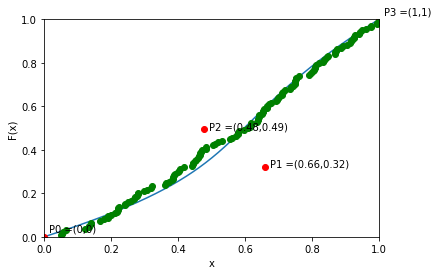

Predicted: P1=(0.66,0.32) P2=(0.48,0.49)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


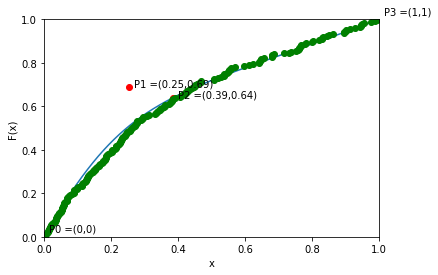

Predicted: P1=(0.25,0.69) P2=(0.39,0.64)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


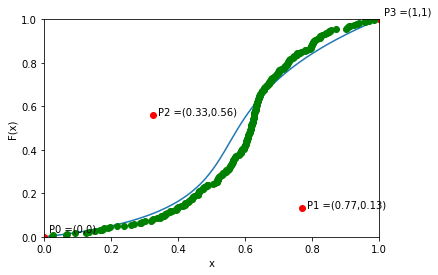

Predicted: P1=(0.77,0.13) P2=(0.33,0.56)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


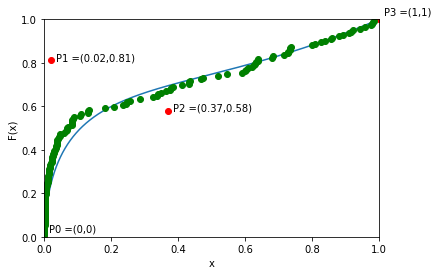

Predicted: P1=(0.02,0.81) P2=(0.37,0.58)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


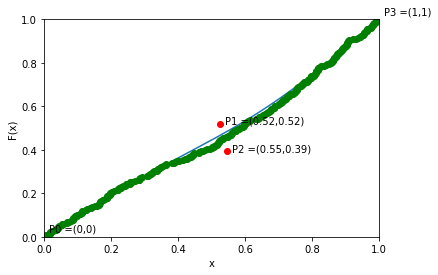

Predicted: P1=(0.52,0.52) P2=(0.55,0.39)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


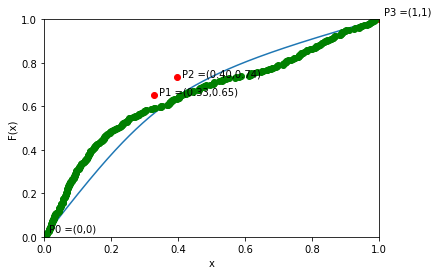

Predicted: P1=(0.33,0.65) P2=(0.40,0.74)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


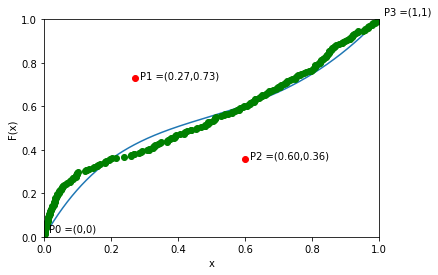

Predicted: P1=(0.27,0.73) P2=(0.60,0.36)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


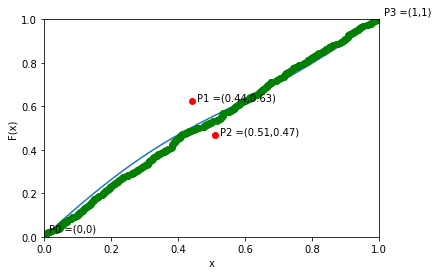

Predicted: P1=(0.44,0.63) P2=(0.51,0.47)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


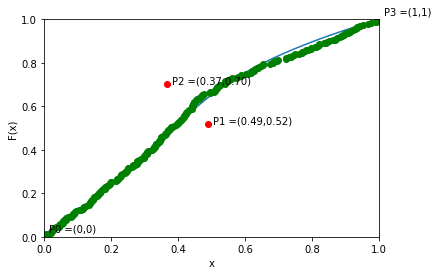

Predicted: P1=(0.49,0.52) P2=(0.37,0.70)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


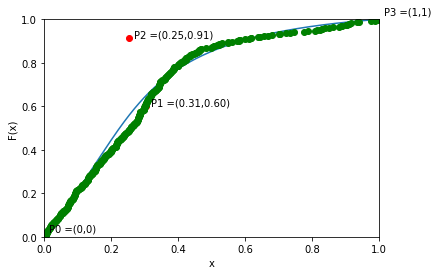

Predicted: P1=(0.31,0.60) P2=(0.25,0.91)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


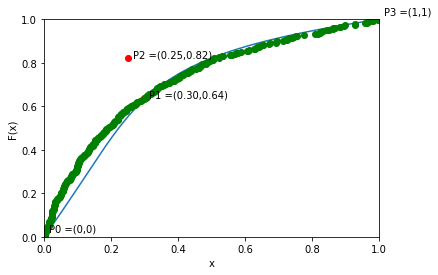

Predicted: P1=(0.30,0.64) P2=(0.25,0.82)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


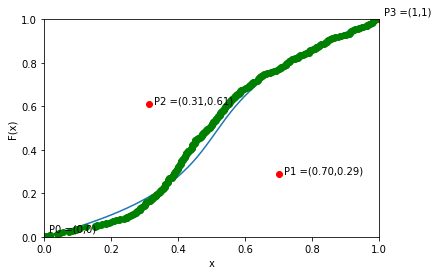

Predicted: P1=(0.70,0.29) P2=(0.31,0.61)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


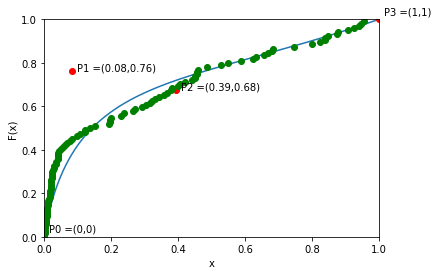

Predicted: P1=(0.08,0.76) P2=(0.39,0.68)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


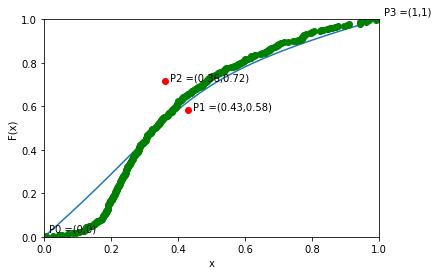

Predicted: P1=(0.43,0.58) P2=(0.36,0.72)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


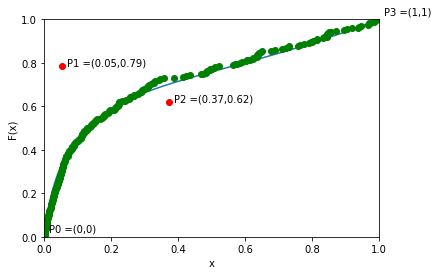

Predicted: P1=(0.05,0.79) P2=(0.37,0.62)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


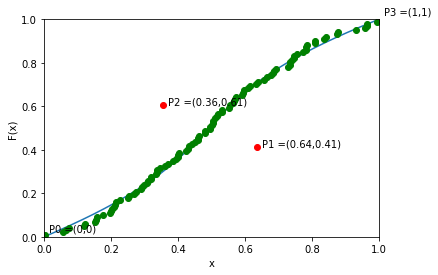

Predicted: P1=(0.64,0.41) P2=(0.36,0.61)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


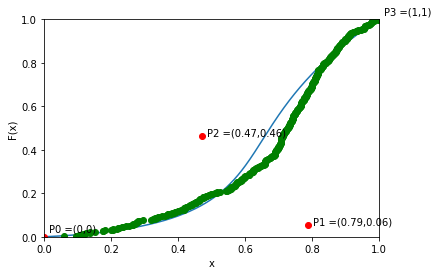

Predicted: P1=(0.79,0.06) P2=(0.47,0.46)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


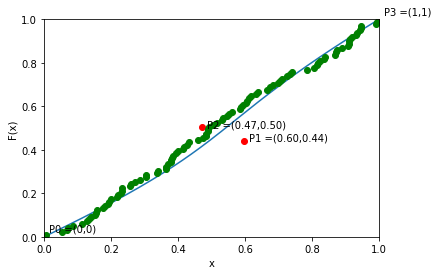

Predicted: P1=(0.60,0.44) P2=(0.47,0.50)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


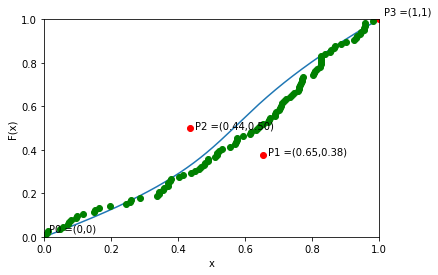

Predicted: P1=(0.65,0.38) P2=(0.44,0.50)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


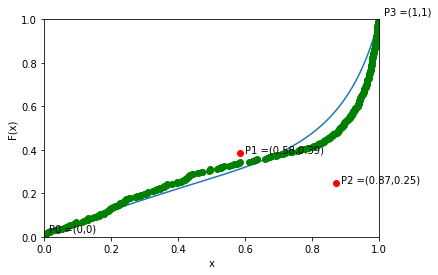

Predicted: P1=(0.58,0.39) P2=(0.87,0.25)
Actual:    P1=(0.42,0.12) P2=(0.65,0.57)


In [16]:
#load pre-run model
feature_columns = [tf.feature_column.numeric_column(key="x", shape=sample_size)]
prerun = './tmp/regression_477366' 
estimator = tf.estimator.DNNRegressor(feature_columns=feature_columns, hidden_units=nn_hidden, label_dimension=output_nodes, 
                                      activation_fn=tf.nn.sigmoid, model_dir=prerun,warm_start_from=prerun)

def predict_bezier(loss_samples):
    loss_samples_n = normalise_x(loss_samples)
    """Take an array of up to 500 losses and return the Bezier points"""
    predict_input_fn = tf.estimator.inputs.numpy_input_fn({"x": loss_samples_n}, num_epochs=1, shuffle=False)
    results_gf = estimator.predict(input_fn=predict_input_fn)
    predict_points = np.empty((0,output_nodes))
    for i in results_gf:
        predict_points = np.vstack((predict_points, i['predictions']))    
    predict_points = denormalise_y(predict_points)
    #print (predict_points)
    #p1 = Point(predict_points[0,0],predict_points[0,1])
    #p2 = Point(predict_points[0,2],predict_points[0,3])
    return predict_points


# create random loss samples
n_examples = 20
new_data_set = np.array(generate_data(n_examples,sample_size))
y_new_actual = new_data_set[:,0:output_nodes]
x_new = new_data_set[:,output_nodes:(output_nodes+sample_size)]

y_new_predict = predict_bezier(x_new)
for i in range(n_examples):
    buildcurve(p0,Point(y_new_predict[i,0],y_new_predict[i,1]),Point(y_new_predict[i,2],y_new_predict[i,3]),p3,x_new[i])
    print('Predicted: P1=(%.2f,%.2f) P2=(%.2f,%.2f)' % (y_new_predict[i,0] ,y_new_predict[i,1],y_new_predict[i,2],y_new_predict[i,3]))
    print('Actual:    P1=(%.2f,%.2f) P2=(%.2f,%.2f)' % (y_new_actual[0][0] ,y_new_actual[0][1],y_new_actual[0][2],y_new_actual[0][3]))




## Next Steps

We now have a very basic model that will provide us with automated curve fits. Three future steps would be:
  1. Test prediction performance using sampled data from other statistical distributions
  1. Examine the performance on real data
  1. Further optimise the models learning ability. E.g. systematically adjusting the volumes of training data, network structure and other factors
 
  

## Limitations
The synthetic training data we have generated using uniform distributions might not be sufficiently skewed to provide a good fit to 'fat tailed' claims data. 

Further steps could be to investigate performance in fitting to a Pareto distribution with a low alpha (<1) parameter.

To achieve a better performance on extreme value distribtuions, we could try higher order Bezier curves, or a wider range of handle parameters (P1 and P2). Unfortunately this would likely result in some generated curves that break the monotonically increasing requirement of a CDF. Perhaps we could address this by introducing an additional screening step to remove any such curves from our training data.

The choice of curve used to train the model is likely to be critical to the models performance. Cubic Bezier curves were used here as they are easy to work with, and appear to provide a superfically good-fit to a wide range of distributions. However the same model could be trained using random selections from other traditional probability distributions (lognormal, pareto etc), or even a mix and match from multiple distribtuions.

In providing a value between zero and one the model would be useful in situations when the total policy exposure in insurance is capped. However there are examples of insurance classes that have no defined upper limit of exposure (UK Motor libaility for example).

## Strengths
The main strengths of the method are that it satisfies most of the criteria we discussed above:
  1. Produce smooth parametric distributions that can be described by a small number of parameters
  1. Provide severity values in the range (0,1) - to be applied to maxmium exposure amounts to generate monnetary losses
  1. No pre-knowledge of the underlying distribution family should be required
  1. Provide a good fit to a wide range of real world claims data, without the need to compare goodness-of-fit across different distribution families
  1. Offers a simple method of generating means, standard deviations and other statistics*
  1. Allow measurement of the confidence in the goodness-of-fit**

\*It is relatively strightforward to compute common statistical metrics from Bezier curves using numerical methods

\*\*An approach for measuring the confidence in the goodness-of-fit is discussed below.

## Further Applications - Measure of confidence
It is technically possible to extract the confidence of the neural network in its own predictions (although not covered here!).

This could probably be achieved using a set of four classifier (soft max) neural networks, with one trained for each Bezier output point.

The classifications used would be numerical bands, and the trained model output would be the probability distribution of the predicted parameter.